In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
from collections import defaultdict
import scipy
from scipy import integrate
from iminuit import minimize, Minuit
from tqdm import tqdm
from multiprocessing import Pool

In [2]:
# Fixed the bins, colors, mass arr, and labels for all plots.
bins_min, bins_max, bins_w = 120, 230, 1
bins = np.arange(bins_min, bins_max+1, bins_w)
bins_mid = bins[:-1]+bins_w/2
bins_dense = np.linspace(bins_min, bins_max, 1000)

mass = [170, 171, 172, 173, 174, 175, 176]
top_mass_dense = np.linspace(170, 176, 1000)
top_mass_chi2 = np.linspace(166, 180, 1000)
sudo_bins = np.arange(166, 180, 0.2)
sudo_bins_dense = np.linspace(166, 180, 1000)

loglikeli_cut = -70
assignmment_cut = 0.12
marginal_prob_cut = 0.23
states = [0, 1, 2]

sudo_event = 10000
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
state_labels = ['Unmatched', 'Incorrect', 'Correct']
langau_fit_labels = ['Peak of Landau', 'Width of Landau', 'Mean of Gaussian', 'Std of Gaussian', 'Fraction of Gaussian']


In [3]:
def get_reco_top_mass(h5py_file, target): # Target is spanet or klfitter
    dic = {}

    #Load pt, eta, phi, and mass from file. Where q1, q2 and b are the index.
    q1 = np.array([[i] for i in h5py_file[target + '/right_target/q1'][:]])
    dic['q1_pt'] = np.take_along_axis(h5py_file['jet_features/pt'][:], q1, axis=1).flatten()
    dic['q1_eta'] = np.take_along_axis(h5py_file['jet_features/eta'][:], q1, axis=1).flatten()
    dic['q1_phi'] = np.take_along_axis(h5py_file['jet_features/phi'][:], q1, axis=1).flatten()
    dic['q1_mass'] = np.take_along_axis(h5py_file['jet_features/mass'][:], q1, axis=1).flatten()

    q2 = np.array([[i] for i in h5py_file[target + '/right_target/q2'][:]])
    dic['q2_pt'] = np.take_along_axis(h5py_file['jet_features/pt'][:], q2, axis=1).flatten()
    dic['q2_eta'] = np.take_along_axis(h5py_file['jet_features/eta'][:], q2, axis=1).flatten()
    dic['q2_phi'] = np.take_along_axis(h5py_file['jet_features/phi'][:], q2, axis=1).flatten()
    dic['q2_mass'] = np.take_along_axis(h5py_file['jet_features/mass'][:], q2, axis=1).flatten()

    b = np.array([[i] for i in h5py_file[target + '/right_target/b'][:]])
    dic['b_pt'] = np.take_along_axis(h5py_file['jet_features/pt'][:], b, axis=1).flatten()
    dic['b_eta'] = np.take_along_axis(h5py_file['jet_features/eta'][:], b, axis=1).flatten()
    dic['b_phi'] = np.take_along_axis(h5py_file['jet_features/phi'][:], b, axis=1).flatten()
    dic['b_mass'] = np.take_along_axis(h5py_file['jet_features/mass'][:], b, axis=1).flatten()
    
    # px = pt*cos(phi)
    # py = pt*sin(phi)
    # pz = pt*sinh(eta)
    # E  = sqrt(m**2 + px**2 + py**2 + pz**2)*JSF
    dic['px1'] = dic['q1_pt']*np.cos(dic['q1_phi'])
    dic['py1'] = dic['q1_pt']*np.sin(dic['q1_phi'])
    dic['pz1'] = dic['q1_pt']*np.sinh(dic['q1_eta'])
    dic['E1'] = np.sqrt(dic['q1_mass']**2+dic['px1']**2+dic['py1']**2+dic['pz1']**2)

    dic['px2'] = dic['q2_pt']*np.cos(dic['q2_phi'])
    dic['py2'] = dic['q2_pt']*np.sin(dic['q2_phi'])
    dic['pz2'] = dic['q2_pt']*np.sinh(dic['q2_eta'])
    dic['E2'] = np.sqrt(dic['q2_mass']**2+dic['px2']**2+dic['py2']**2+dic['pz2']**2)

    dic['bx'] = dic['b_pt']*np.cos(dic['b_phi'])
    dic['by'] = dic['b_pt']*np.sin(dic['b_phi'])
    dic['bz'] = dic['b_pt']*np.sinh(dic['b_eta'])
    dic['bE'] = np.sqrt(dic['b_mass']**2+dic['bx']**2+dic['by']**2+dic['bz']**2)
    
    # M = sqrt((m1+m2)**2 + (px1+px2)**2 + (py1+py2)**2 + (pz1+pz2)**2)
    dic['reconstructed_top_mass'] = np.sqrt((dic['E1']+dic['E2']+dic['bE'])**2
                    - (dic['px1']+dic['px2']+dic['bx'])**2
                    - (dic['py1']+dic['py2']+dic['by'])**2
                    - (dic['pz1']+dic['pz2']+dic['bz'])**2)

    """
    cuts
    bins_min < reco_m_top < bins_max
    additional cuts (same as CMS)
    """
    reco_cuts = np.logical_and(dic['reconstructed_top_mass'] > bins_min, dic['reconstructed_top_mass'] < bins_max)

    # Check the state of the event.
    state = [1]*len(h5py_file['target/right_target/q1'][:])

    # Two permutations for q1 and q2.
    permu1 = np.logical_and(h5py_file['target/right_target/q1'][:] == h5py_file[target + '/right_target/q1'][:], 
                        h5py_file['target/right_target/q2'][:] == h5py_file[target + '/right_target/q2'][:])
    permu2 = np.logical_and(h5py_file['target/right_target/q1'][:] == h5py_file[target + '/right_target/q2'][:], 
                        h5py_file['target/right_target/q2'][:] == h5py_file[target + '/right_target/q1'][:])
    correct = np.logical_and(np.logical_or(permu1, permu2), h5py_file['target/right_target/b'][:] == h5py_file[target + '/right_target/b'][:])
    state = np.where(correct, 2, state)

    # Check for unmatch
    unmatch = np.logical_or.reduce((h5py_file['target/right_target/q1'][:] == -1,
                        h5py_file['target/right_target/q2'][:] == -1,
                        h5py_file['target/right_target/b'][:] == -1))
    state = np.where(unmatch, 0, state)
    if target == 'klfitter': return dic['reconstructed_top_mass'], state, reco_cuts, h5py_file['klfitter/score/loglikelihood'][:]>loglikeli_cut
    elif target == 'permutation_dnn': return dic['reconstructed_top_mass'], state, reco_cuts, h5py_file['permutation_dnn/assignment_score'][:]>assignmment_cut
    elif target == 'spanet': return dic['reconstructed_top_mass'], state, reco_cuts, h5py_file['spanet/right_target/marginal_probability'][:]>marginal_prob_cut
    else: return dic['reconstructed_top_mass'], state, reco_cuts
    

In [4]:
# The reco_top_mss from ttbar_testing_mass_variation
# 0 for unmatched, 1 for incorrect, 2 for correct
reco_klf_dic, state_klf_dic, cut_klf_dic, likeli_klf_dic = {}, {}, {}, {}
reco_pdnn_dic, state_pdnn_dic, cut_pdnn_dic, likeli_pdnn_dic = {}, {}, {}, {}
reco_spanet_dic, state_spanet_dic, cut_spanet_dic, likeli_spanet_dic = {}, {}, {}, {}
reco_perfect_dic, state_perfect_dic, cut_perfect_dic = {}, {}, {}

for m in mass:
    h5py_file = h5py.File(f'ttbar_testing_final_mass_variation_JSF=1.00/ttbar_testing_{m}_gev_with_spanet_pdnn_KLFitter.h5', "r")
    reco_klf_dic[m], state_klf_dic[m], cut_klf_dic[m], likeli_klf_dic[m] = get_reco_top_mass(h5py_file, 'klfitter')
    h5py_file = h5py.File(f'ttbar_testing_final_mass_variation_JSF=1.00/ttbar_testing_{m}_gev.h5', "r")
    reco_pdnn_dic[m], state_pdnn_dic[m], cut_pdnn_dic[m], likeli_pdnn_dic[m] = get_reco_top_mass(h5py_file, 'permutation_dnn')
    reco_spanet_dic[m], state_spanet_dic[m], cut_spanet_dic[m], likeli_spanet_dic[m] = get_reco_top_mass(h5py_file, 'spanet')
    reco_perfect_dic[m], state_perfect_dic[m], cut_perfect_dic[m] = get_reco_top_mass(h5py_file, 'target')
    

/tmp/ipykernel_73/271057178.py:43: RuntimeWarning: invalid value encountered in sqrt
  dic['reconstructed_top_mass'] = np.sqrt((dic['E1']+dic['E2']+dic['bE'])**2


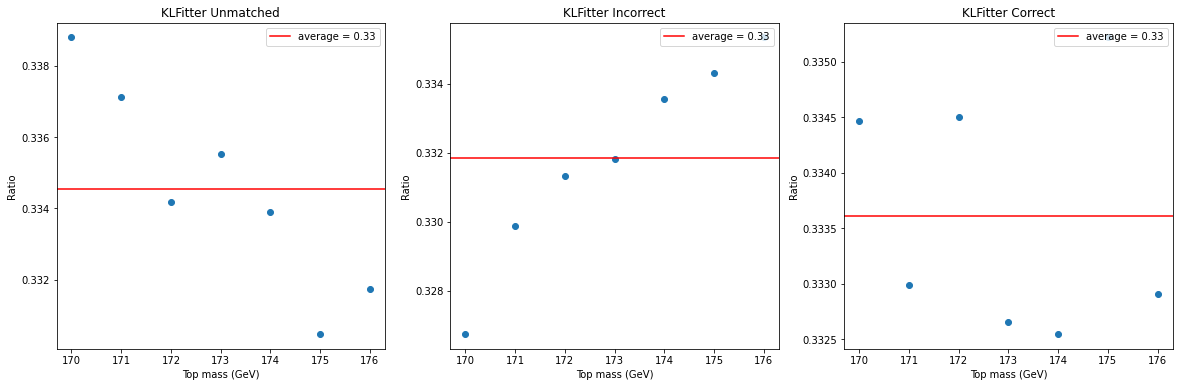

In [5]:
ratio_klf_dic = defaultdict(list)
for i, m in enumerate(mass):
    for state_i in states:
        ratio = np.count_nonzero(state_klf_dic[m][np.logical_and(cut_klf_dic[m], likeli_klf_dic[m])]==state_i)/len(state_klf_dic[m][np.logical_and(cut_klf_dic[m], likeli_klf_dic[m])])
        ratio_klf_dic[state_i].append(ratio)
ratio_klf = {key:np.mean(ratio_klf_dic[key]) for key in ratio_klf_dic}

plt.figure(figsize=(20, 6))
for state_i in states:
    plt.subplot(1, 3, state_i+1)
    plt.scatter(mass, ratio_klf_dic[state_i])
    plt.axhline(ratio_klf[state_i], c='r', label=f'average = {ratio_klf[state_i]:.2f}')
    plt.title('KLFitter ' + state_labels[state_i])
    plt.xlabel('Top mass (GeV)')
    plt.ylabel('Ratio')
    plt.legend(loc='upper right')
plt.savefig('plots_topmass/KLFitter ratio.png')
plt.show()


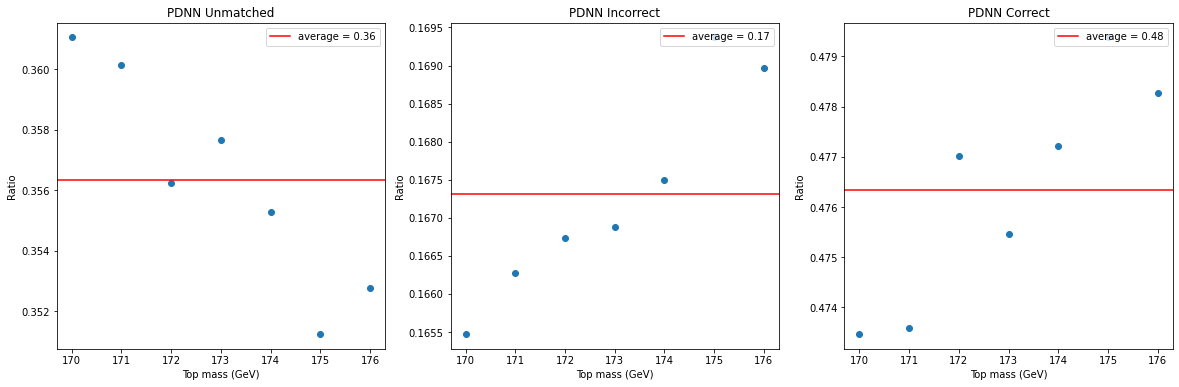

In [6]:
ratio_pdnn_dic = defaultdict(list)
for i, m in enumerate(mass):
    for state_i in states:
        ratio = np.count_nonzero(state_pdnn_dic[m][np.logical_and(cut_pdnn_dic[m], likeli_pdnn_dic[m])]==state_i)/len(state_pdnn_dic[m][np.logical_and(cut_pdnn_dic[m], likeli_pdnn_dic[m])])
        ratio_pdnn_dic[state_i].append(ratio)
ratio_pdnn = {key:np.mean(ratio_pdnn_dic[key]) for key in ratio_pdnn_dic}

plt.figure(figsize=(20, 6))
for state_i in states:
    plt.subplot(1, 3, state_i+1)
    plt.scatter(mass, ratio_pdnn_dic[state_i])
    plt.axhline(ratio_pdnn[state_i], c='r', label=f'average = {ratio_pdnn[state_i]:.2f}')
    plt.title('PDNN ' + state_labels[state_i])
    plt.xlabel('Top mass (GeV)')
    plt.ylabel('Ratio')
    plt.legend(loc='upper right')
plt.savefig('plots_topmass/PDNN ratio.png')
plt.show()


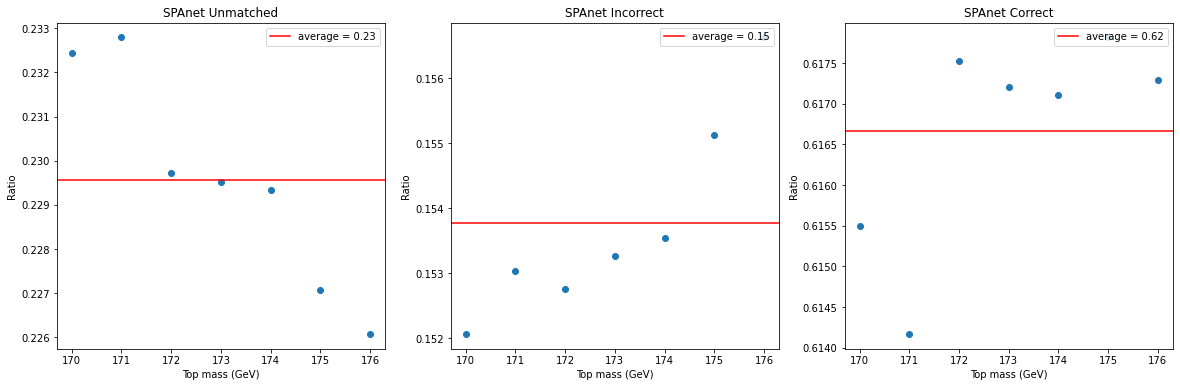

In [7]:
ratio_spanet_dic = defaultdict(list)
for i, m in enumerate(mass):
    for state_i in states:
        ratio = np.count_nonzero(state_spanet_dic[m][np.logical_and(cut_spanet_dic[m], likeli_spanet_dic[m])]==state_i)/len(state_spanet_dic[m][np.logical_and(cut_spanet_dic[m], likeli_spanet_dic[m])])
        ratio_spanet_dic[state_i].append(ratio)
ratio_spanet = {key:np.mean(ratio_spanet_dic[key]) for key in ratio_spanet_dic}

plt.figure(figsize=(20, 6))
for state_i in states:
    plt.subplot(1, 3, state_i+1)
    plt.scatter(mass, ratio_spanet_dic[state_i])
    plt.axhline(ratio_spanet[state_i], c='r', label=f'average = {ratio_spanet[state_i]:.2f}')
    plt.title('SPAnet ' + state_labels[state_i])
    plt.xlabel('Top mass (GeV)')
    plt.ylabel('Ratio')
    plt.legend(loc='upper right')
plt.savefig('plots_topmass/SPAnet ratio.png')
plt.show()


In [8]:
# Sum of a Landau distribution and a gaussian distribution. Landau currently uses moyal as approximation.
# Nomalized within -inf to inf
def langau(x, lan_loc, lan_scale, gau_loc, gau_scale, f):
    lan_y = (x-lan_loc)/lan_scale
    gau_y = (x-gau_loc)/gau_scale
    return (1-f)*np.exp(-(lan_y+np.exp(-lan_y))/2)/np.sqrt(2*np.pi)/lan_scale + f*np.exp(-gau_y**2/2)/np.sqrt(2*np.pi)/gau_scale

# Nomalized within bins_min and bins_max
def langau_norm(x, lan_loc, lan_scale, gau_loc, gau_scale, f):
    return langau(x, lan_loc, lan_scale, gau_loc, gau_scale, f)/integrate.quad(langau, bins_min, bins_max, args=(lan_loc, lan_scale, gau_loc, gau_scale, f))[0]

# fcn is the minimized function
def fcn(lan_loc, lan_scale, gau_loc, gau_scale, f):
    return -2*np.sum(hist*np.log(langau_norm(bins_mid, lan_loc, lan_scale, gau_loc, gau_scale, f)))*tot_event

# Gaussian distribution
def gau_norm(x, gau_loc1, gau_scale1):
    gau_y1 = (x-gau_loc1)/gau_scale1
    return np.exp(-gau_y1**2/2)/np.sqrt(2*np.pi)/gau_scale1

# Linear
def linear(x, a, b):
    return a*(x-173)+b

# Gaussian pdf use to check whether the fit is good
def chi2_pdf(observed, pdf): #observed is the observation, pdf is the normalized height of the bins from pdf.
    n1, _ = np.histogram(observed, bins=bins)
    n2 = pdf*bins_w*len(observed)
    return np.sum((n1-n2)**2/n2)

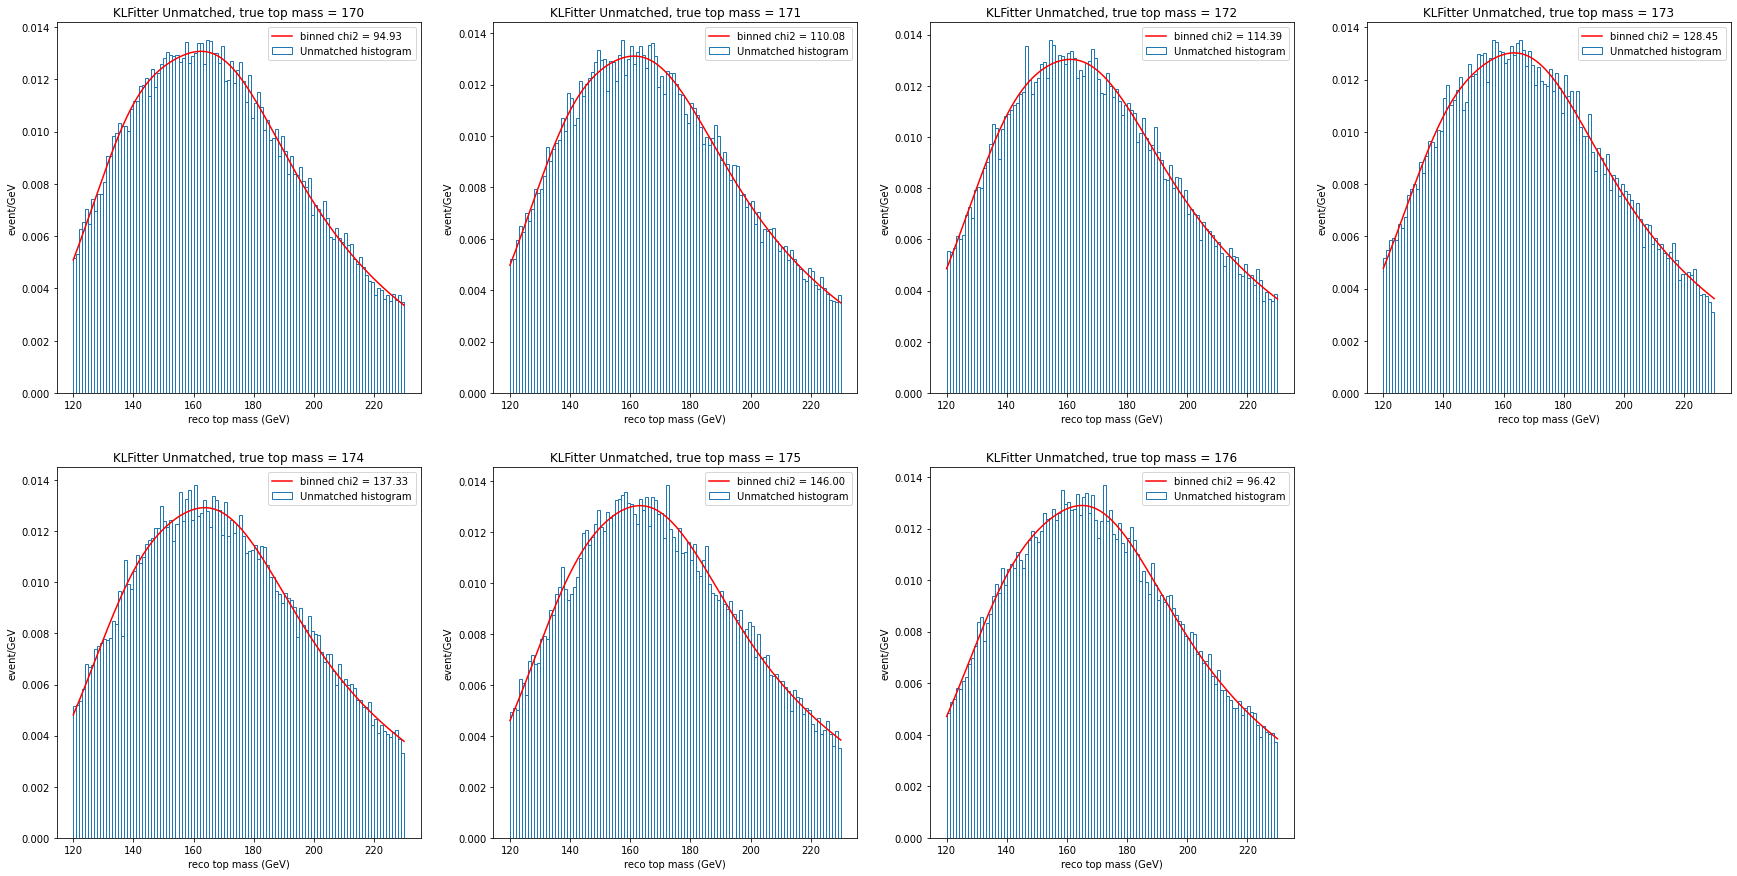

/tmp/ipykernel_73/1087738779.py:10: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  return langau(x, lan_loc, lan_scale, gau_loc, gau_scale, f)/integrate.quad(langau, bins_min, bins_max, args=(lan_loc, lan_scale, gau_loc, gau_scale, f))[0]


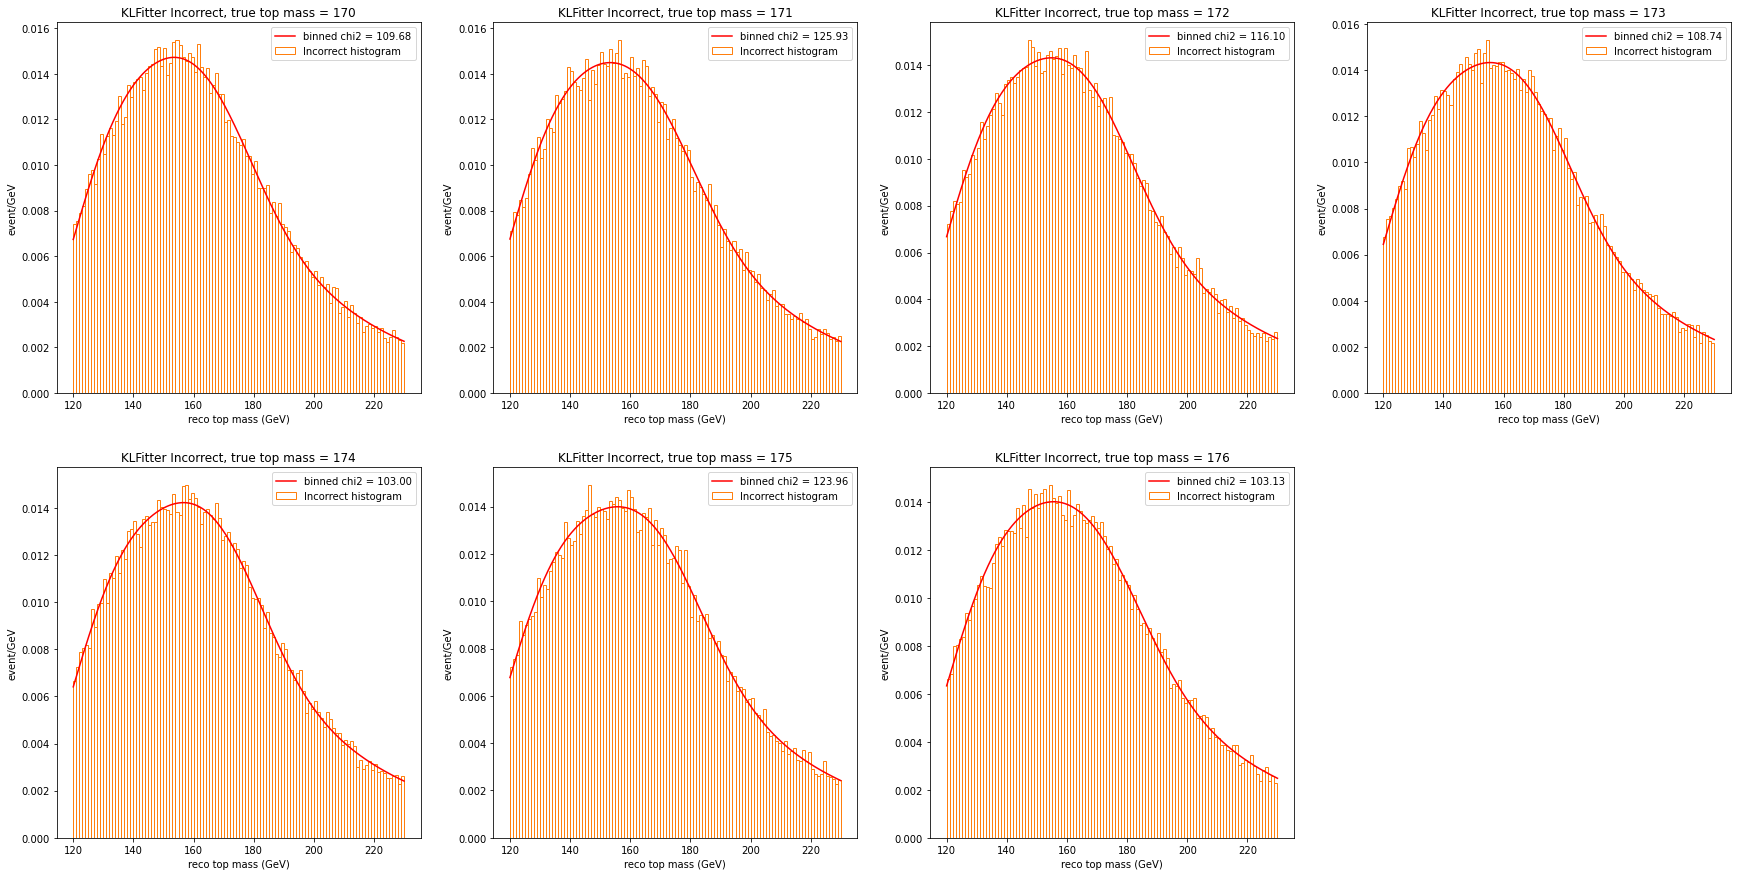

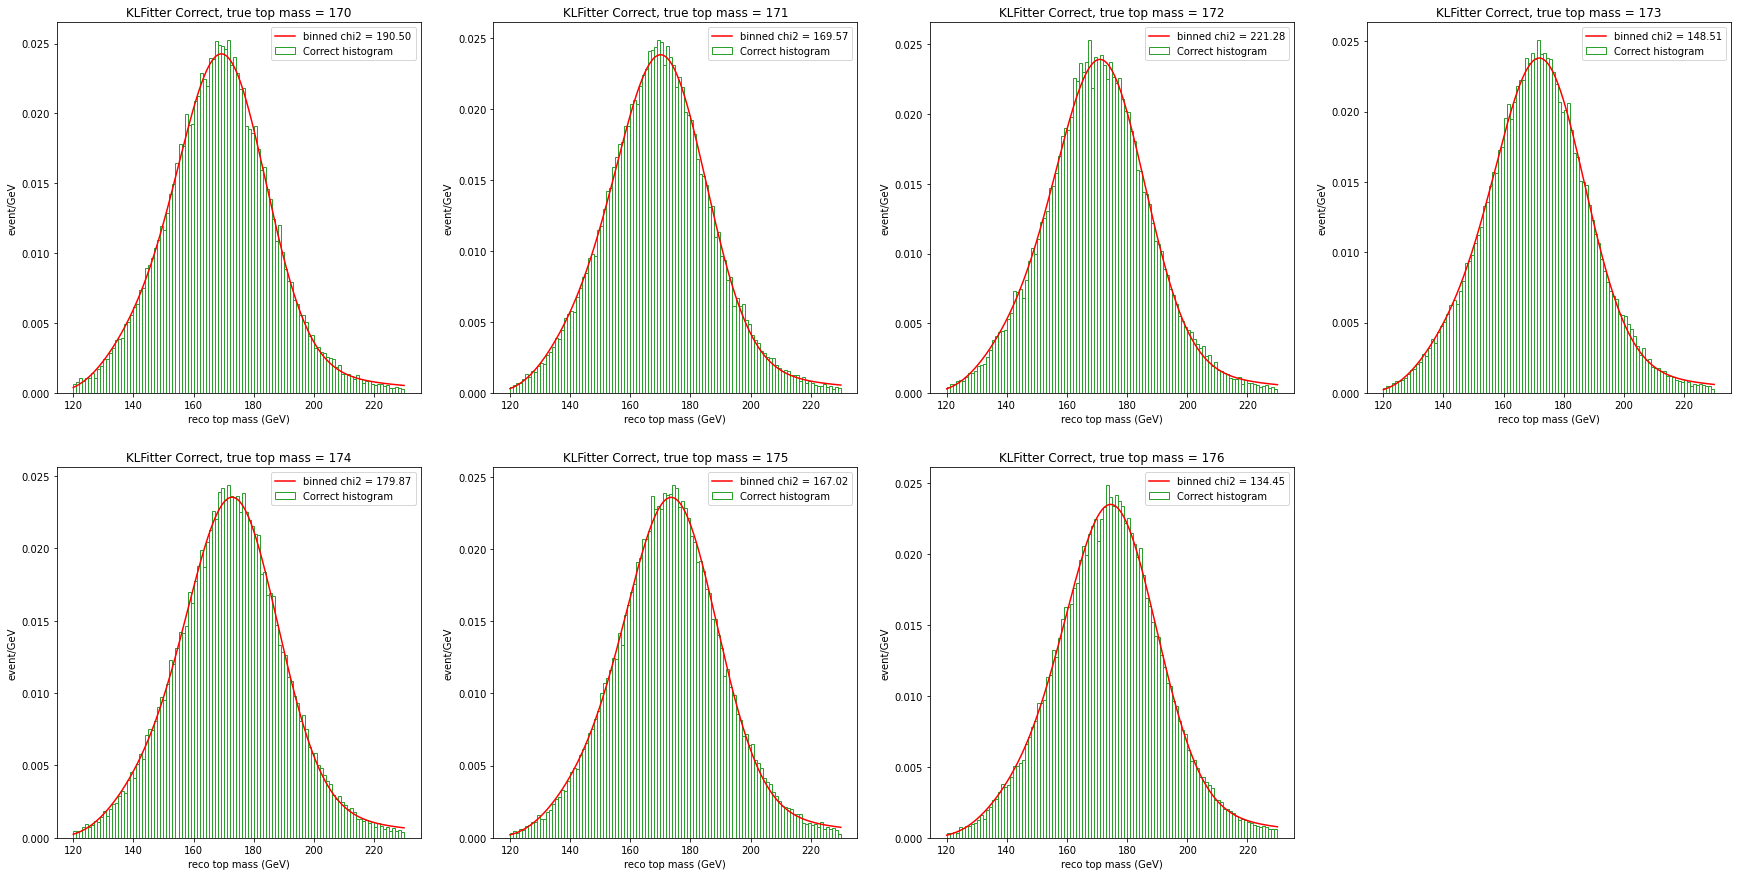

In [9]:
# Fit every class of KLFitter
fit_popt_dic = {i:{} for i in states}
fit_perr_dic = {i:{} for i in states}

for state_i in states:
    popt_klf_arr = []
    perr_klf_arr = []
    
    if state_i == 0: limits = [(100, 250), (5, 25), (100, 250), (5, 30), (0.55, 0.55)]
    elif state_i == 1: limits = [(100, 250), (5, 50), (150, 250), (5, 50), (0.12, 0.12)]
    else: limits = [(100, 250), (10, 50), (100, 250), (5, 16), (0.72, 0.72)]
    plt.figure(figsize=(30, 15))
    for i, m in enumerate(mass):
        plt.subplot(2, 4, i+1)
        fit_target = reco_klf_dic[m][np.logical_and.reduce((cut_klf_dic[m], likeli_klf_dic[m], state_klf_dic[m]==state_i))]
        hist, _ = np.histogram(fit_target, bins=bins, density=True)
        tot_event = len(fit_target)
        smallest_fcn = np.inf
        for _ in range(20):
            tol = 0.1
            start = [np.random.uniform(limits[i][0], limits[i][1]) for i in range(5)]
            while True:
                try:
                    minuit = Minuit(fcn, *start)
                    minuit.limits = limits
                    minuit.tol = tol
                    minuit.migrad()
                    minuit.minos()
                except: tol *= 2
                else: break
            if minuit.fval < smallest_fcn:
                smallest_fcn = minuit.fval
                popt, errors = list(minuit.values), list(minuit.errors)
        fit_popt_dic[state_i][m], fit_perr_dic[state_i][m] = popt, errors
        plt.plot(bins_dense, langau_norm(bins_dense, *popt), c='r', label=f'binned chi2 = {chi2_pdf(fit_target, langau_norm(bins_mid, *popt)):.2f}')
        plt.bar(bins_mid, hist, edgecolor=colors[state_i], width=bins_w, color='None', label = state_labels[state_i] + ' histogram')
        plt.title('KLFitter {}, true top mass = {}'.format(state_labels[state_i], m))
        plt.xlabel('reco top mass (GeV)')
        plt.ylabel('event/GeV')
        plt.legend(loc='upper right')
    plt.savefig(f'plots_topmass/KLFitter_pdf_fit/KLFitter top {state_labels[state_i]} fit.png', bbox_inches='tight')
    plt.show()

/usr/local/lib/python3.8/dist-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


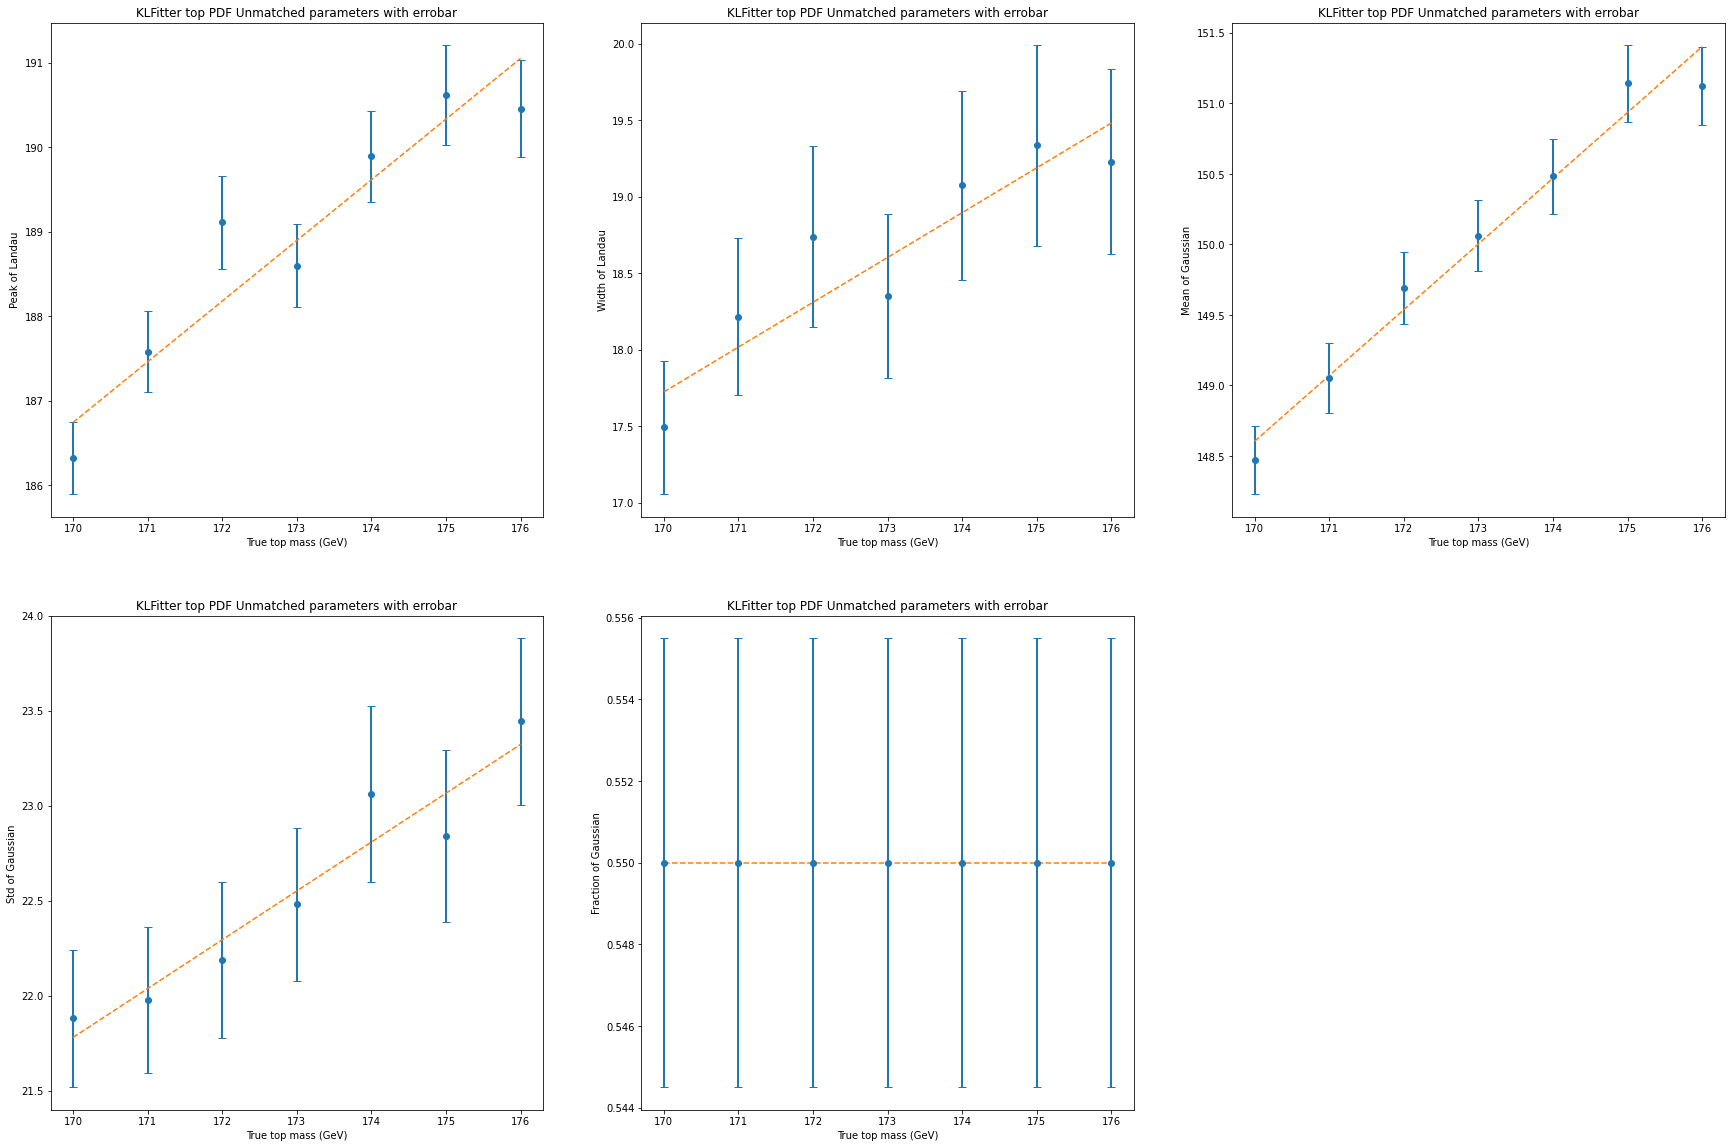

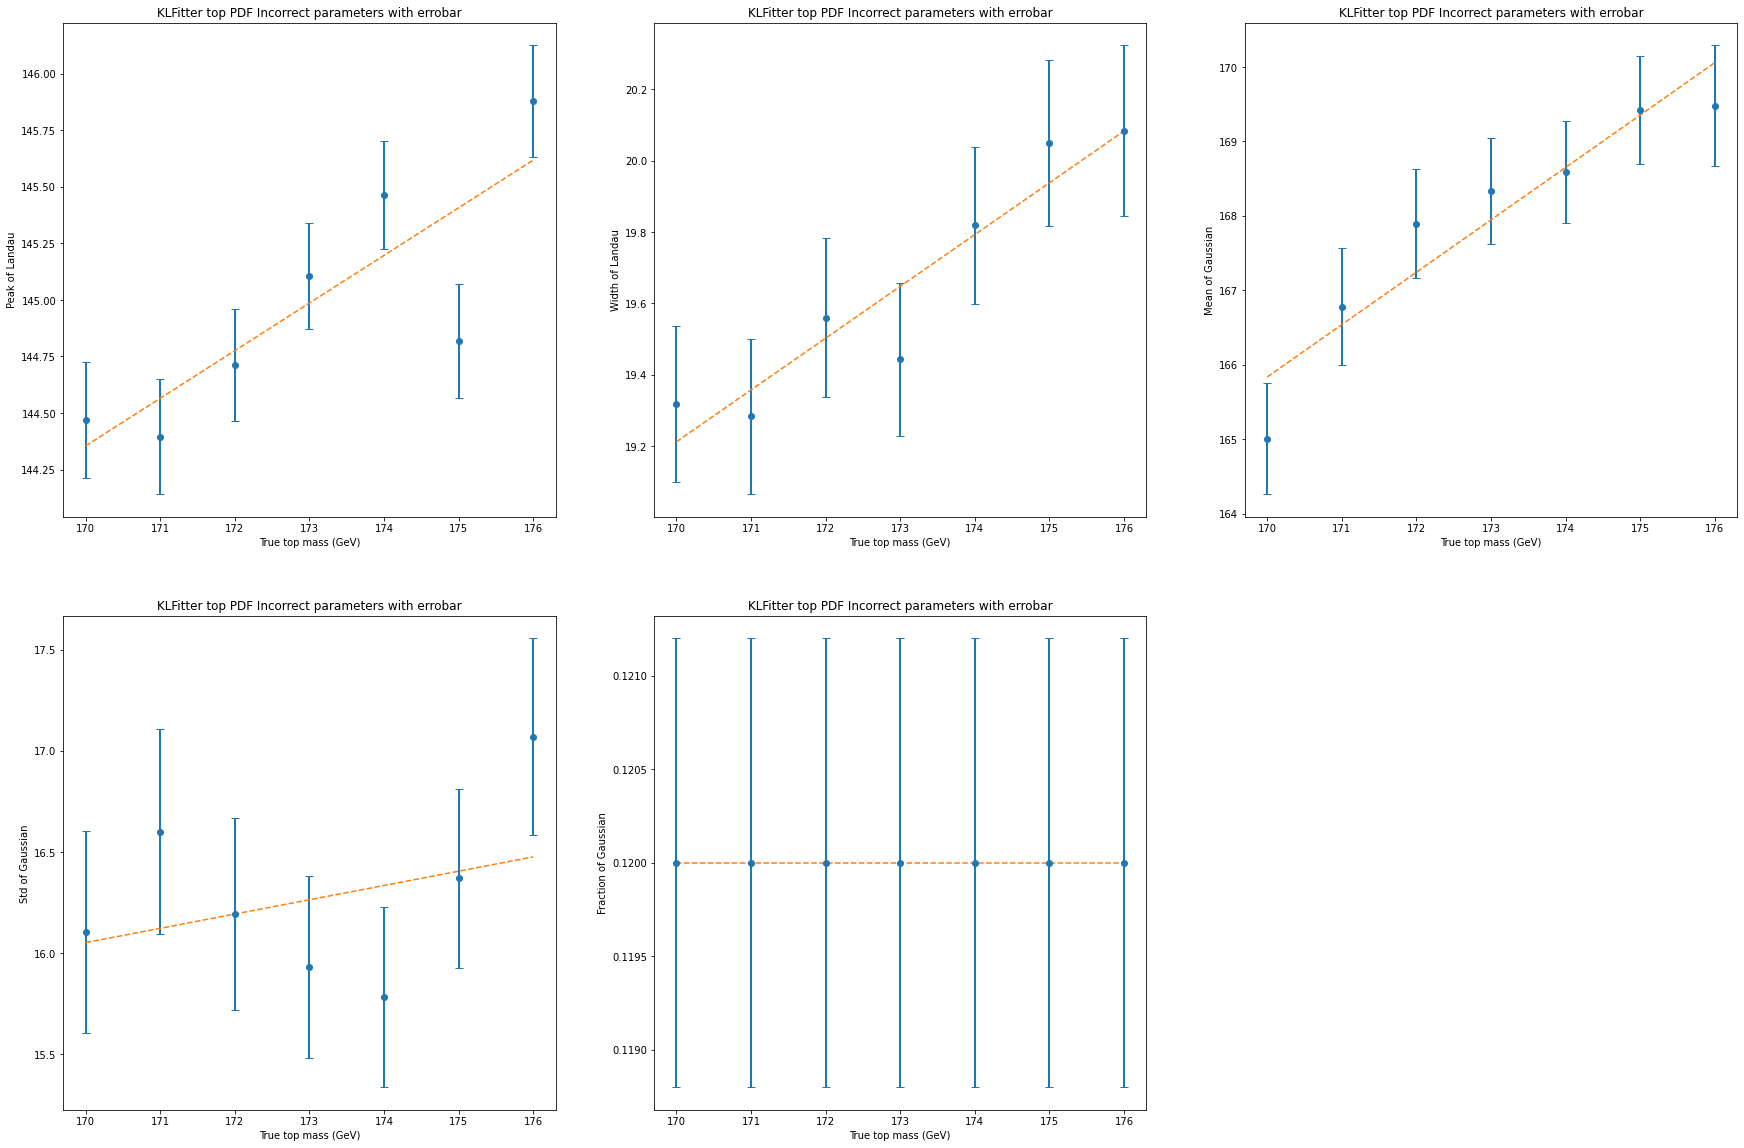

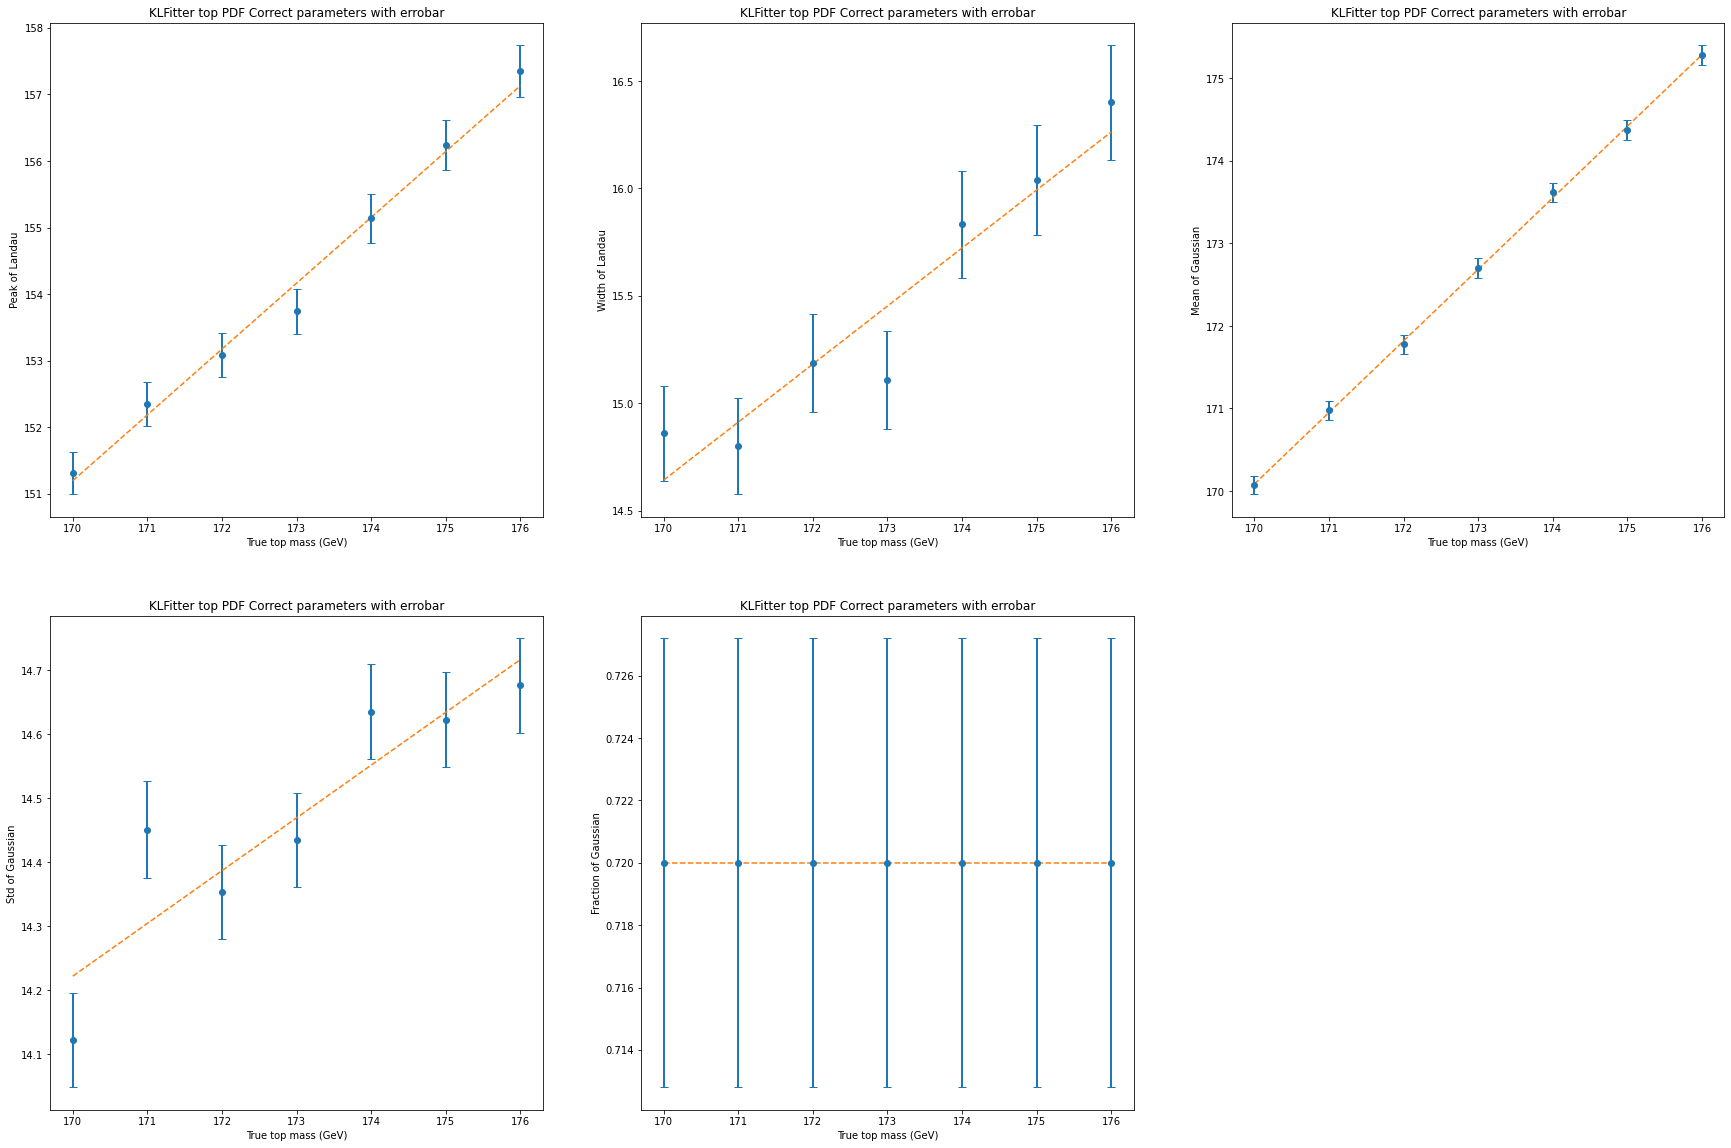

In [10]:
pdf_klf_top_dic = defaultdict(list)
for state_i in states:
    plt.figure(figsize=(30, 20))
    for i in range(5):
        plt.subplot(2, 3, i+1)
        popt, pcov = optimize.curve_fit(linear, np.transpose(list(fit_popt_dic[state_i].keys())), [fit_popt_dic[state_i][key][i] for key in fit_popt_dic[state_i]], sigma = [fit_perr_dic[state_i][key][i] for key in fit_popt_dic[state_i]], method="lm")
        pdf_klf_top_dic[(state_i, i)] = popt
        plt.errorbar(mass, [fit_popt_dic[state_i][m][i] for m in mass], yerr=[fit_perr_dic[state_i][m][i] for m in mass], fmt='o', elinewidth=2, capsize=4)
        plt.plot(top_mass_dense, linear(top_mass_dense, *popt), '--')
        plt.title(f'KLFitter top PDF {state_labels[state_i]} parameters with errobar')
        plt.xlabel('True top mass (GeV)')
        plt.ylabel(langau_fit_labels[i])
    plt.savefig(f'plots_topmass/KLFitter_param_fit/KLFitter top {state_labels[state_i]} parameter fit.png', bbox_inches='tight')
    plt.show()


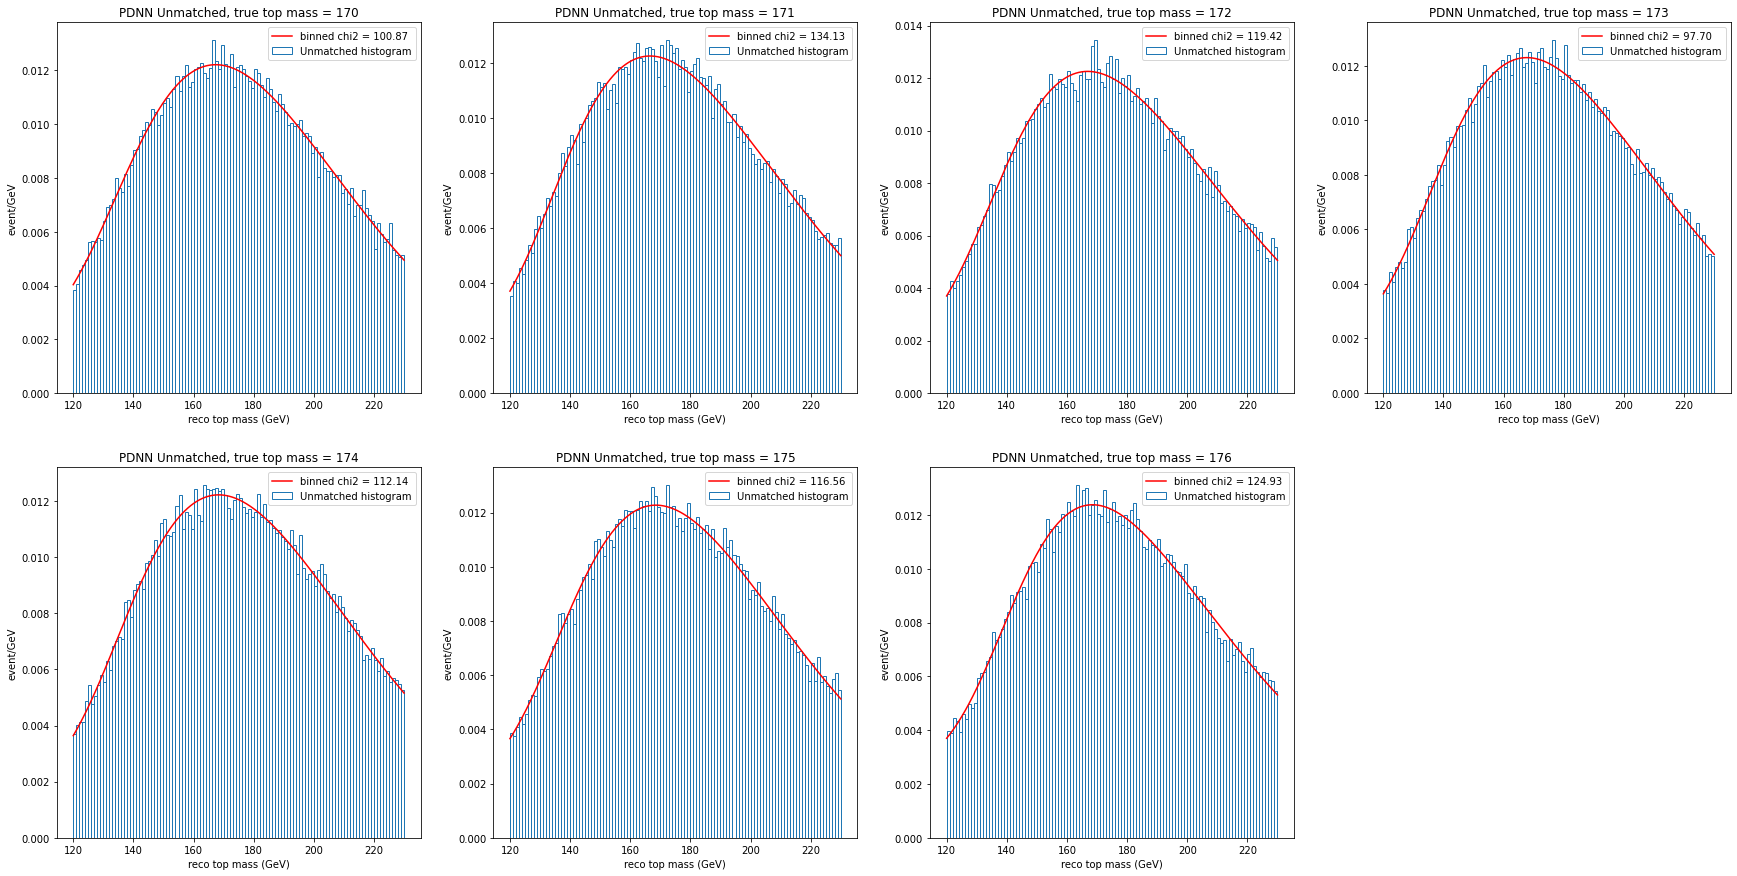

/tmp/ipykernel_73/1087738779.py:10: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  return langau(x, lan_loc, lan_scale, gau_loc, gau_scale, f)/integrate.quad(langau, bins_min, bins_max, args=(lan_loc, lan_scale, gau_loc, gau_scale, f))[0]


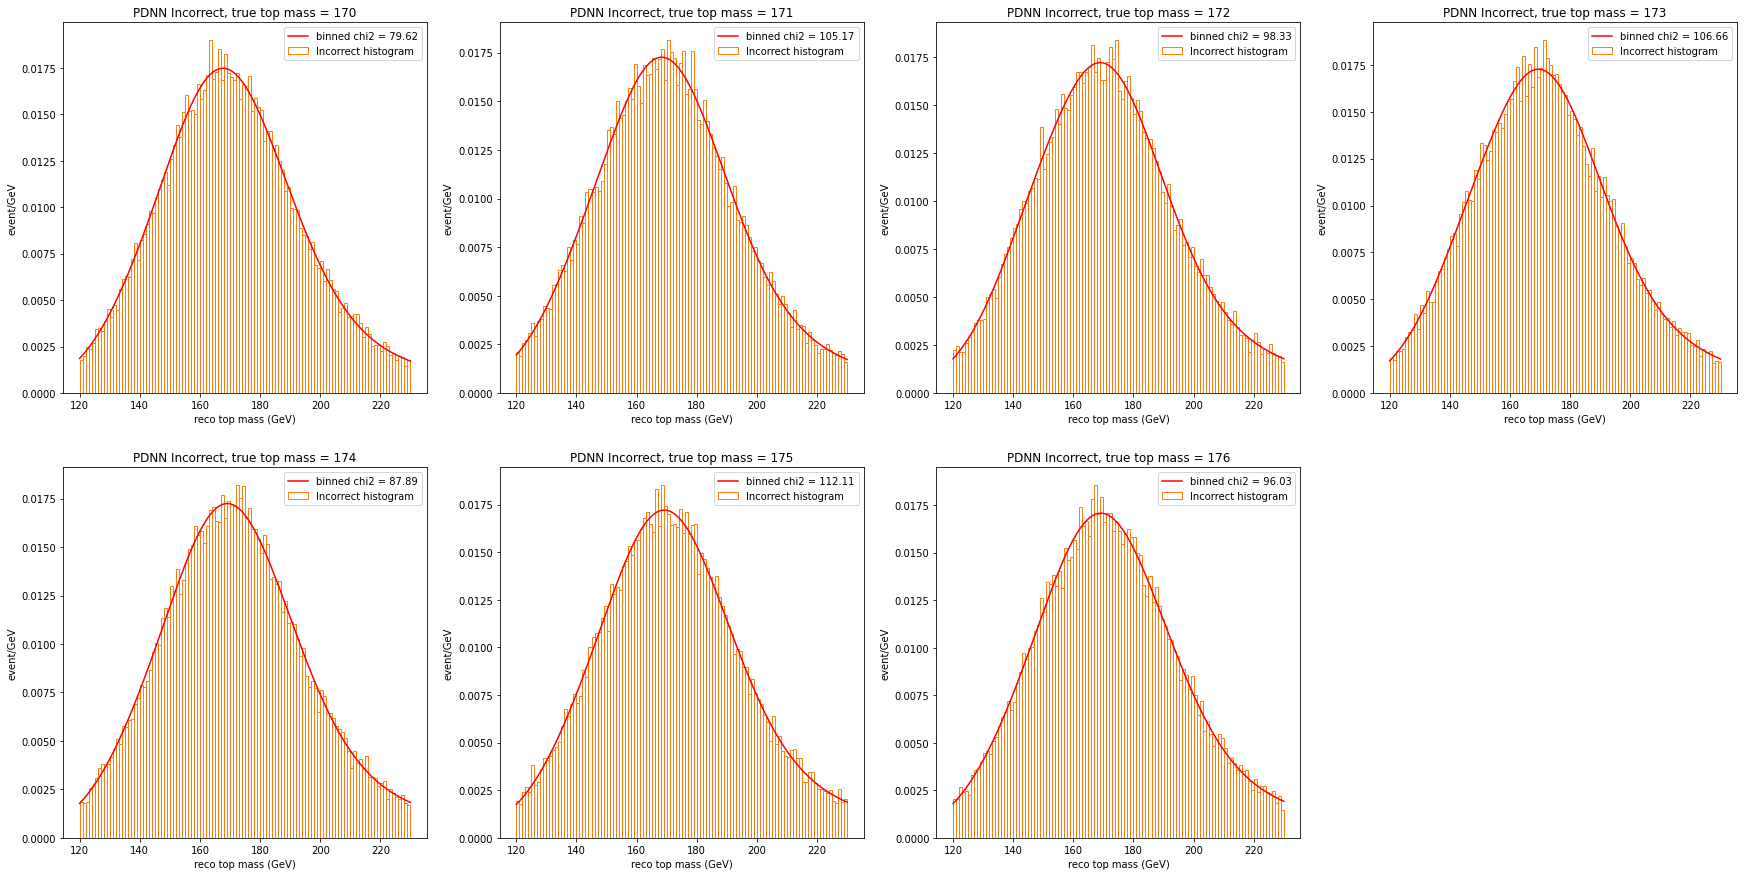

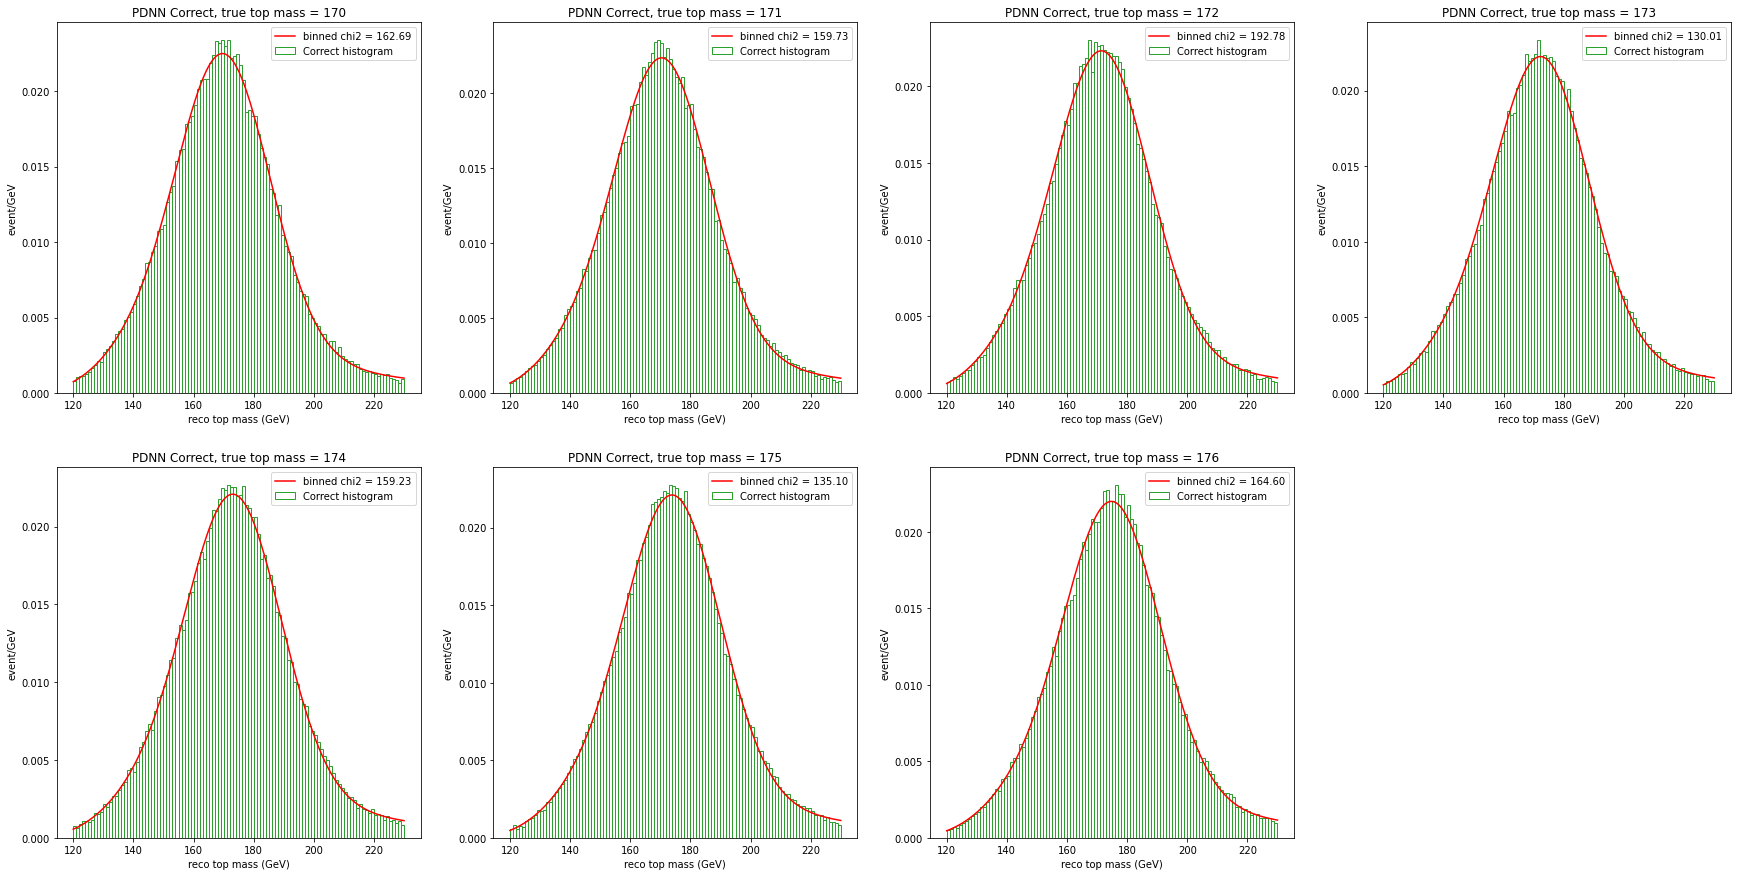

In [11]:
# Fit every class of PDNN
fit_popt_dic = {i:{} for i in states}
fit_perr_dic = {i:{} for i in states}

for state_i in states:
    popt_pdnn_arr = []
    perr_pdnn_arr = []
    limits = []
    if state_i == 0: limits = [(100, 180), (10, 50), (100, 250), (10, 50), (0.5, 0.5)]
    elif state_i == 1: limits = [(180, 250), (5, 50), (150, 250), (5, 50), (0.74, 0.74)]
    else: limits = [(100, 250), (10, 50), (100, 250), (5, 16), (0.70, 0.70)]
    plt.figure(figsize=(30, 15))
    for i, m in enumerate(mass):
        plt.subplot(2, 4, i+1)
        fit_target = reco_pdnn_dic[m][np.logical_and.reduce((cut_pdnn_dic[m], likeli_pdnn_dic[m], state_pdnn_dic[m]==state_i))]
        hist, _ = np.histogram(fit_target, bins=bins, density=True)
        tot_event = len(fit_target)
        smallest_fcn = np.inf
        for _ in range(20):
            tol = 0.1
            start = [np.random.uniform(limits[i][0], limits[i][1]) for i in range(5)]
            while True:
                try:
                    minuit = Minuit(fcn, *start)
                    minuit.limits = limits
                    minuit.tol = tol
                    minuit.migrad()
                    minuit.minos()
                except: tol *= 2
                else: break
            if minuit.fval < smallest_fcn:
                smallest_fcn = minuit.fval
                popt, errors = list(minuit.values), list(minuit.errors)
        fit_popt_dic[state_i][m], fit_perr_dic[state_i][m] = popt, errors
        plt.plot(bins_dense, langau_norm(bins_dense, *popt), c='r', label=f'binned chi2 = {chi2_pdf(fit_target, langau_norm(bins_mid, *popt)):.2f}')
        plt.bar(bins_mid, hist, edgecolor=colors[state_i], width=bins_w, color='None', label = state_labels[state_i] + ' histogram')
        plt.title('PDNN {}, true top mass = {}'.format(state_labels[state_i], m))
        plt.xlabel('reco top mass (GeV)')
        plt.ylabel('event/GeV')
        plt.legend(loc='upper right')
    plt.savefig(f'plots_topmass/PDNN_pdf_fit/PDNN top {state_labels[state_i]} fit.png', bbox_inches='tight')
    plt.show()

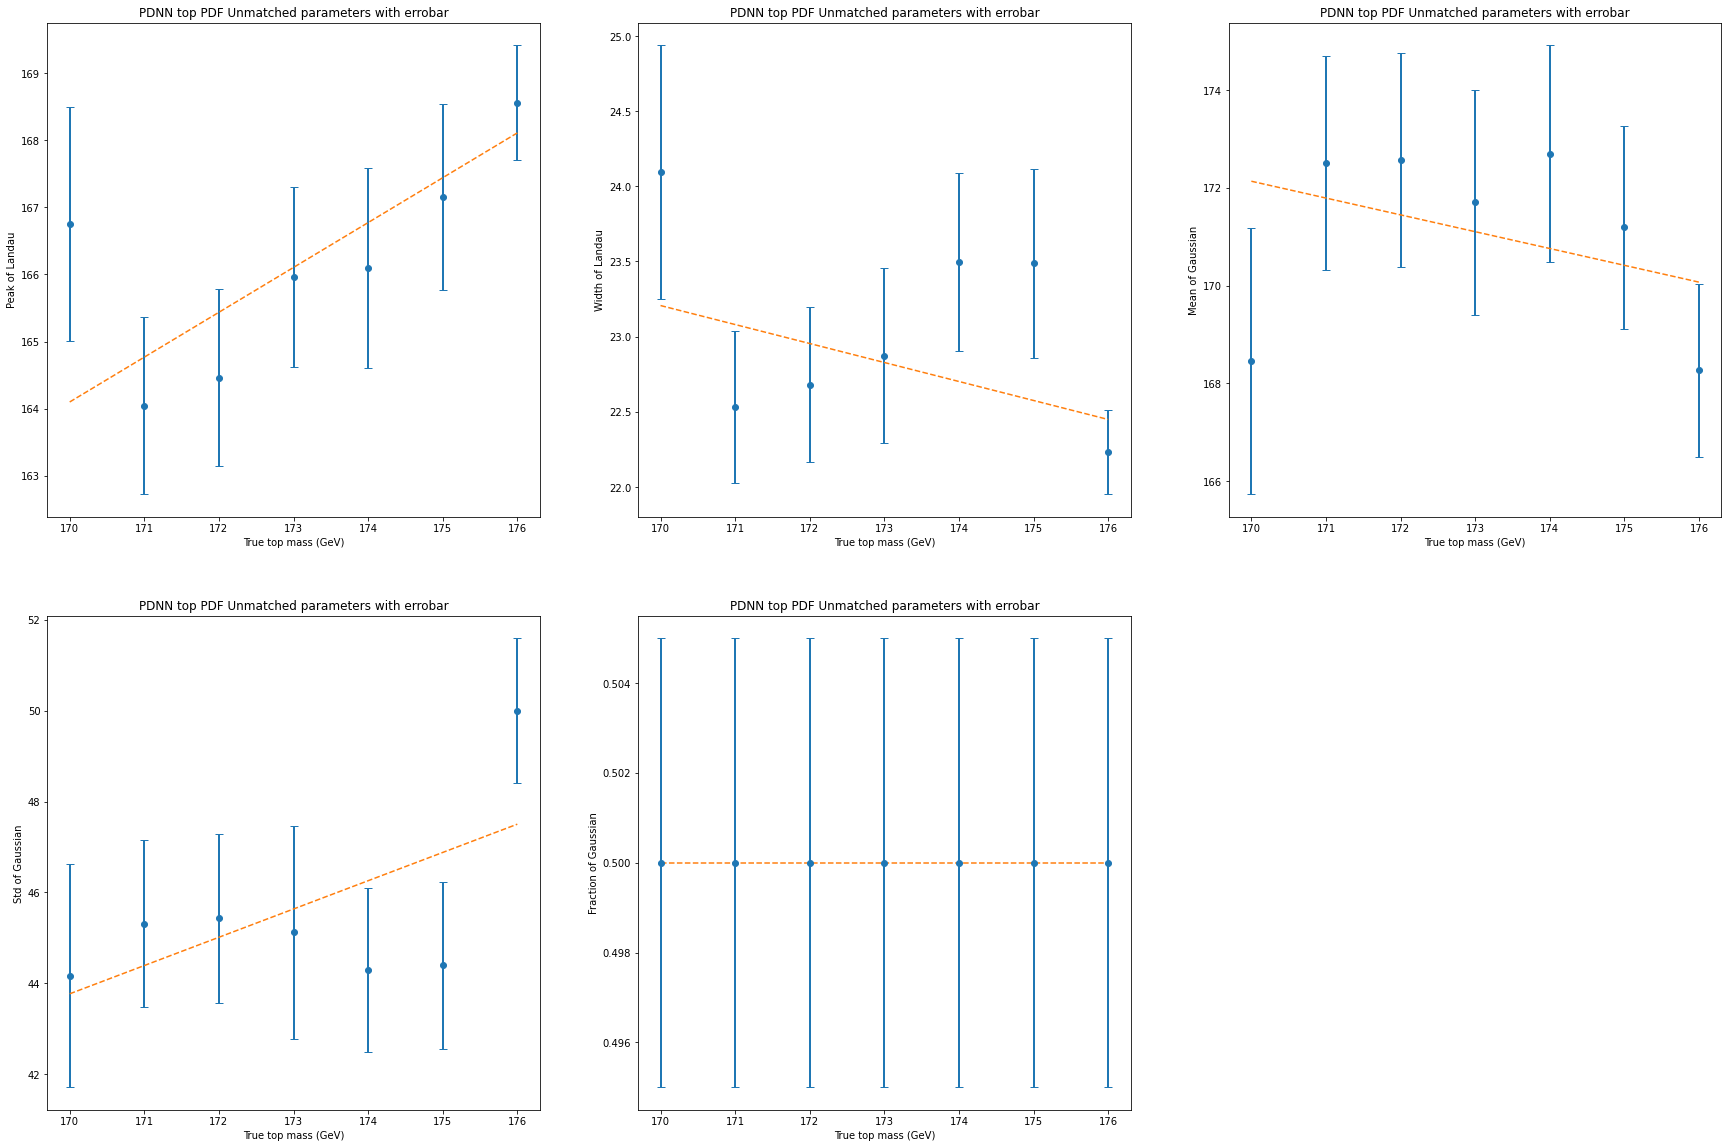

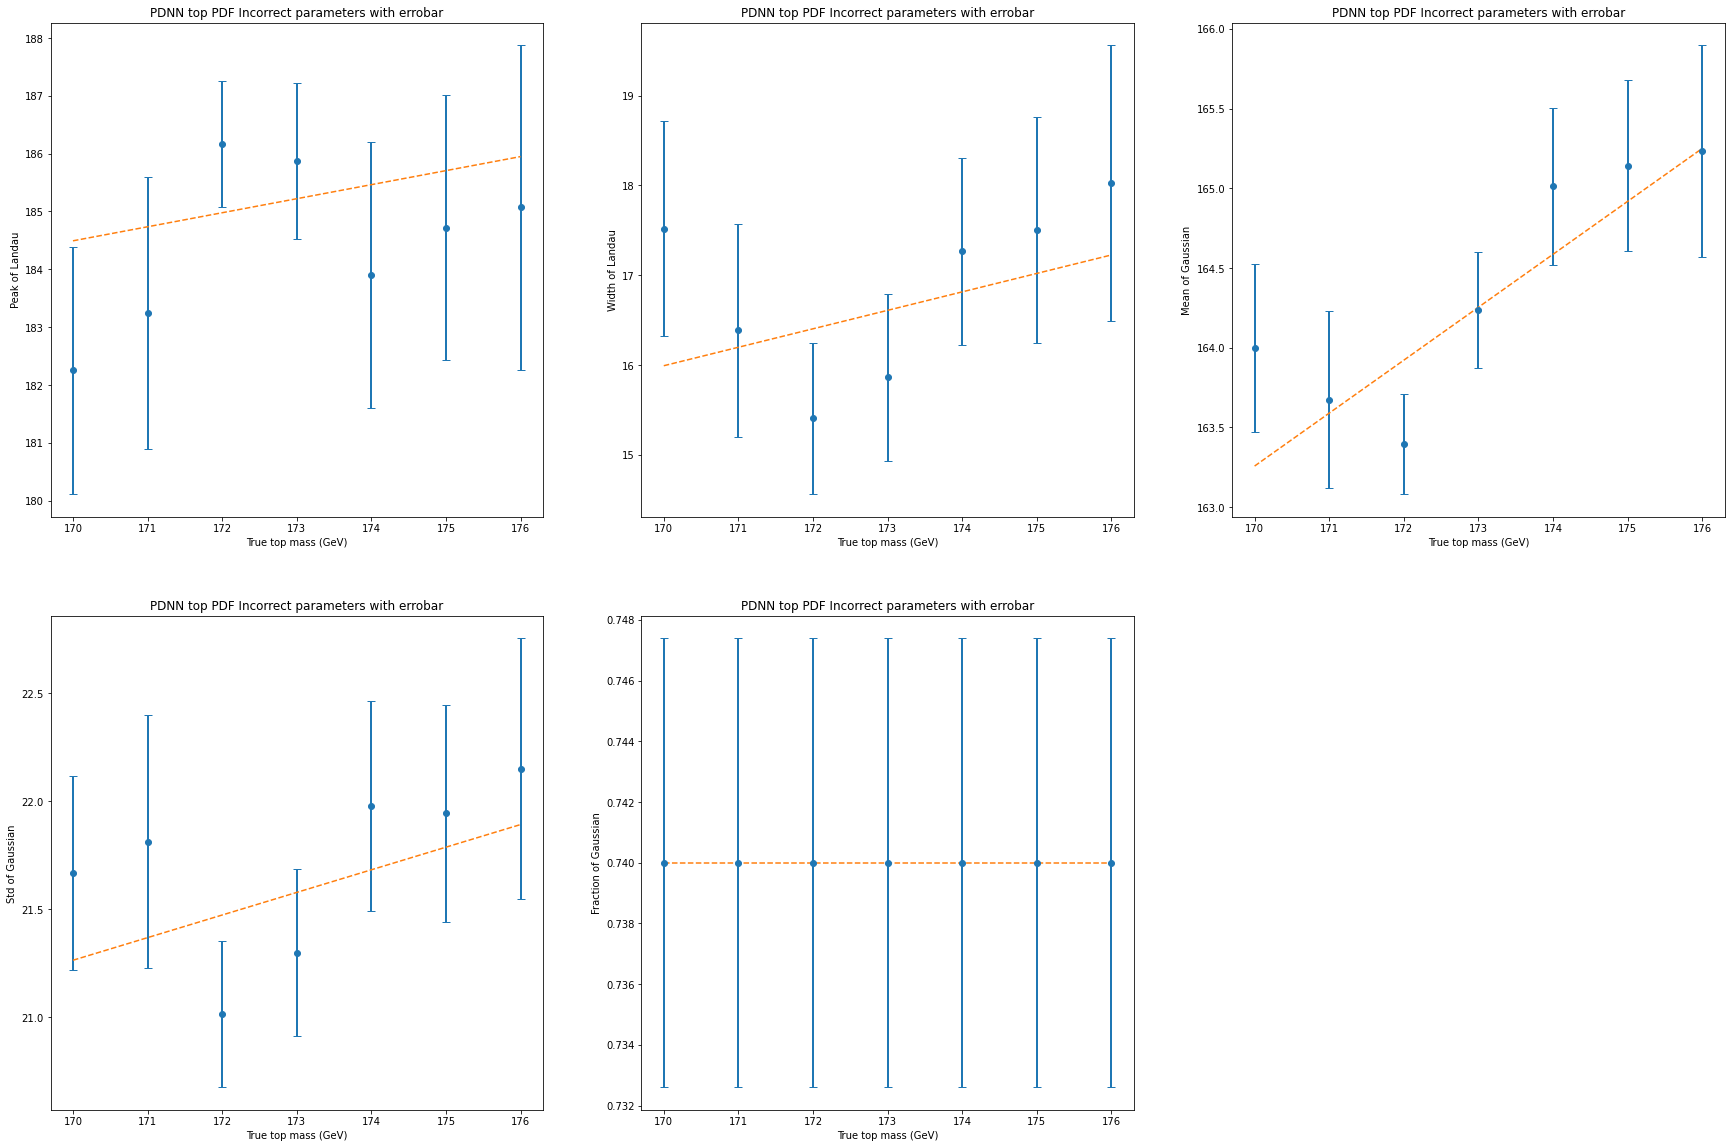

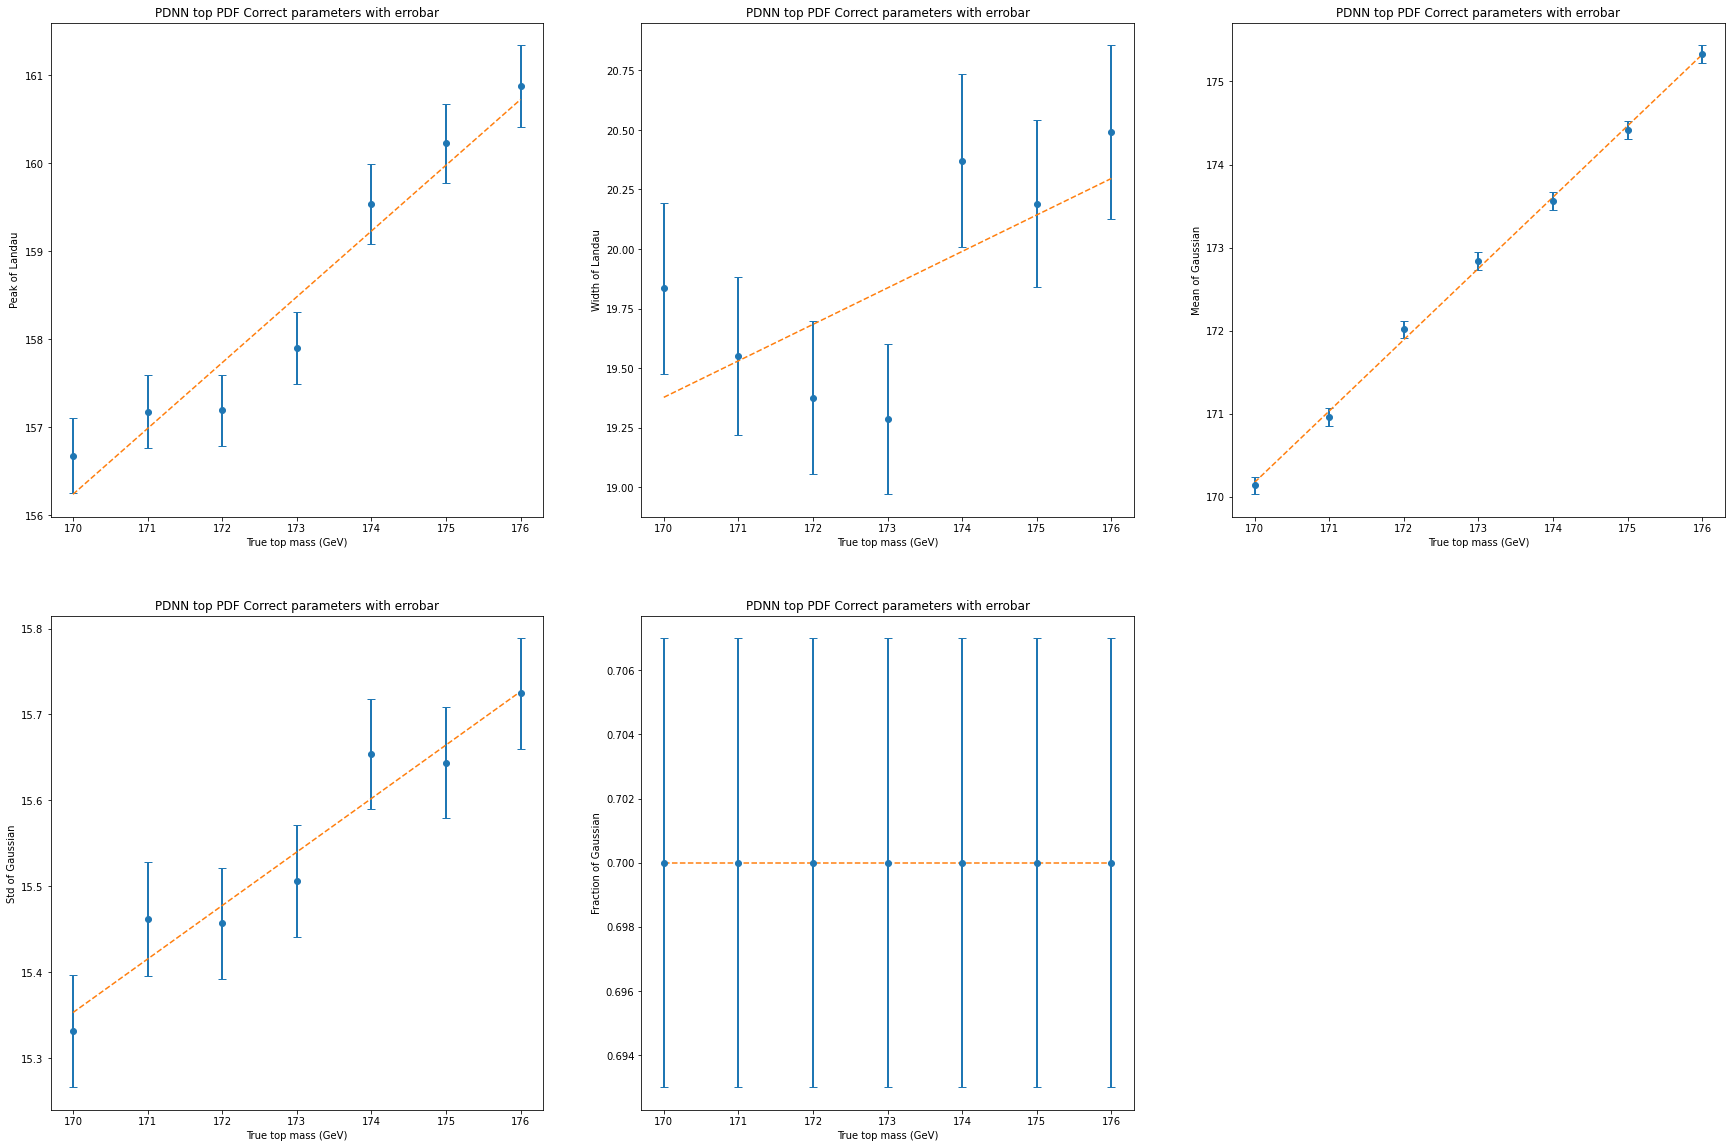

In [12]:
pdf_pdnn_top_dic = defaultdict(list)
for state_i in states:
    plt.figure(figsize=(30, 20))
    for i in range(5):
        plt.subplot(2, 3, i+1)
        popt, pcov = optimize.curve_fit(linear, np.transpose(list(fit_popt_dic[state_i].keys())), [fit_popt_dic[state_i][key][i] for key in fit_popt_dic[state_i]], sigma = [fit_perr_dic[state_i][key][i] for key in fit_popt_dic[state_i]], method="lm")
        pdf_pdnn_top_dic[(state_i, i)] = popt
        plt.errorbar(mass, [fit_popt_dic[state_i][m][i] for m in mass], yerr=[fit_perr_dic[state_i][m][i] for m in mass], fmt='o', elinewidth=2, capsize=4)
        plt.plot(top_mass_dense, linear(top_mass_dense, *popt), '--')
        plt.title(f'PDNN top PDF {state_labels[state_i]} parameters with errobar')
        plt.xlabel('True top mass (GeV)')
        plt.ylabel(langau_fit_labels[i])
    plt.savefig(f'plots_topmass/PDNN_param_fit/PDNN top {state_labels[state_i]} parameter fit.png', bbox_inches='tight')
    plt.show()


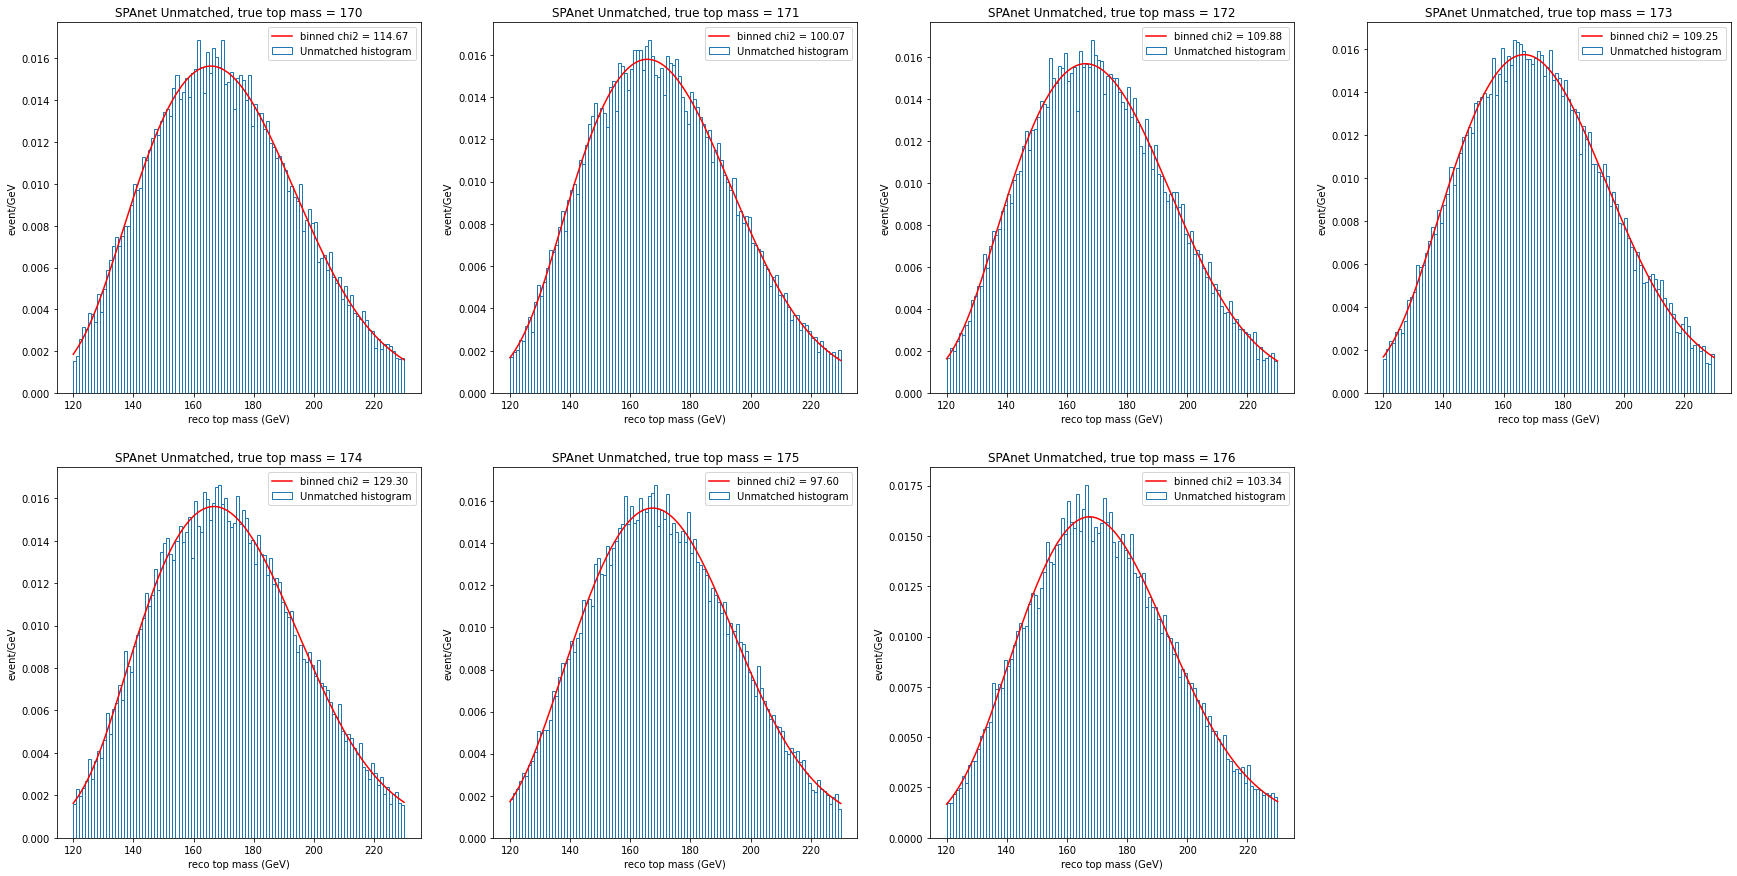

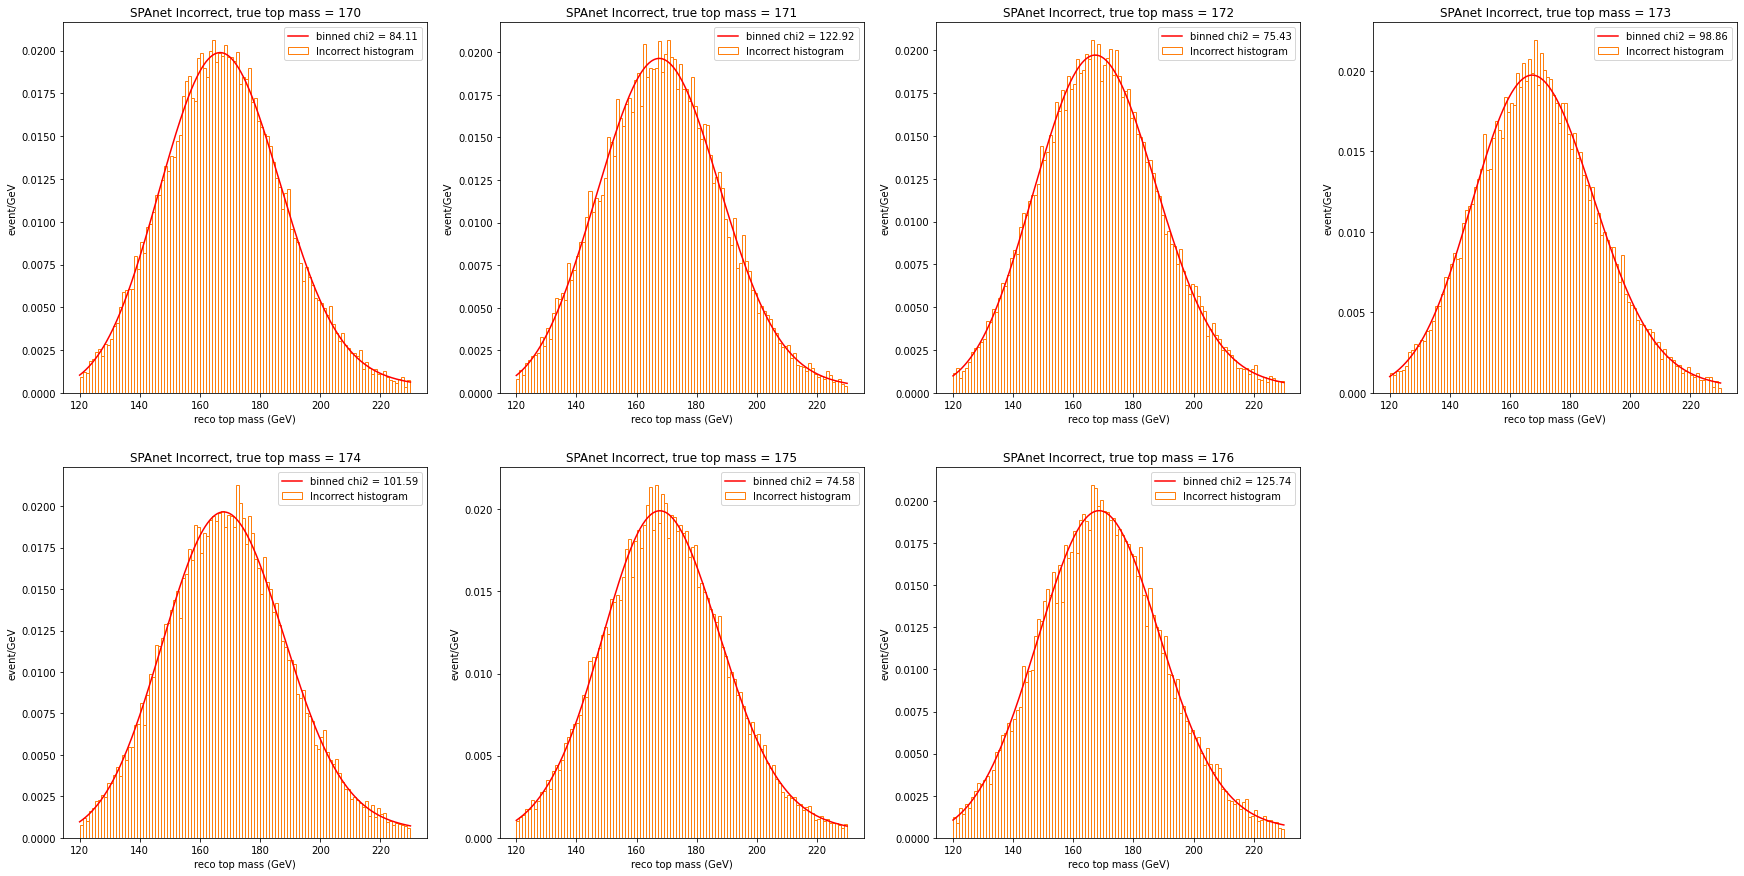

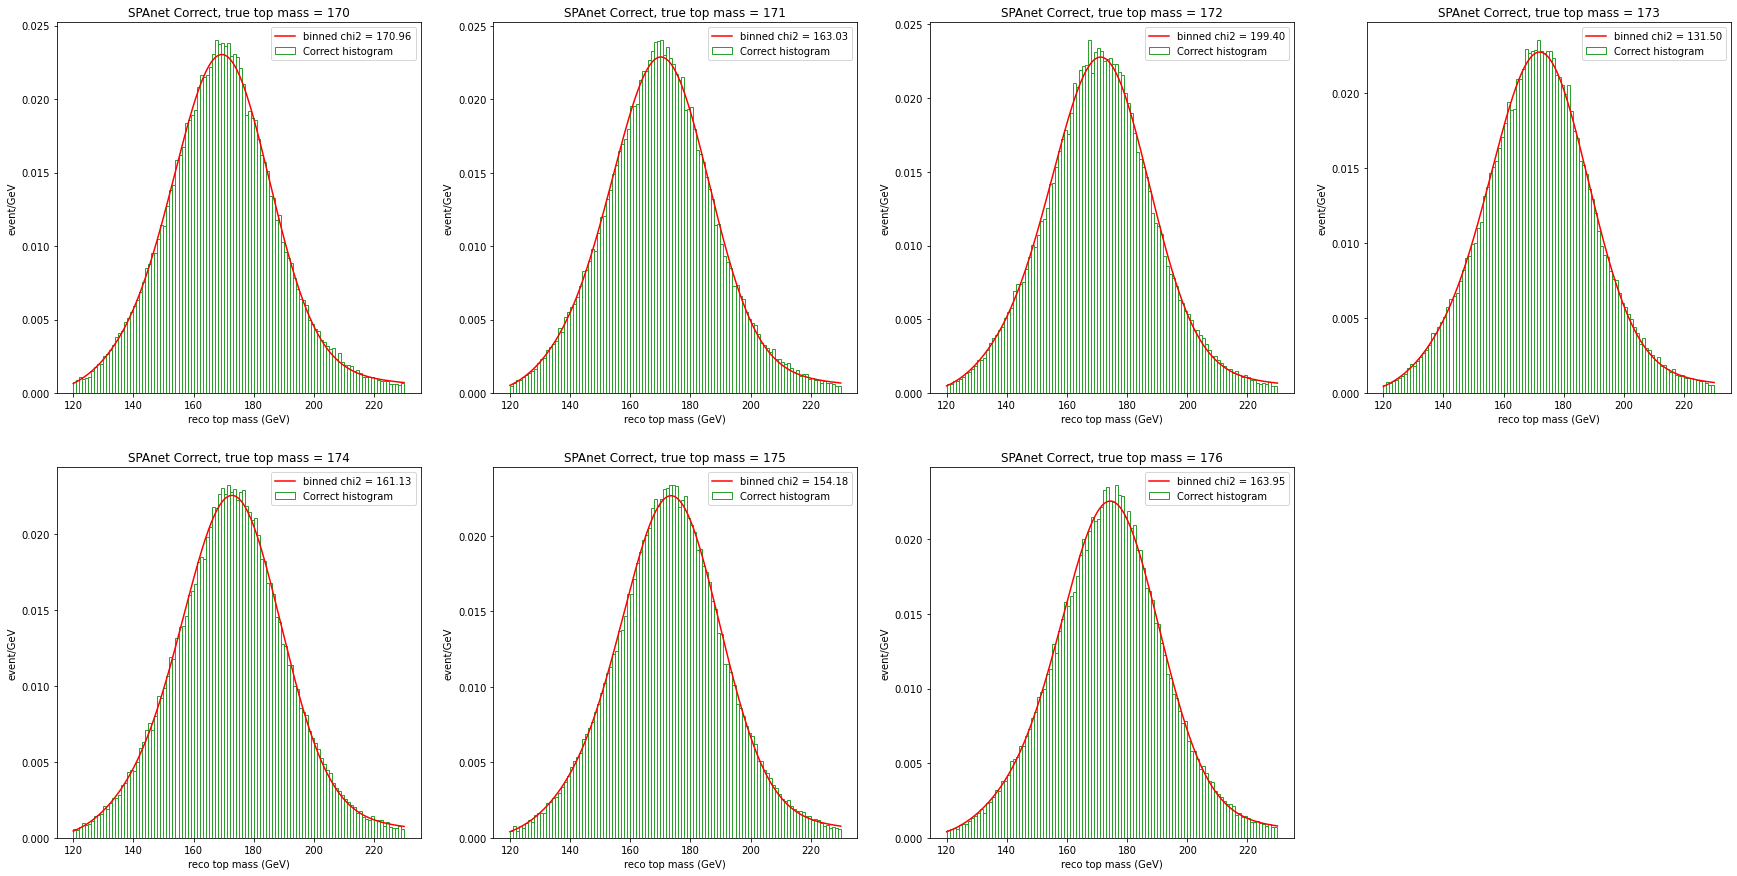

In [13]:
# Fit every class of SPAnet
fit_popt_dic = {i:{} for i in states}
fit_perr_dic = {i:{} for i in states}

for state_i in states:
    popt_spanet_arr = []
    perr_spanet_arr = []
    
    if state_i == 0: limits = [(100, 250), (5, 50), (100, 250), (5, 50), (0.64, 0.64)]
    elif state_i == 1: limits = [(100, 250), (5, 50), (100, 250), (5, 50), (0.85, 0.85)]
    else: limits = [(100, 250), (16, 20), (100, 250), (10, 17), (0.76, 0.76)]
    plt.figure(figsize=(30, 15))
    for i, m in enumerate(mass):
        plt.subplot(2, 4, i+1)
        fit_target = reco_spanet_dic[m][np.logical_and.reduce((cut_spanet_dic[m], likeli_spanet_dic[m], state_spanet_dic[m]==state_i))]
        hist, _ = np.histogram(fit_target, bins=bins, density=True)
        tot_event = len(fit_target)
        smallest_fcn = np.inf
        for _ in range(20):
            tol = 0.1
            start = [np.random.uniform(limits[i][0], limits[i][1]) for i in range(5)]
            while True:
                try:
                    minuit = Minuit(fcn, *start)
                    minuit.limits = limits
                    minuit.tol = tol
                    minuit.migrad()
                    minuit.minos()
                except: tol *= 2
                else: break
            if minuit.fval < smallest_fcn:
                smallest_fcn = minuit.fval
                popt, errors = list(minuit.values), list(minuit.errors)
        fit_popt_dic[state_i][m], fit_perr_dic[state_i][m] = popt, errors
        plt.plot(bins_dense, langau_norm(bins_dense, *popt), c='r', label=f'binned chi2 = {chi2_pdf(fit_target, langau_norm(bins_mid, *popt)):.2f}')
        plt.bar(bins_mid, hist, edgecolor=colors[state_i], width=bins_w, color='None', label = state_labels[state_i] + ' histogram')
        plt.title('SPAnet {}, true top mass = {}'.format(state_labels[state_i], m))
        plt.xlabel('reco top mass (GeV)')
        plt.ylabel('event/GeV')
        plt.legend(loc='upper right')
    plt.savefig(f'plots_topmass/SPAnet_pdf_fit/SPAnet top {state_labels[state_i]} fit.png', bbox_inches='tight')
    plt.show()

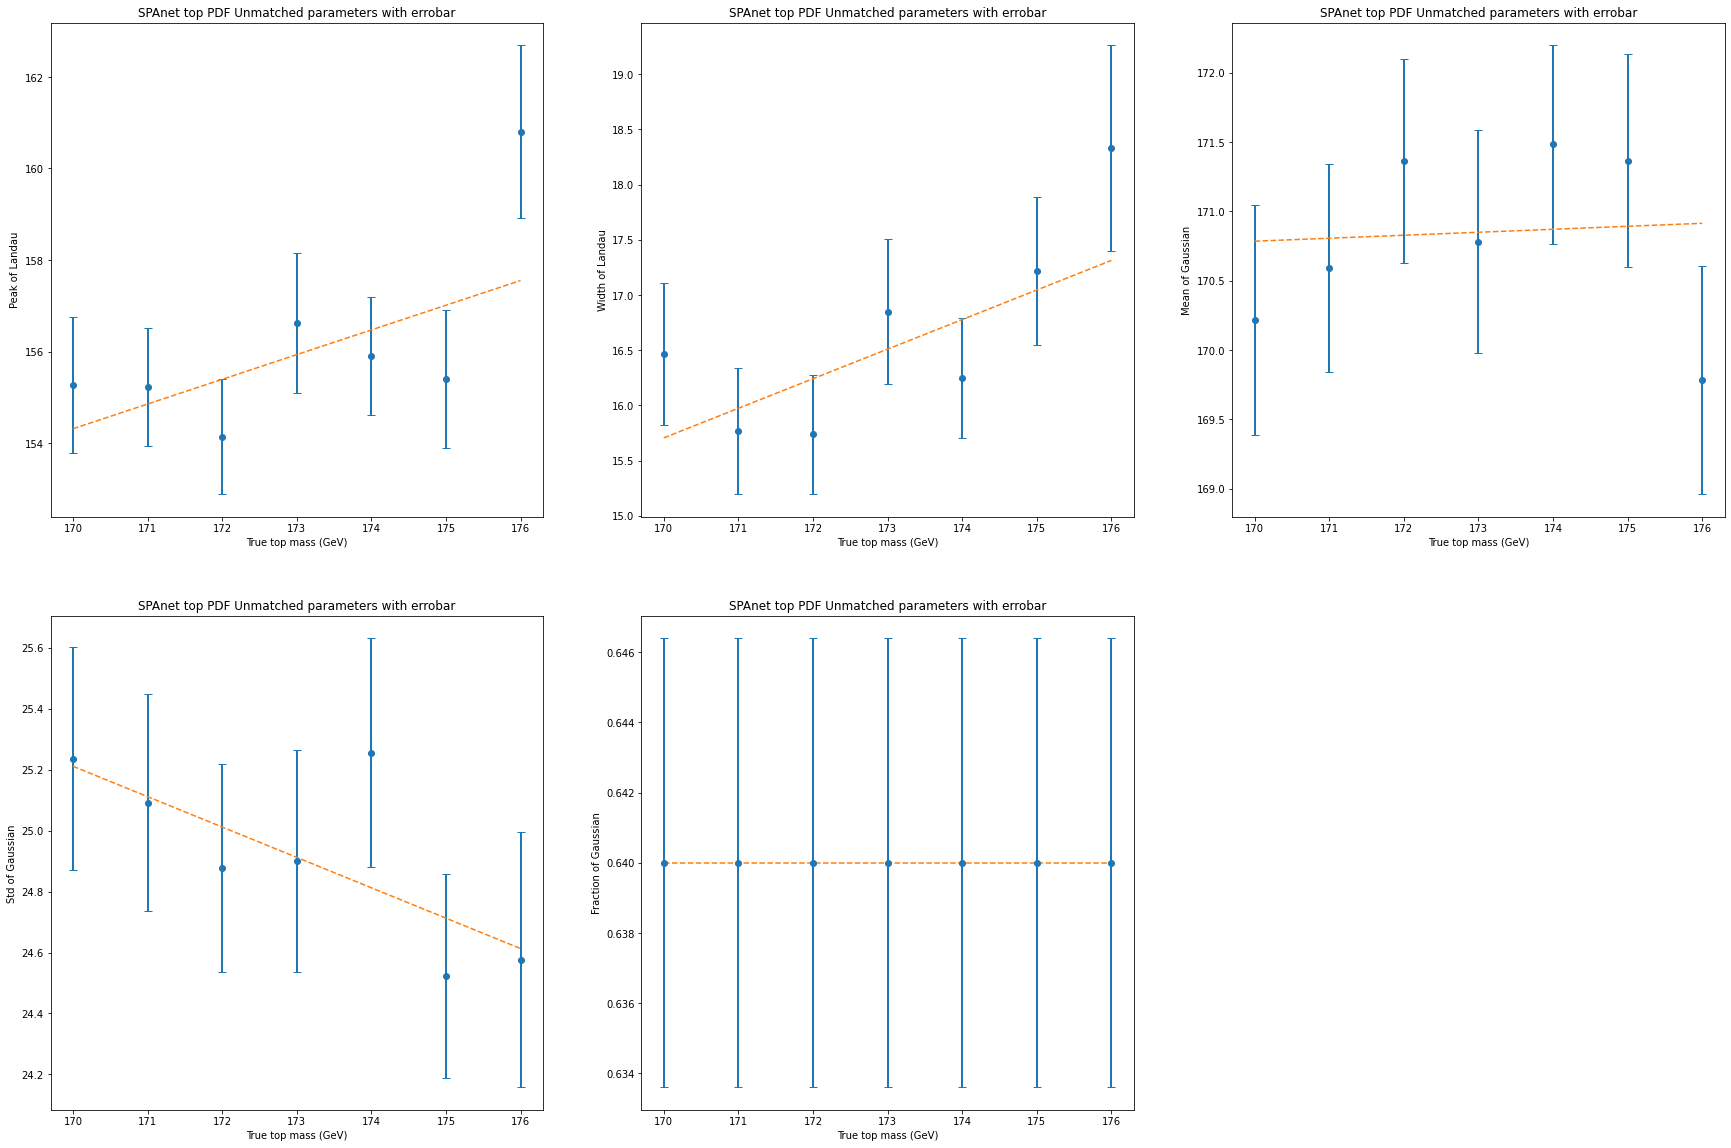

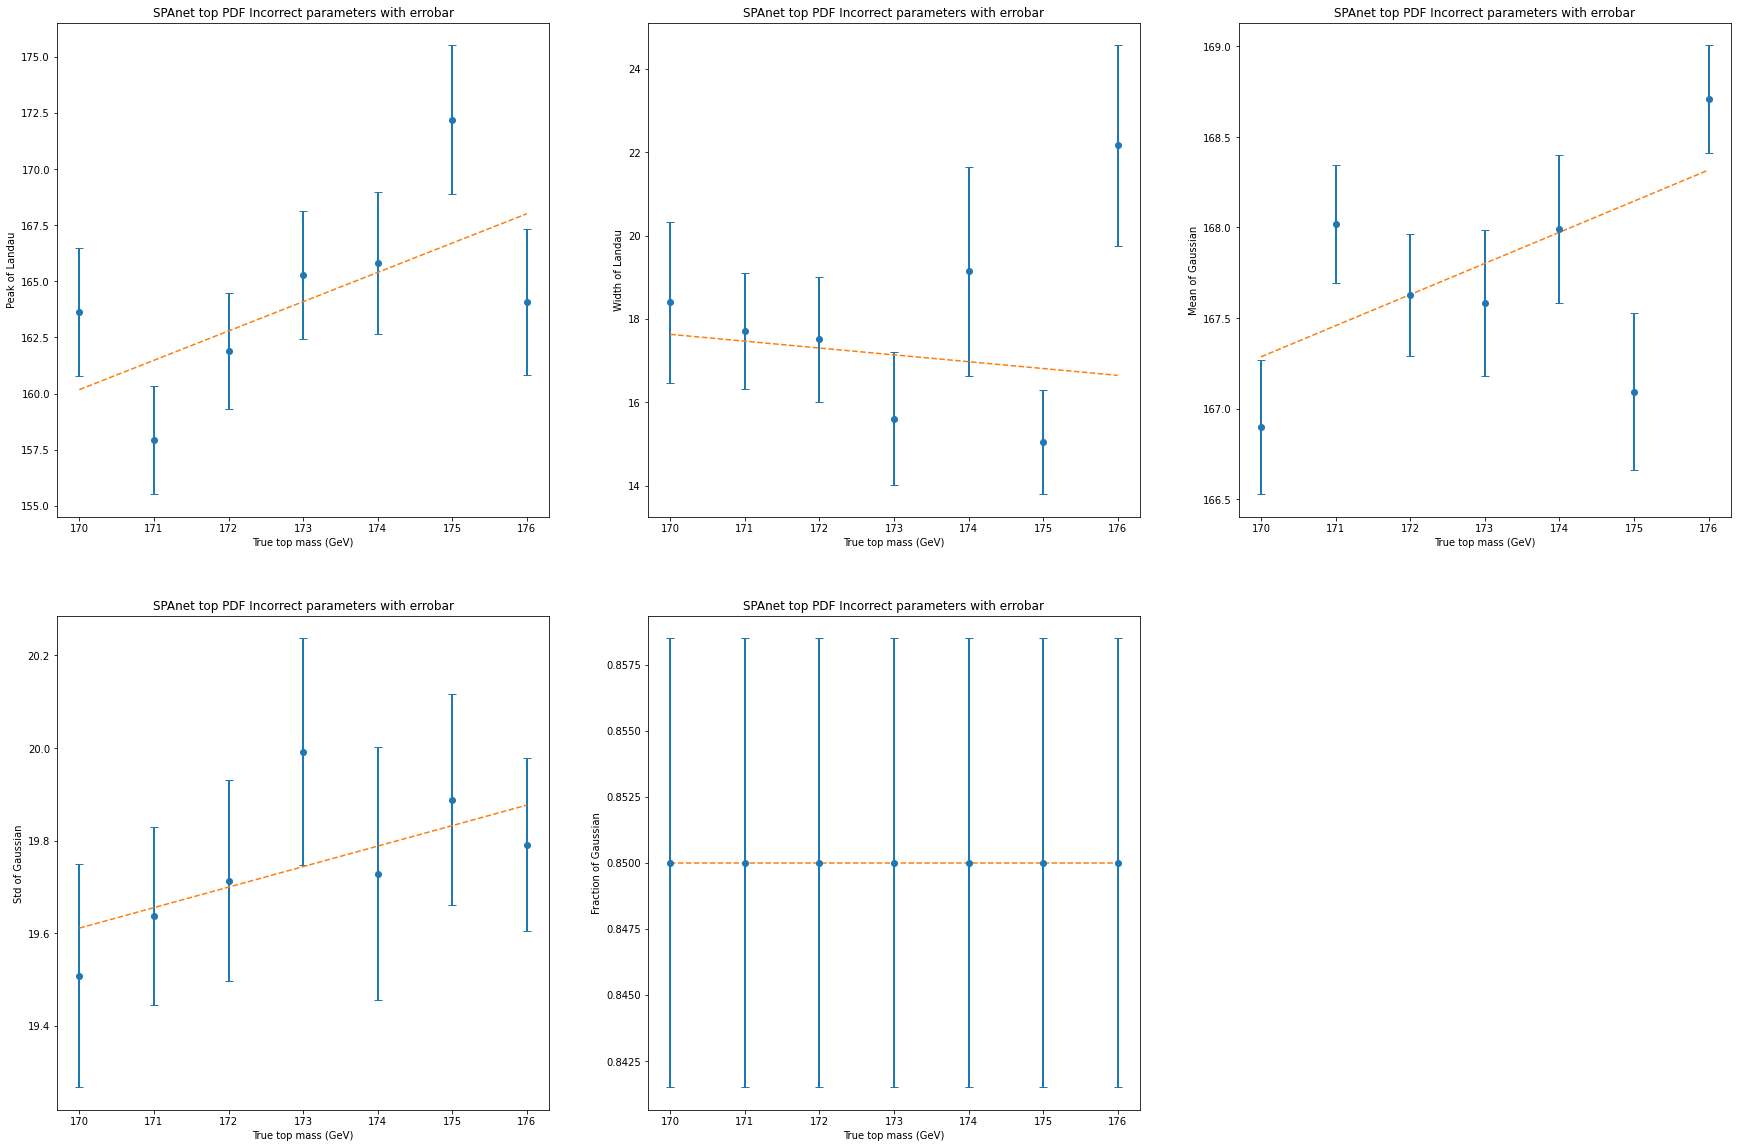

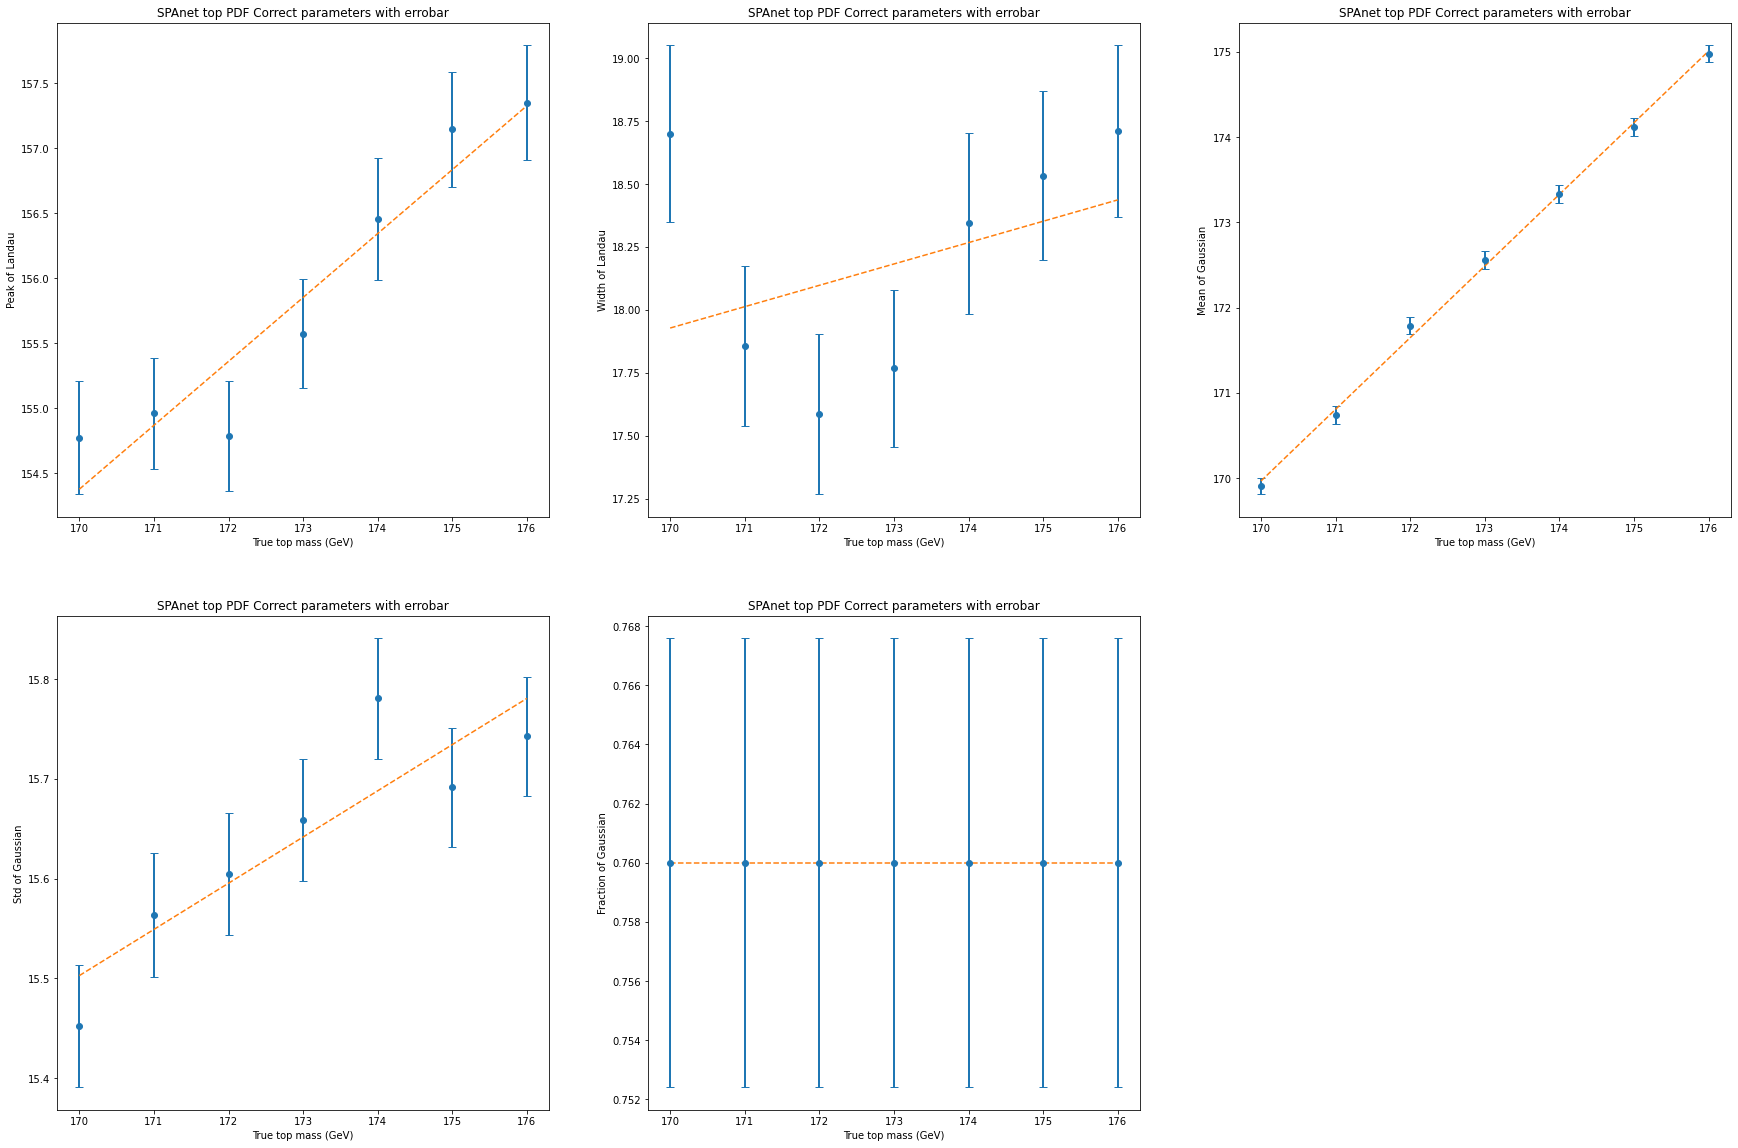

In [14]:
pdf_spanet_top_dic = defaultdict(list)
for state_i in states:
    plt.figure(figsize=(30, 20))
    for i in range(5):
        plt.subplot(2, 3, i+1)
        popt, pcov = optimize.curve_fit(linear, np.transpose(list(fit_popt_dic[state_i].keys())), [fit_popt_dic[state_i][key][i] for key in fit_popt_dic[state_i]], sigma = [fit_perr_dic[state_i][key][i] for key in fit_popt_dic[state_i]], method="lm")
        pdf_spanet_top_dic[(state_i, i)] = popt
        plt.errorbar(mass, [fit_popt_dic[state_i][m][i] for m in mass], yerr=[fit_perr_dic[state_i][m][i] for m in mass], fmt='o', elinewidth=2, capsize=4)
        plt.plot(top_mass_dense, linear(top_mass_dense, *popt), '--')
        plt.title(f'SPAnet top PDF {state_labels[state_i]} parameters with errobar')
        plt.xlabel('True top mass (GeV)')
        plt.ylabel(langau_fit_labels[i])
    plt.savefig(f'plots_topmass/SPAnet_param_fit/SPAnet top {state_labels[state_i]} parameter fit.png', bbox_inches='tight')
    plt.show()


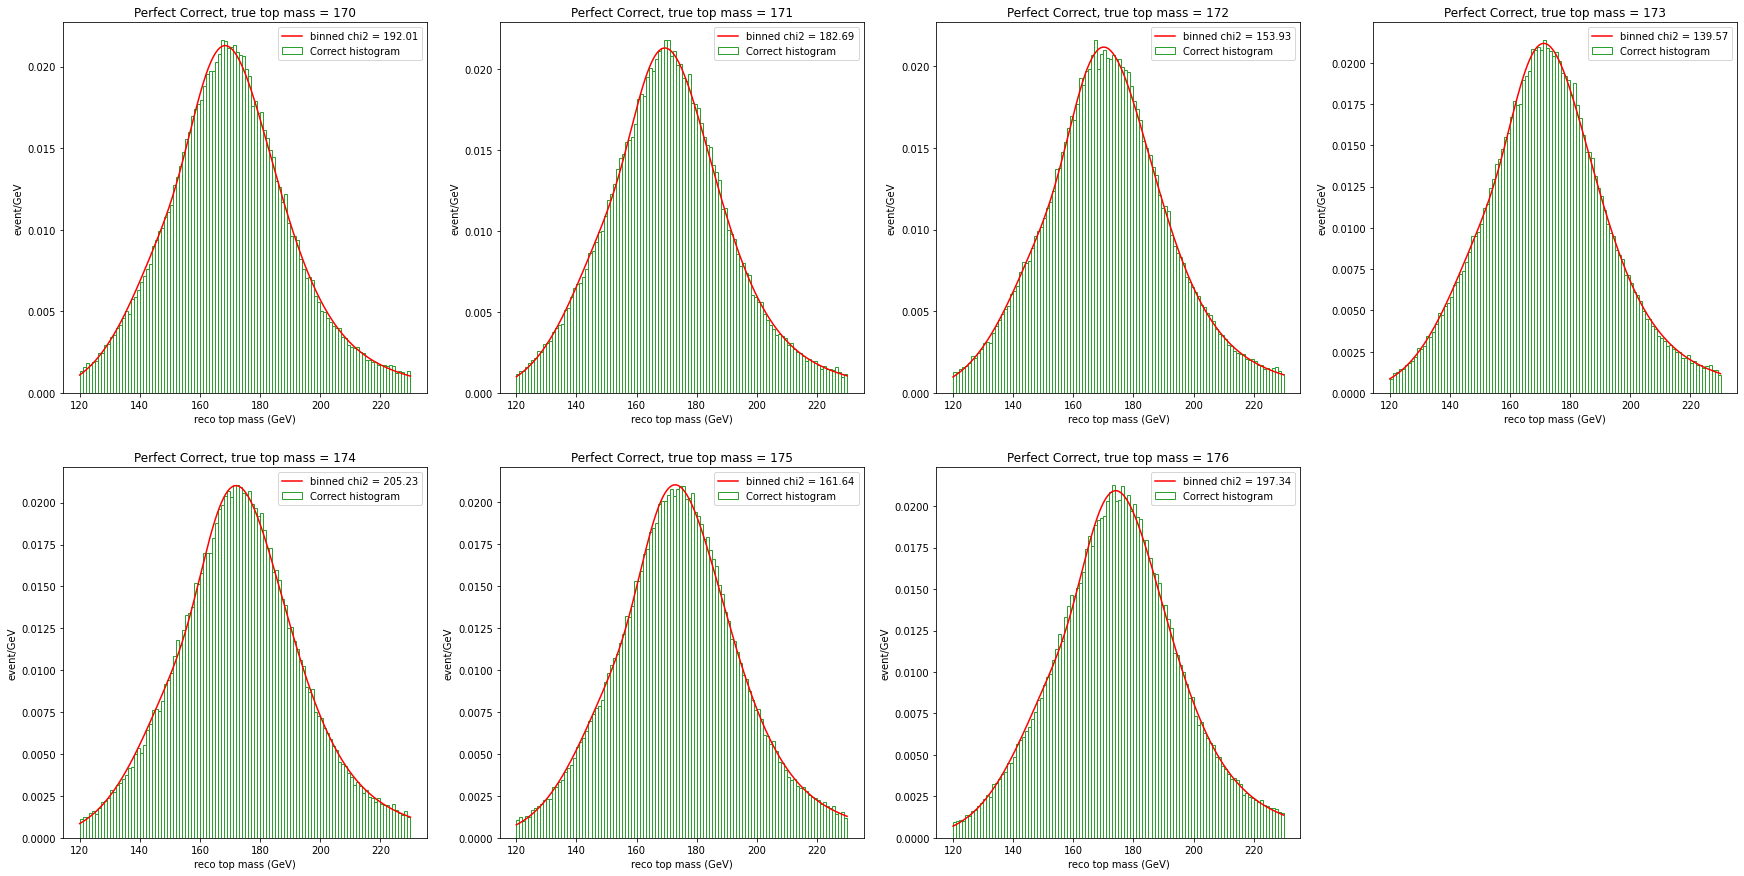

In [15]:
# Fit every class of Perfect
fit_popt_dic = {i:{} for i in states}
fit_perr_dic = {i:{} for i in states}

for state_i in [2]:
    popt_perfect_arr = []
    perr_perfect_arr = []
    
    limits = [(170, 250), (5, 50), (100, 250), (5, 50), (0.61, 0.61)]
    plt.figure(figsize=(30, 15))
    for i, m in enumerate(mass):
        plt.subplot(2, 4, i+1)
        fit_target = reco_perfect_dic[m][np.logical_and.reduce((cut_perfect_dic[m], state_perfect_dic[m]==state_i))]
        hist, _ = np.histogram(fit_target, bins=bins, density=True)
        tot_event = len(fit_target)
        smallest_fcn = np.inf
        for _ in range(10):
            tol = 0.1
            start = [np.random.uniform(limits[i][0], limits[i][1]) for i in range(5)]
            while True:
                try:
                    minuit = Minuit(fcn, *start)
                    minuit.limits = limits
                    minuit.tol = tol
                    minuit.migrad()
                    minuit.minos()
                except: tol *= 2
                else: break
            if minuit.fval < smallest_fcn:
                smallest_fcn = minuit.fval
                popt, errors = list(minuit.values), list(minuit.errors)
        fit_popt_dic[state_i][m], fit_perr_dic[state_i][m] = popt, errors
        plt.plot(bins_dense, langau_norm(bins_dense, *popt), c='r', label=f'binned chi2 = {chi2_pdf(fit_target, langau_norm(bins_mid, *popt)):.2f}')
        plt.bar(bins_mid, hist, edgecolor=colors[state_i], width=bins_w, color='None', label = state_labels[state_i] + ' histogram')
        plt.title('Perfect {}, true top mass = {}'.format(state_labels[state_i], m))
        plt.xlabel('reco top mass (GeV)')
        plt.ylabel('event/GeV')
        plt.legend(loc='upper right')
    plt.savefig(f'plots_topmass/Perfect_pdf_fit/Perfect top {state_labels[state_i]} fit.png', bbox_inches='tight')
    plt.show()

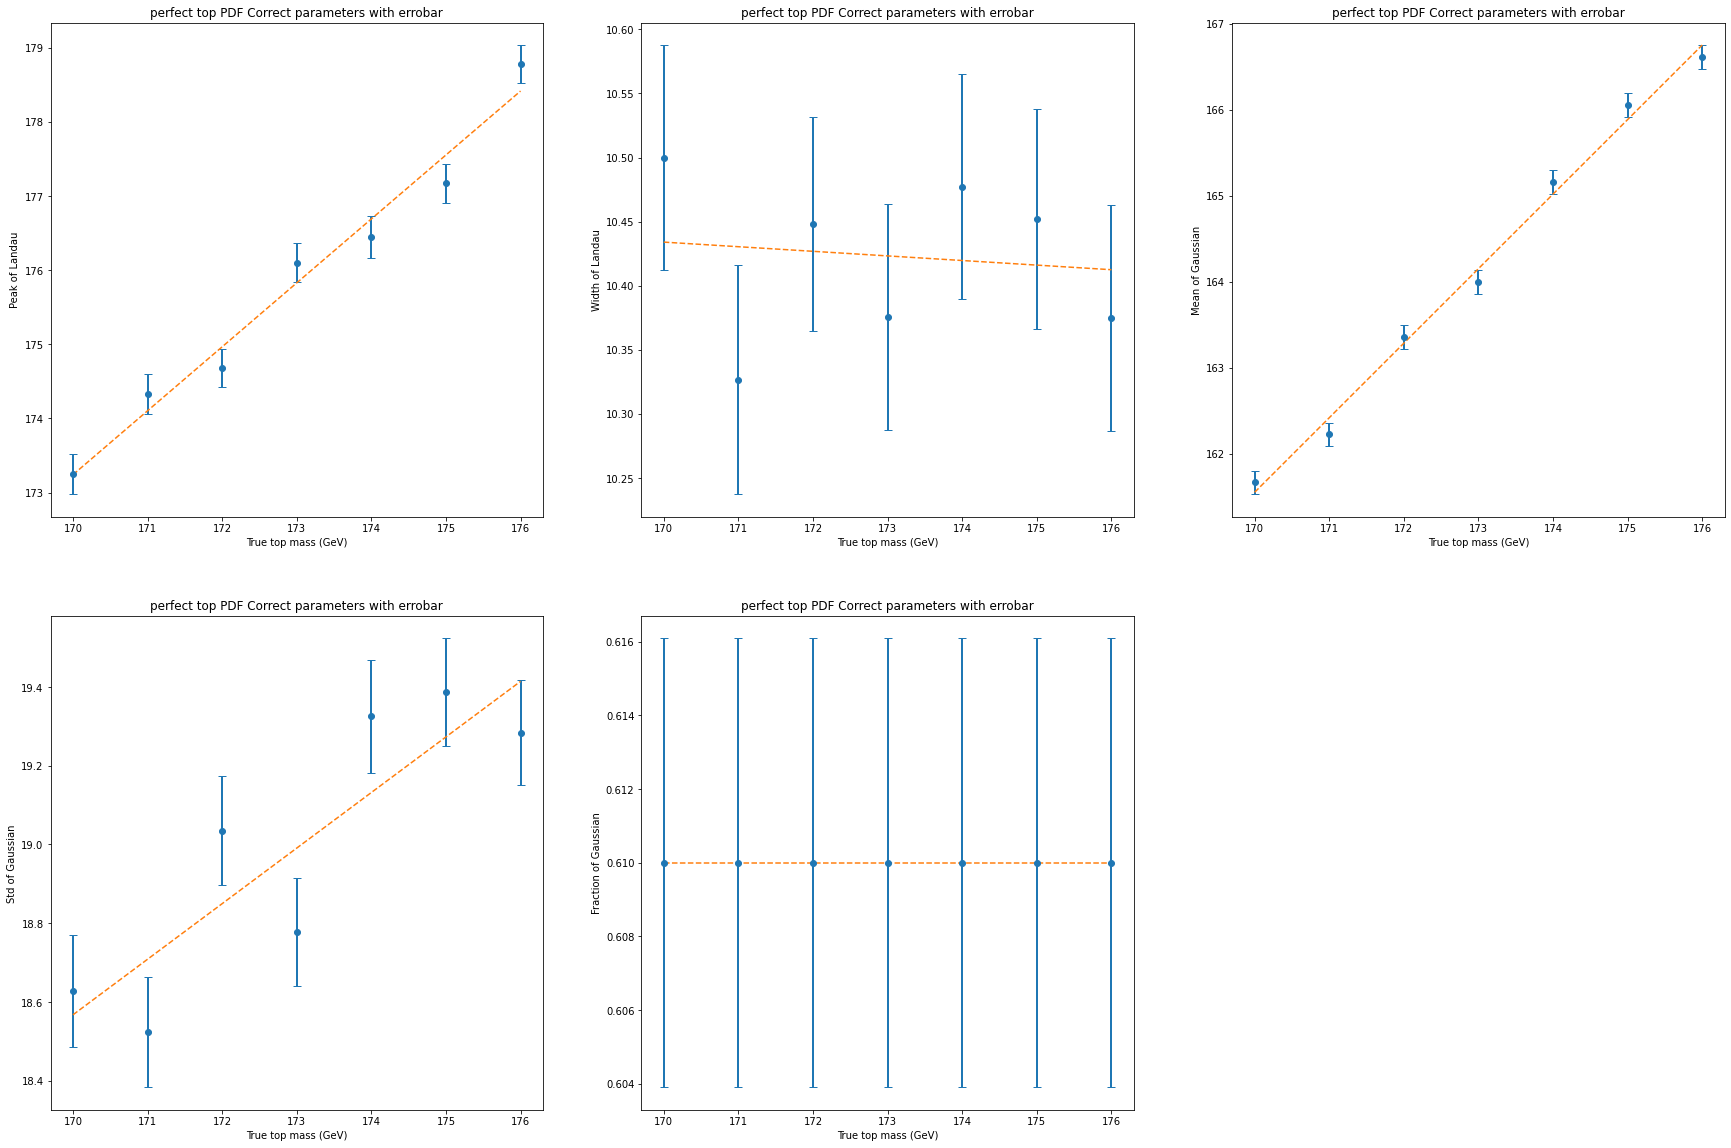

In [16]:
pdf_perfect_top_dic = defaultdict(list)
for state_i in [2]:
    plt.figure(figsize=(30, 20))
    for i in range(5):
        plt.subplot(2, 3, i+1)
        popt, pcov = optimize.curve_fit(linear, np.transpose(list(fit_popt_dic[state_i].keys())), [fit_popt_dic[state_i][key][i] for key in fit_popt_dic[state_i]], sigma = [fit_perr_dic[state_i][key][i] for key in fit_popt_dic[state_i]], method="lm")
        pdf_perfect_top_dic[(state_i, i)] = popt
        plt.errorbar(mass, [fit_popt_dic[state_i][m][i] for m in mass], yerr=[fit_perr_dic[state_i][m][i] for m in mass], fmt='o', elinewidth=2, capsize=4)
        plt.plot(top_mass_dense, linear(top_mass_dense, *popt), '--')
        plt.title(f'perfect top PDF {state_labels[state_i]} parameters with errobar')
        plt.xlabel('True top mass (GeV)')
        plt.ylabel(langau_fit_labels[i])
    plt.savefig(f'plots_topmass/Perfect_param_fit/perfect top {state_labels[state_i]} parameter fit.png', bbox_inches='tight')
    plt.show()


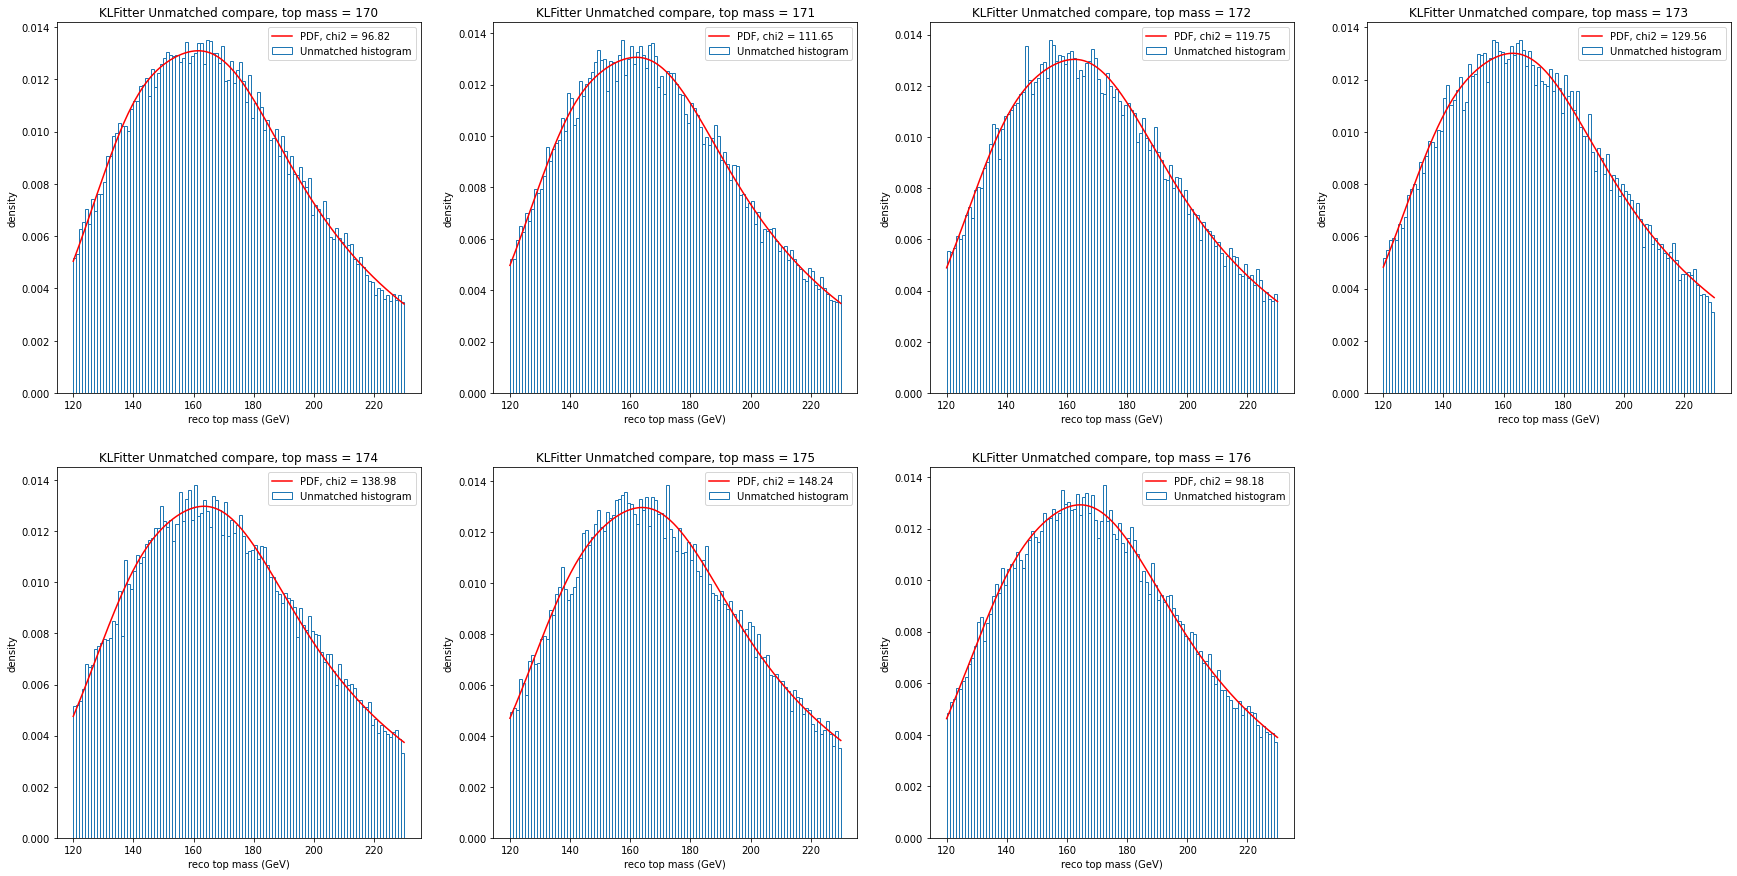

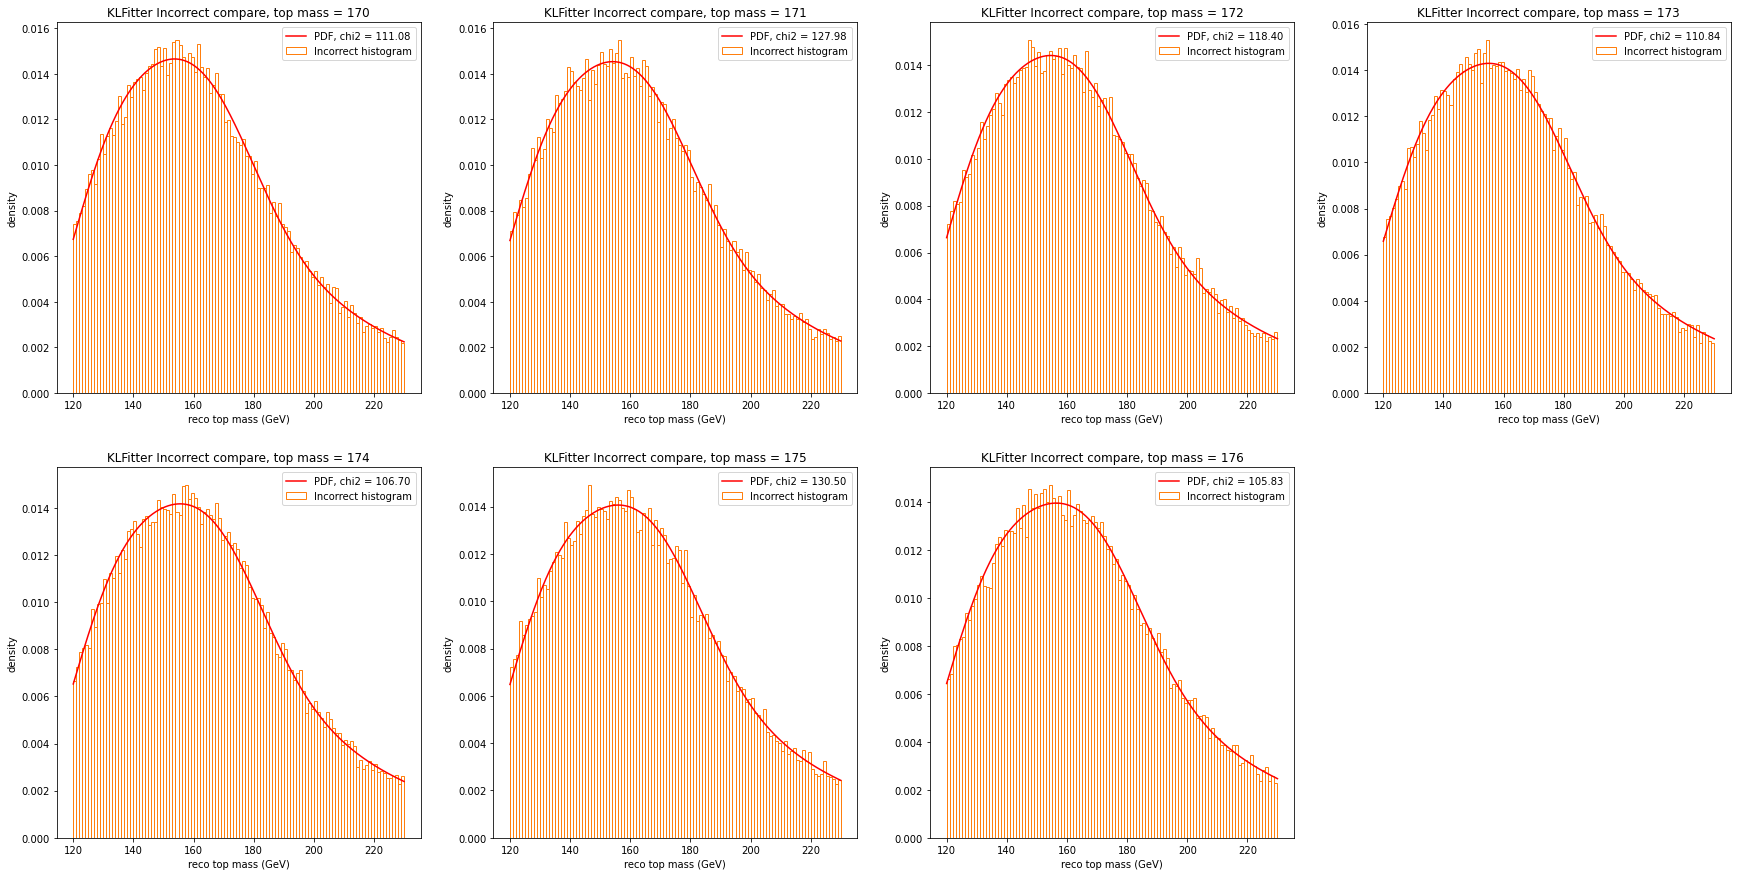

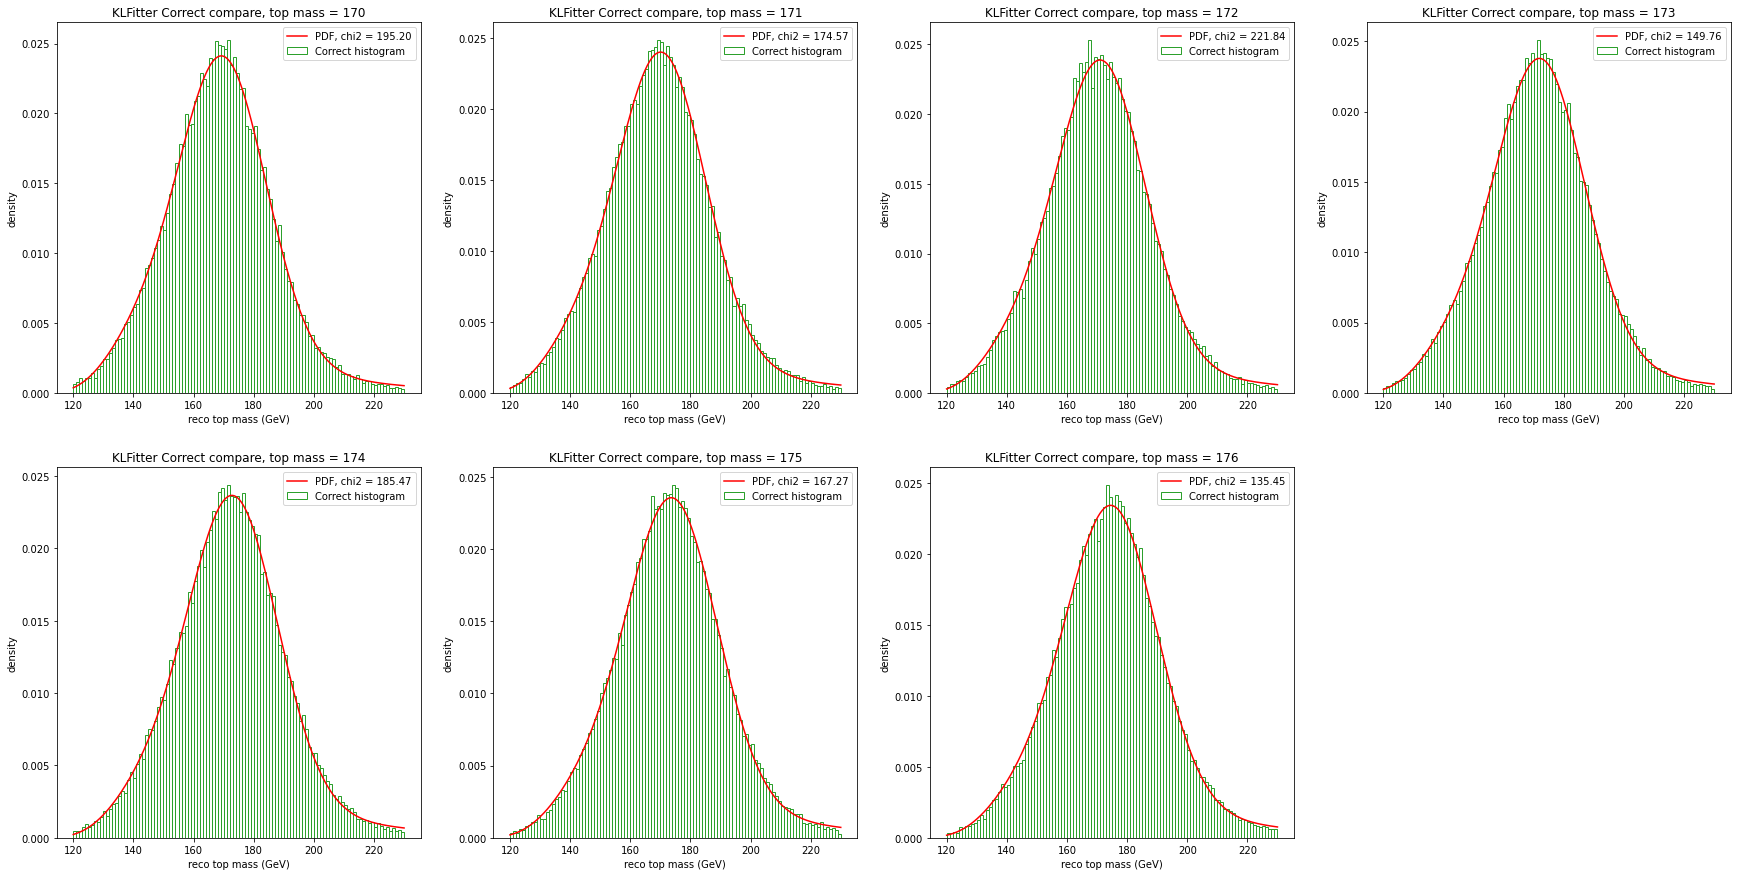

In [17]:
# Compare the KLFitter template histogram and the pdf
for state_i in states:
    plt.figure(figsize=(30,15))
    for i, m in enumerate(mass):
        plt.subplot(2, 4, i+1)
        target = reco_klf_dic[m][np.logical_and.reduce((cut_klf_dic[m], likeli_klf_dic[m], state_klf_dic[m] == state_i))]
        hist, _ = np.histogram(target, bins=bins, density=True)
        popt = [linear(m, *pdf_klf_top_dic[(state_i, j)]) for j in range(5)]
        y_template_dense_norm = langau_norm(bins_dense, *popt)
        chi2_pdf_value = chi2_pdf(target, langau_norm(bins_mid, *popt))
        plt.bar(bins_mid, hist, edgecolor=colors[state_i], width=bins_w, color='None', label = state_labels[state_i] + ' histogram')
        plt.plot(bins_dense, y_template_dense_norm, c='r', label='PDF, chi2 = {:.2f}'.format(chi2_pdf_value))
        plt.title('KLFitter {} compare, top mass = {}'.format(state_labels[state_i], m))
        plt.xlabel('reco top mass (GeV)')
        plt.ylabel('density')
        plt.legend(loc='upper right')
    plt.savefig(f'plots_topmass/KLFitter_pdf_compare/KLFitter top {state_labels[state_i]} pdf compare.png', bbox_inches='tight')
    plt.show()

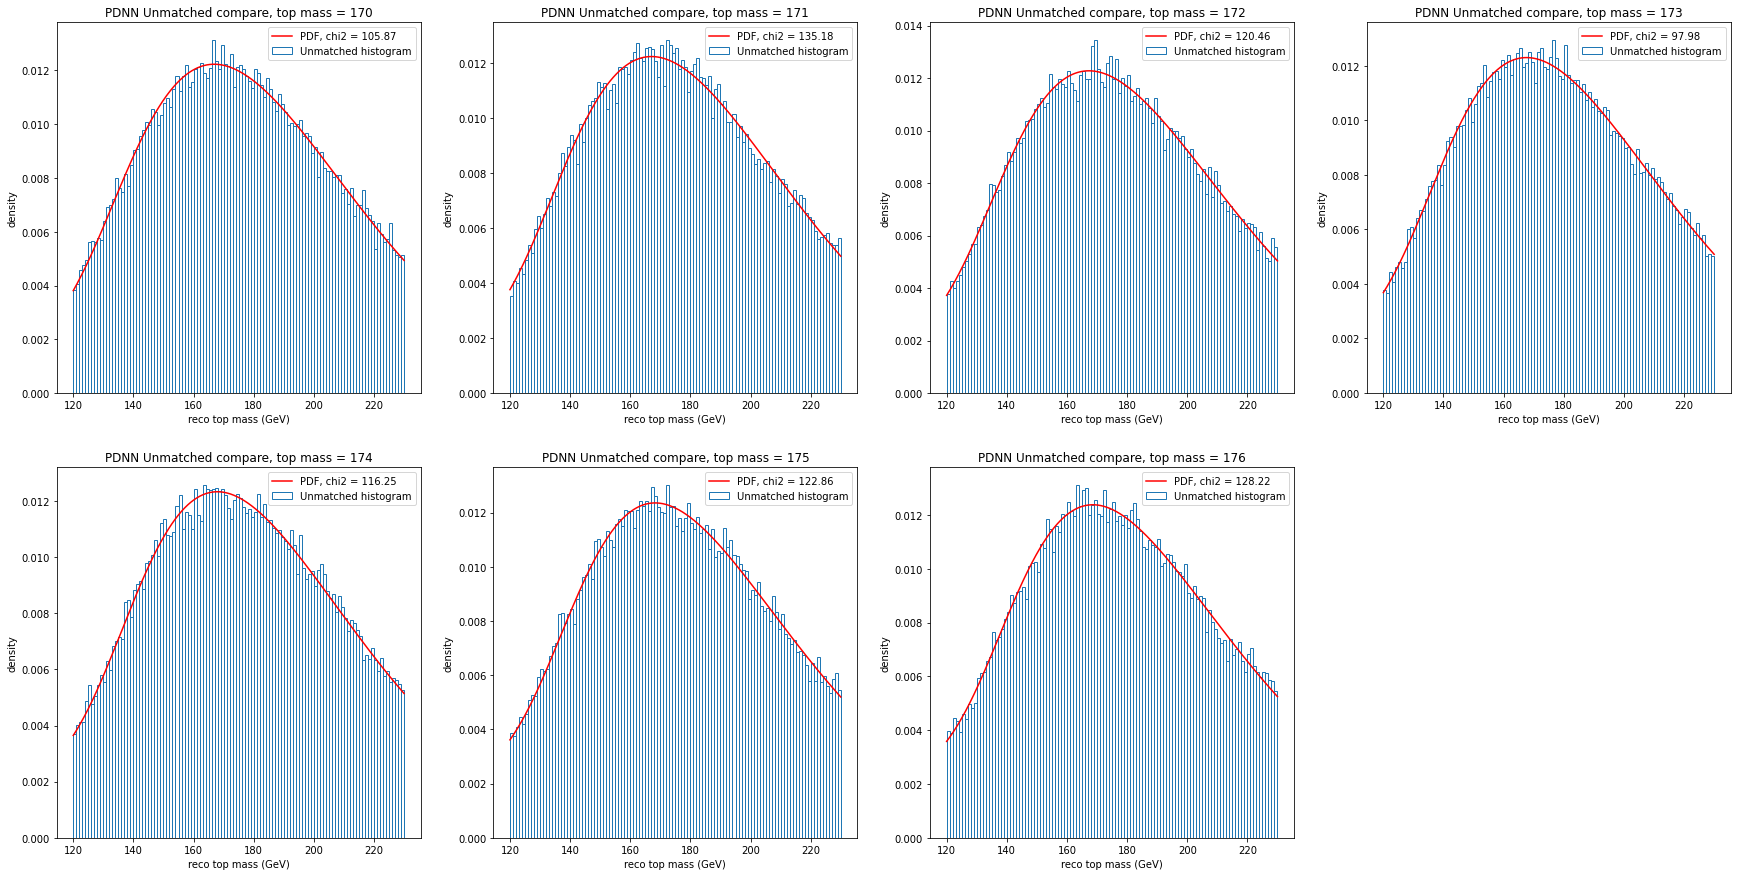

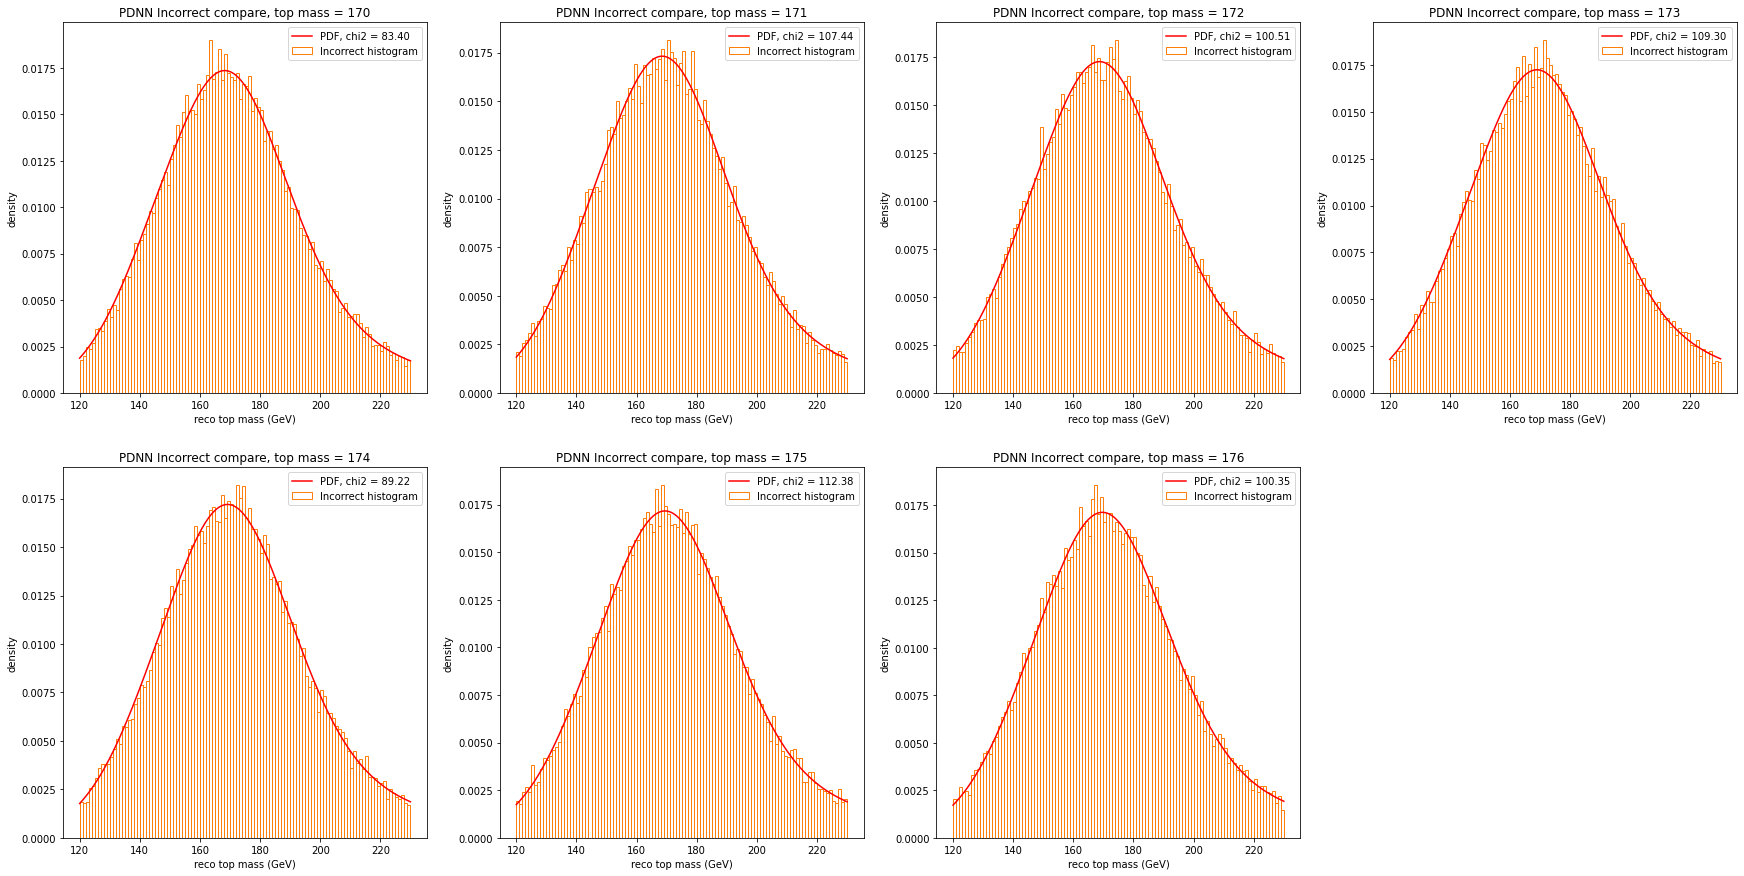

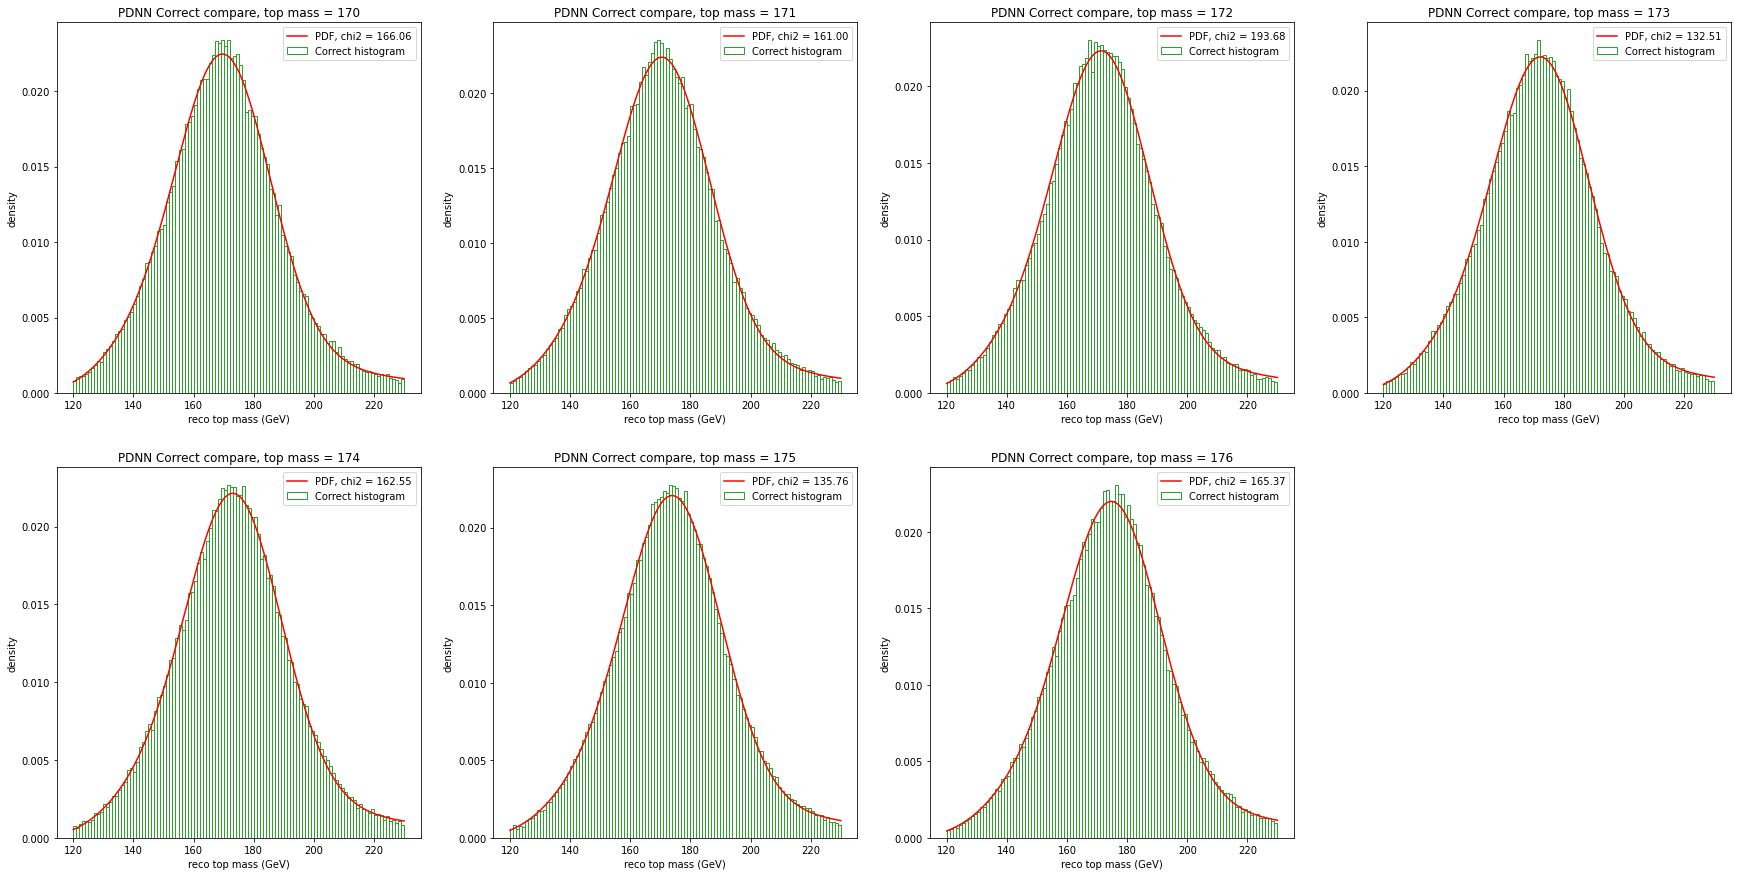

In [18]:
# Compare the PDNN template histogram and the pdf
for state_i in states:
    plt.figure(figsize=(30,15))
    for i, m in enumerate(mass):
        plt.subplot(2, 4, i+1)
        target = reco_pdnn_dic[m][np.logical_and.reduce((cut_pdnn_dic[m], likeli_pdnn_dic[m], state_pdnn_dic[m] == state_i))]
        hist, _ = np.histogram(target, bins=bins, density=True)
        popt = [linear(m, *pdf_pdnn_top_dic[(state_i, j)]) for j in range(5)]
        y_template_dense_norm = langau_norm(bins_dense, *popt)
        chi2_pdf_value = chi2_pdf(target, langau_norm(bins_mid, *popt))
        plt.bar(bins_mid, hist, edgecolor=colors[state_i], width=bins_w, color='None', label = state_labels[state_i] + ' histogram')
        plt.plot(bins_dense, y_template_dense_norm, c='r', label='PDF, chi2 = {:.2f}'.format(chi2_pdf_value))
        plt.title('PDNN {} compare, top mass = {}'.format(state_labels[state_i], m))
        plt.xlabel('reco top mass (GeV)')
        plt.ylabel('density')
        plt.legend(loc='upper right')
    plt.savefig(f'plots_topmass/PDNN_pdf_compare/PDNN top {state_labels[state_i]} pdf compare.png', bbox_inches='tight')
    plt.show()

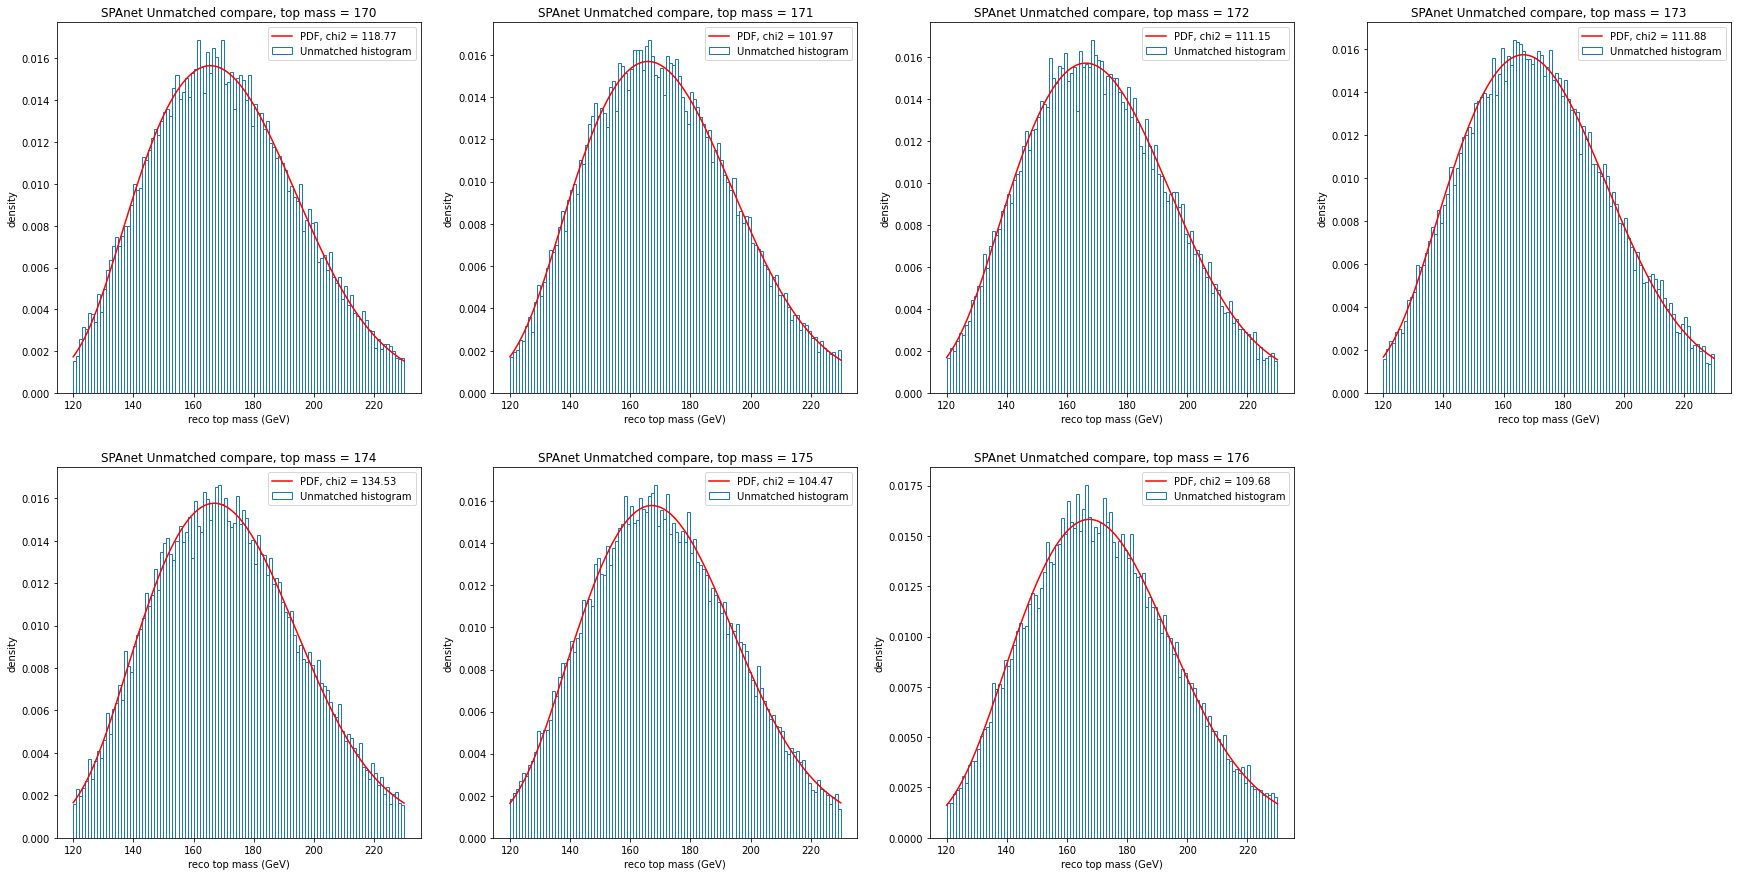

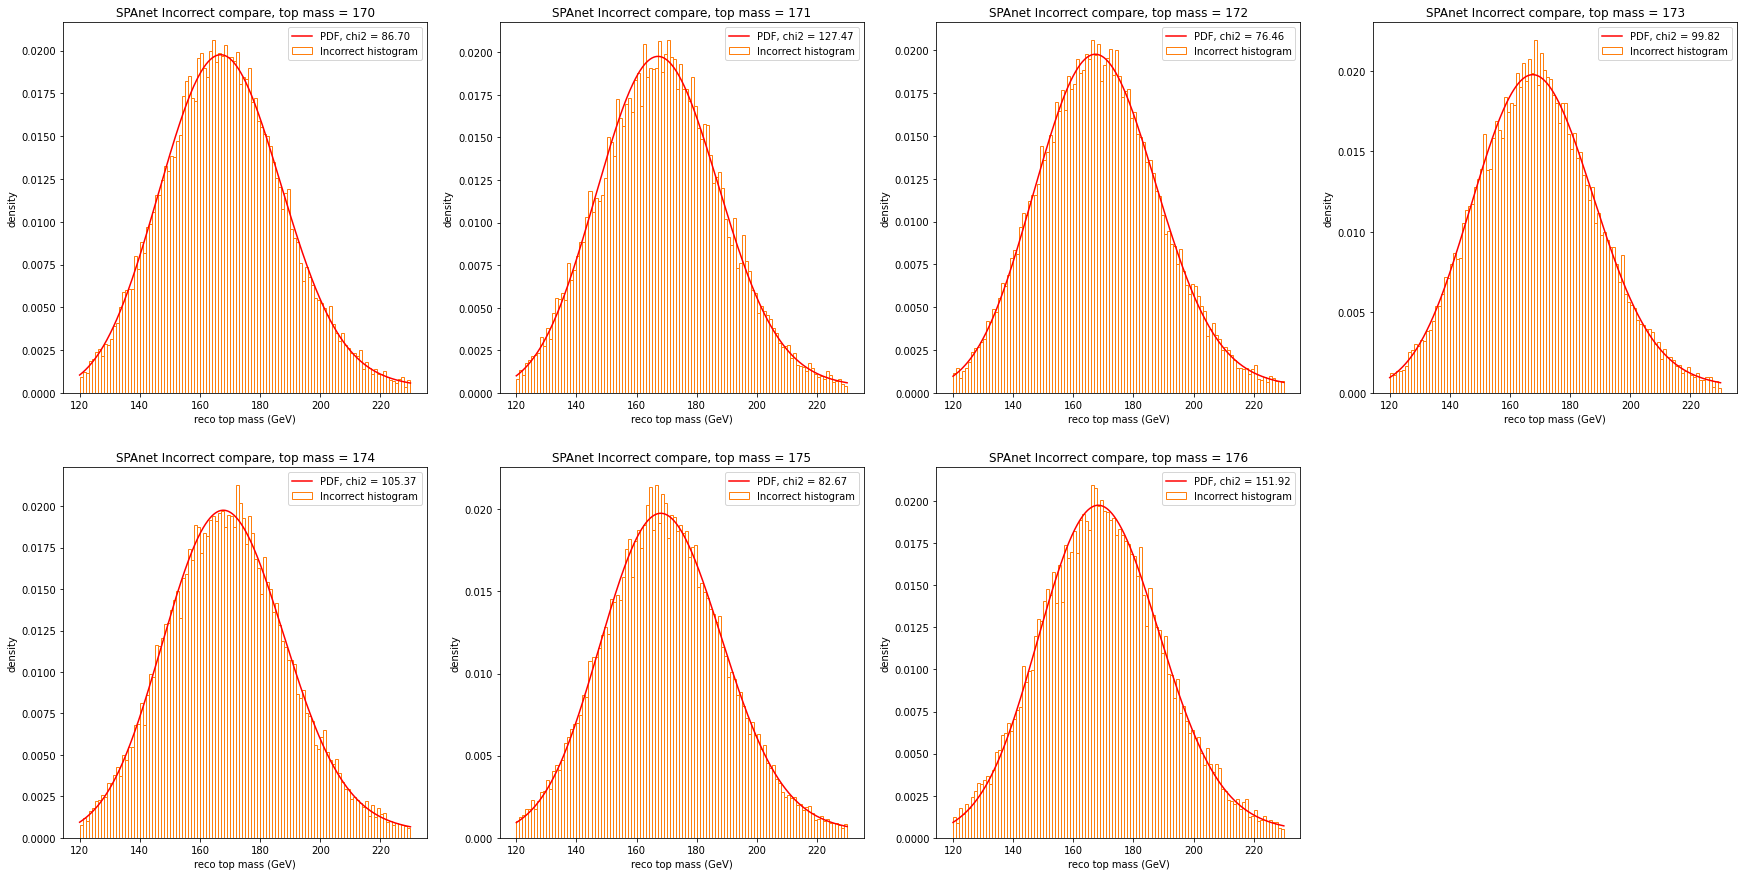

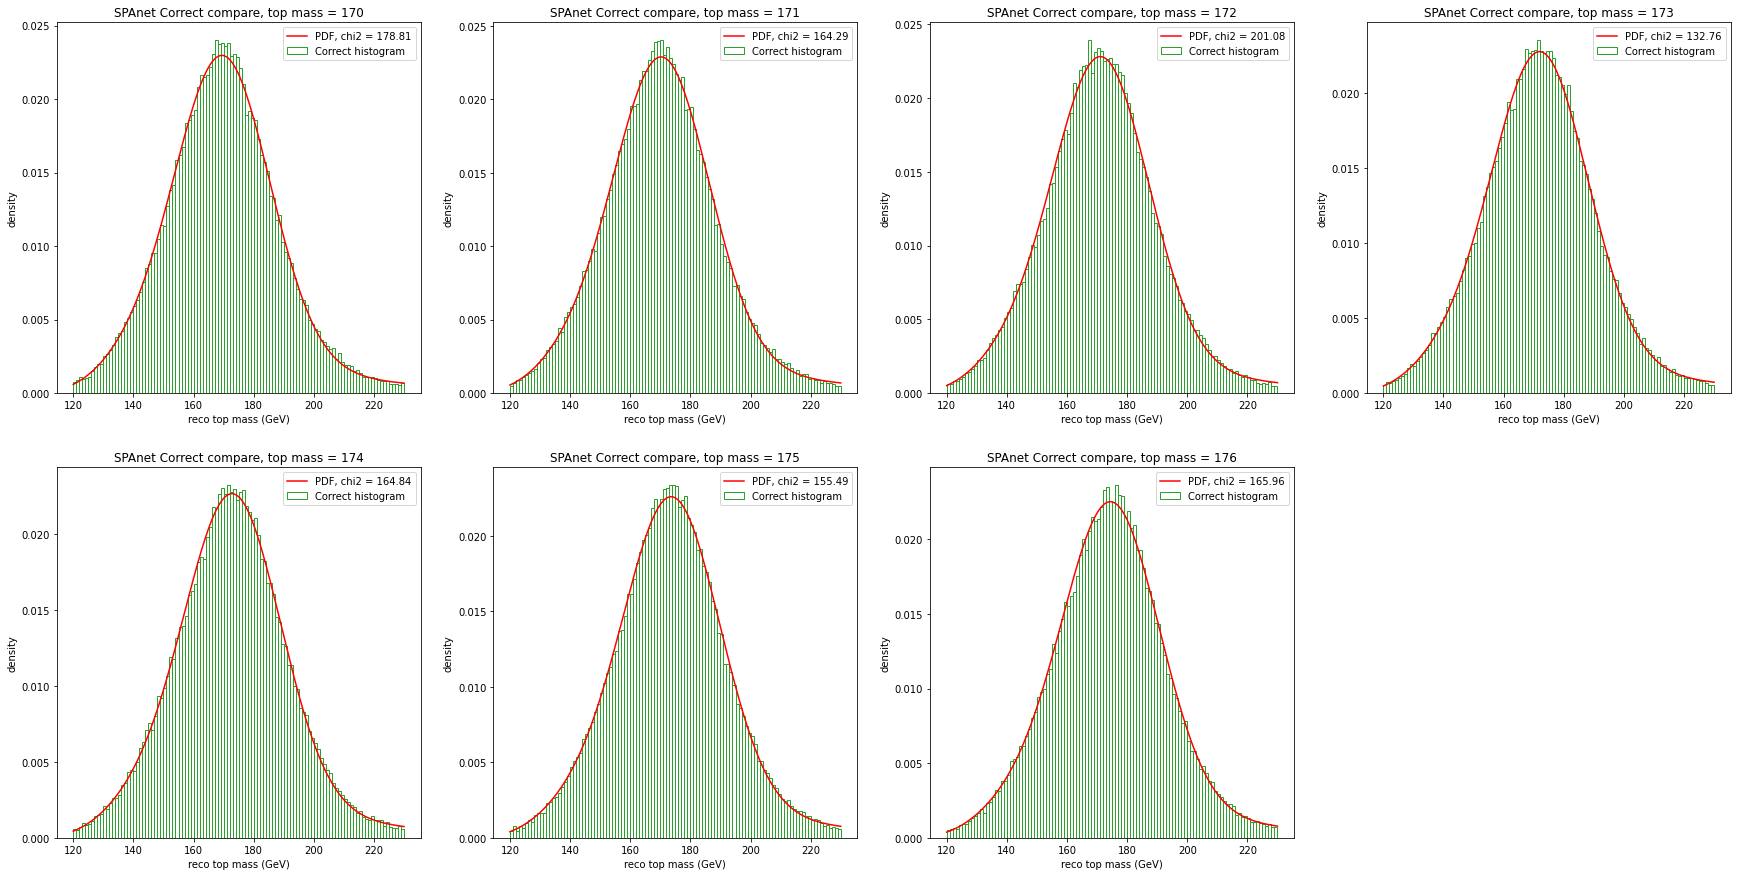

In [19]:
# Compare the SPAnet template histogram and the pdf
for state_i in states:
    plt.figure(figsize=(30,15))
    for i, m in enumerate(mass):
        plt.subplot(2, 4, i+1)
        target = reco_spanet_dic[m][np.logical_and.reduce((cut_spanet_dic[m], likeli_spanet_dic[m], state_spanet_dic[m] == state_i))]
        hist, _ = np.histogram(target, bins=bins, density=True)
        popt = [linear(m, *pdf_spanet_top_dic[(state_i, j)]) for j in range(5)]
        y_template_dense_norm = langau_norm(bins_dense, *popt)
        chi2_pdf_value = chi2_pdf(target, langau_norm(bins_mid, *popt))
        plt.bar(bins_mid, hist, edgecolor=colors[state_i], width=bins_w, color='None', label = state_labels[state_i] + ' histogram')
        plt.plot(bins_dense, y_template_dense_norm, c='r', label='PDF, chi2 = {:.2f}'.format(chi2_pdf_value))
        plt.title('SPAnet {} compare, top mass = {}'.format(state_labels[state_i], m))
        plt.xlabel('reco top mass (GeV)')
        plt.ylabel('density')
        plt.legend(loc='upper right')
    plt.savefig(f'plots_topmass/SPAnet_pdf_compare/SPAnet top {state_labels[state_i]} pdf compare.png', bbox_inches='tight')
    plt.show()

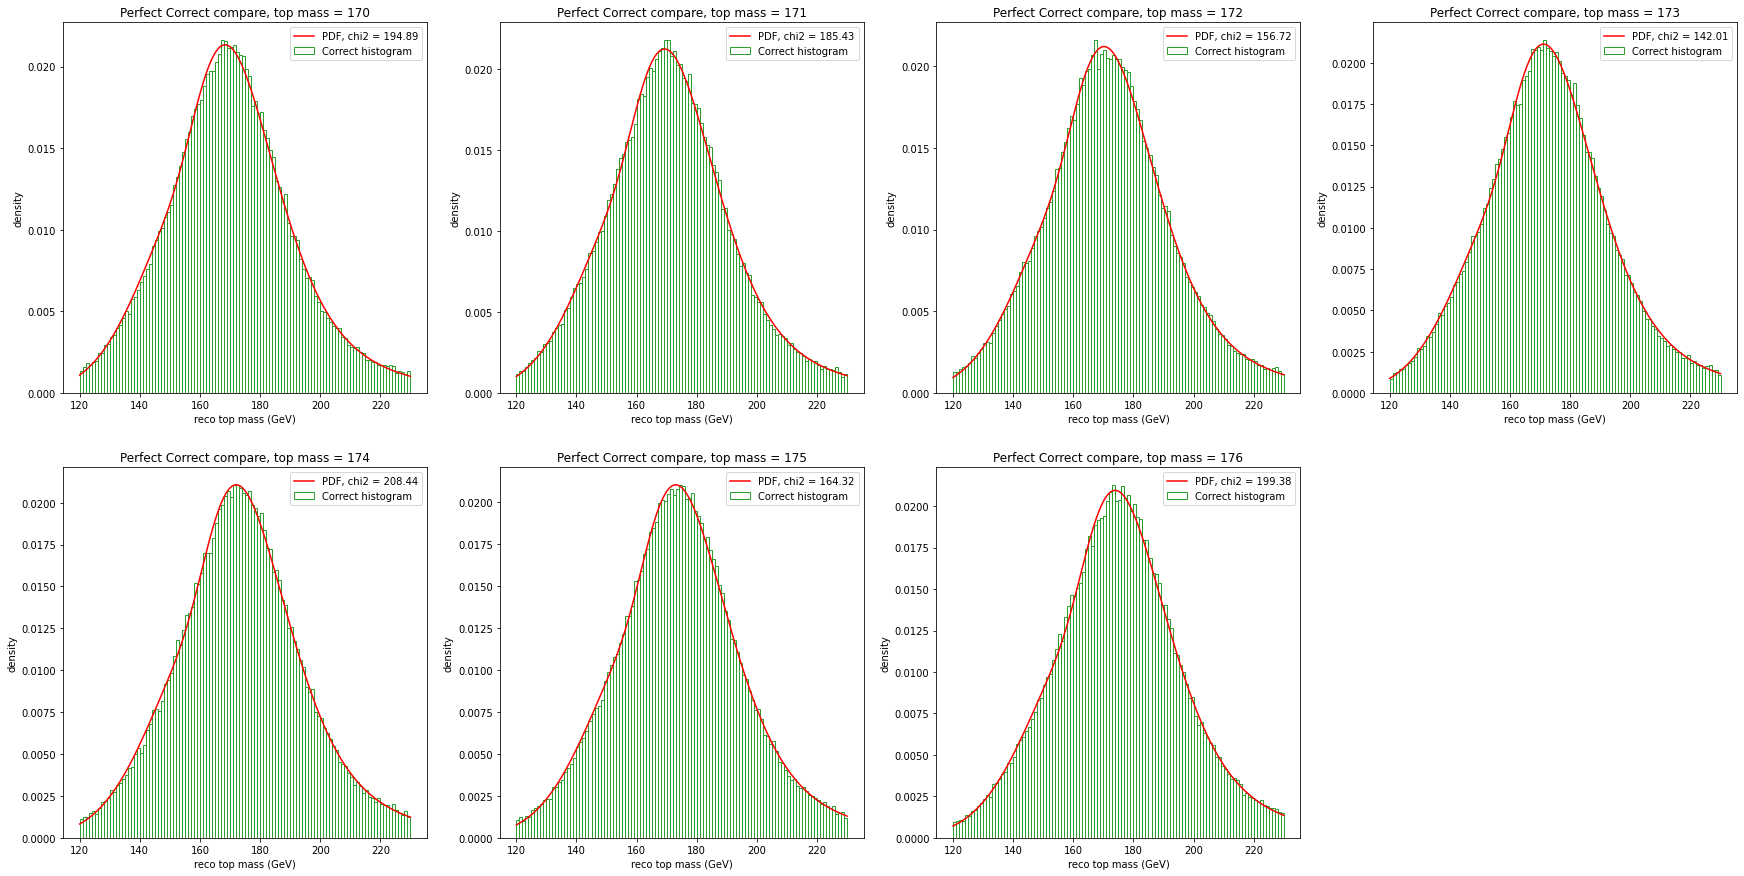

In [20]:
# Compare the perfect template histogram and the pdf
for state_i in [2]:
    plt.figure(figsize=(30,15))
    for i, m in enumerate(mass):
        plt.subplot(2, 4, i+1)
        target = reco_perfect_dic[m][np.logical_and.reduce((cut_perfect_dic[m], state_perfect_dic[m] == state_i))]
        hist, _ = np.histogram(target, bins=bins, density=True)
        popt = [linear(m, *pdf_perfect_top_dic[(state_i, j)]) for j in range(5)]
        y_template_dense_norm = langau_norm(bins_dense, *popt)
        chi2_pdf_value = chi2_pdf(target, langau_norm(bins_mid, *popt))
        plt.bar(bins_mid, hist, edgecolor=colors[state_i], width=bins_w, color='None', label = state_labels[state_i] + ' histogram')
        plt.plot(bins_dense, y_template_dense_norm, c='r', label='PDF, chi2 = {:.2f}'.format(chi2_pdf_value))
        plt.title('Perfect {} compare, top mass = {}'.format(state_labels[state_i], m))
        plt.xlabel('reco top mass (GeV)')
        plt.ylabel('density')
        plt.legend(loc='upper right')
    plt.savefig(f'plots_topmass/Perfect_pdf_compare/Perfect top {state_labels[state_i]} pdf compare.png', bbox_inches='tight')
    plt.show()

In [21]:
def combine_klf_pdf_func(x, m):
    hist = [0]*len(x)
    for state_i in states:
        popt = [linear(m, *pdf_klf_top_dic[(state_i, j)]) for j in range(5)]
        hist += langau_norm(x, *popt)*ratio_klf[state_i]
    return hist

def combine_pdnn_pdf_func(x, m):
    hist = [0]*len(x)
    for state_i in states:
        popt = [linear(m, *pdf_pdnn_top_dic[(state_i, j)]) for j in range(5)]
        hist += langau_norm(x, *popt)*ratio_pdnn[state_i]
    return hist

def combine_spanet_pdf_func(x, m):
    hist = [0]*len(x)
    for state_i in states:
        popt = [linear(m, *pdf_spanet_top_dic[(state_i, j)]) for j in range(5)]
        hist += langau_norm(x, *popt)*ratio_spanet[state_i]
    return hist

def combine_perfect_pdf_func(x, m):
    popt = [linear(m, *pdf_perfect_top_dic[(state_i, j)]) for j in range(5)]
    return langau_norm(x, *popt)

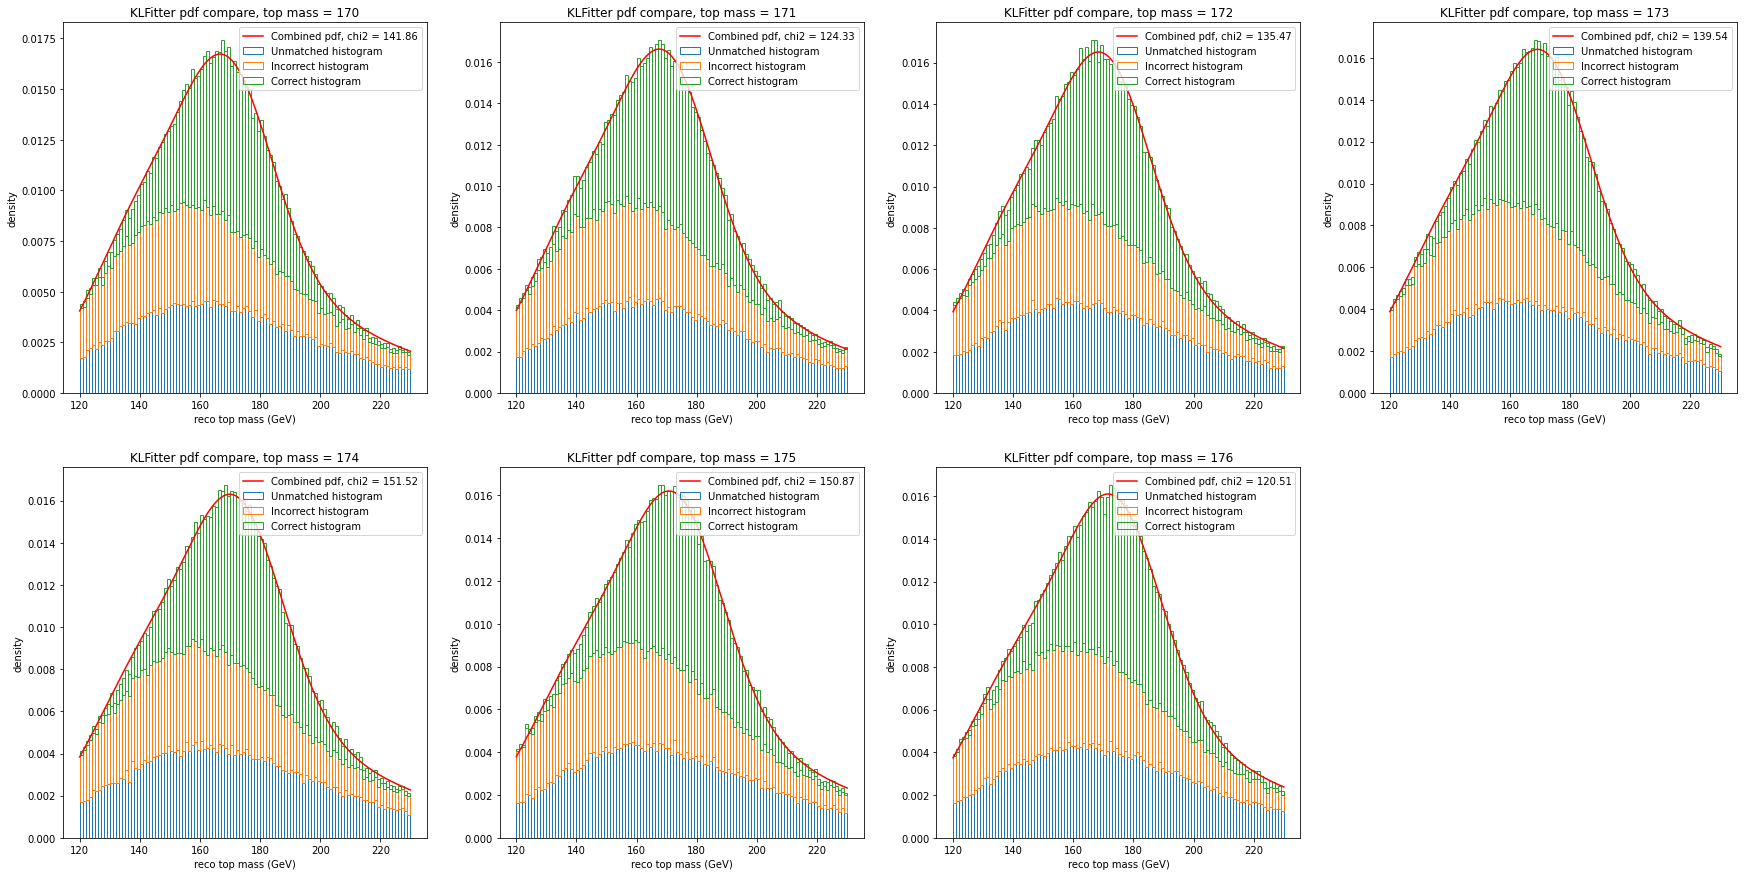

In [22]:
plt.figure(figsize=(30,15))
for i, m in enumerate(mass):
    plt.subplot(2, 4, i+1)
    target = reco_klf_dic[m][np.logical_and(cut_klf_dic[m], likeli_klf_dic[m])]
    klf_pdf = combine_klf_pdf_func(bins_dense, m)
    chi2_pdf_value = chi2_pdf(target, combine_klf_pdf_func(bins_mid, m))

    h, tot = [0]*(len(bins)-1), len(target)
    for state_i in states:
        hist, _ = np.histogram(reco_klf_dic[m][np.logical_and.reduce((state_klf_dic[m] == state_i, likeli_klf_dic[m], cut_klf_dic[m]))], bins=bins)
        plt.bar(bins_mid, hist/tot/bins_w, bottom=h, edgecolor=colors[state_i], width=bins_w, color='None', label = state_labels[state_i] + ' histogram')
        h += hist/tot/bins_w

    plt.plot(bins_dense, klf_pdf, c='r', label='Combined pdf, chi2 = {:.2f}'.format(chi2_pdf_value))
    plt.title(f'KLFitter pdf compare, top mass = {m}')
    plt.xlabel('reco top mass (GeV)')
    plt.ylabel('density')
    plt.legend(loc='upper right')
plt.savefig(f'plots_topmass/KLFitter_pdf_compare/KLFitter top pdf compare.png', bbox_inches='tight')
plt.show()

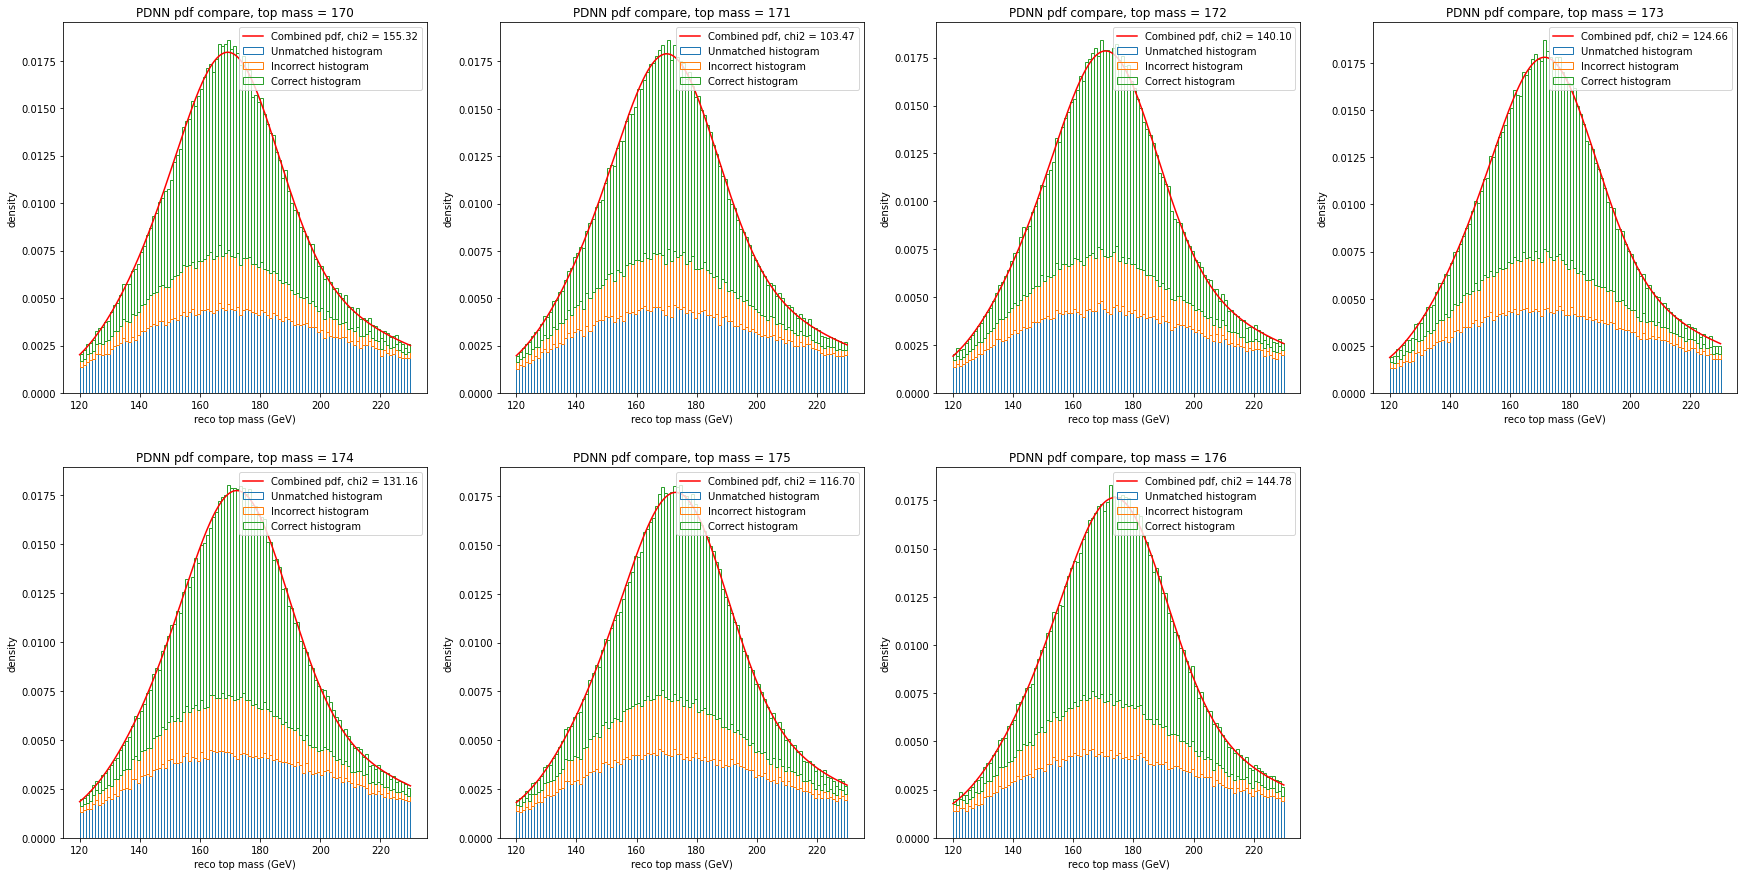

In [23]:
plt.figure(figsize=(30,15))
for i, m in enumerate(mass):
    plt.subplot(2, 4, i+1)
    target = reco_pdnn_dic[m][np.logical_and(cut_pdnn_dic[m], likeli_pdnn_dic[m])]
    pdnn_pdf = combine_pdnn_pdf_func(bins_dense, m)
    chi2_pdf_value = chi2_pdf(target, combine_pdnn_pdf_func(bins_mid, m))

    h, tot = [0]*(len(bins)-1), len(target)
    for state_i in states:
        hist, _ = np.histogram(reco_pdnn_dic[m][np.logical_and.reduce((state_pdnn_dic[m] == state_i, likeli_pdnn_dic[m], cut_pdnn_dic[m]))], bins=bins)
        plt.bar(bins_mid, hist/tot/bins_w, bottom=h, edgecolor=colors[state_i], width=bins_w, color='None', label = state_labels[state_i] + ' histogram')
        h += hist/tot/bins_w

    plt.plot(bins_dense, pdnn_pdf, c='r', label='Combined pdf, chi2 = {:.2f}'.format(chi2_pdf_value))
    plt.title(f'PDNN pdf compare, top mass = {m}')
    plt.xlabel('reco top mass (GeV)')
    plt.ylabel('density')
    plt.legend(loc='upper right')
plt.savefig(f'plots_topmass/PDNN_pdf_compare/PDNN top pdf compare.png', bbox_inches='tight')
plt.show()

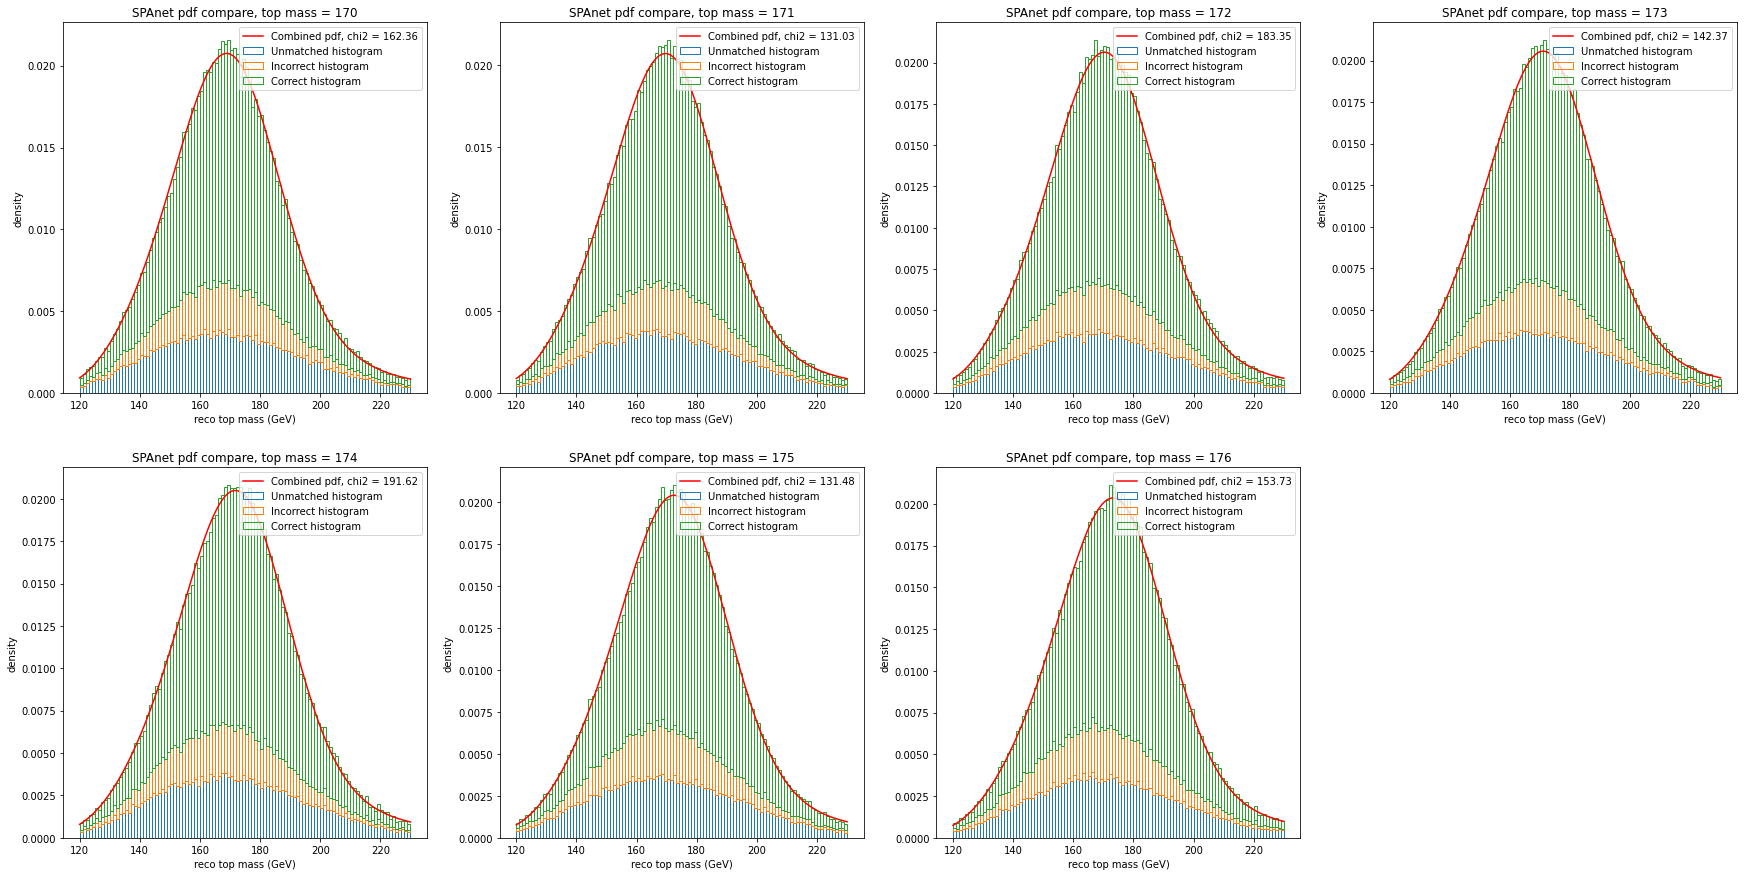

In [24]:
plt.figure(figsize=(30,15))
for i, m in enumerate(mass):
    plt.subplot(2, 4, i+1)
    target = reco_spanet_dic[m][np.logical_and(cut_spanet_dic[m], likeli_spanet_dic[m])]
    spanet_pdf = combine_spanet_pdf_func(bins_dense, m)
    chi2_pdf_value = chi2_pdf(target, combine_spanet_pdf_func(bins_mid, m))

    h, tot = [0]*(len(bins)-1), len(target)
    for state_i in states:
        hist, _ = np.histogram(reco_spanet_dic[m][np.logical_and.reduce((state_spanet_dic[m] == state_i, likeli_spanet_dic[m], cut_spanet_dic[m]))], bins=bins)
        plt.bar(bins_mid, hist/tot/bins_w, bottom=h, edgecolor=colors[state_i], width=bins_w, color='None', label = state_labels[state_i] + ' histogram')
        h += hist/tot/bins_w

    plt.plot(bins_dense, spanet_pdf, c='r', label='Combined pdf, chi2 = {:.2f}'.format(chi2_pdf_value))
    plt.title(f'SPAnet pdf compare, top mass = {m}')
    plt.xlabel('reco top mass (GeV)')
    plt.ylabel('density')
    plt.legend(loc='upper right')
plt.savefig(f'plots_topmass/SPAnet_pdf_compare/SPAnet top pdf compare.png', bbox_inches='tight')
plt.show()

In [25]:
# Sudo experiment for KLFitter
sudo_klf_top_mean_dic = {}
sudo_klf_top_std_dic = {}

for m in tqdm(mass, total=len(mass)):
    sudo_klf = reco_klf_dic[m][np.logical_and.reduce((cut_klf_dic[m], likeli_klf_dic[m]))]
    n1_arr = np.random.poisson(np.histogram(sudo_klf, bins=bins)[0], size=(sudo_event, len(bins)-1))
    def minimize_chi2(i):
        chi2_klf_arr_fcn = lambda m: -2*np.sum(n1_arr[i]*np.log(combine_klf_pdf_func(bins_mid, m)*sum(n1_arr[i])*bins_w))
        minuit = Minuit(chi2_klf_arr_fcn, m=173)
        minuit.limits = [(166, 180)]
        minuit.migrad()
        minuit.minos()
        return list(minuit.values), list(minuit.errors)
    with Pool() as pool:
        results = []
        for i in range(sudo_event):
            results.append(pool.apply_async(minimize_chi2, args=((i,))))

        mean, std = [], []
        for result in results:
            res = result.get()
            mean.extend(res[0])
            std.extend(res[1])
        sudo_klf_top_mean_dic[m] = mean
        sudo_klf_top_std_dic[m] = std


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:46<00:00, 23.79s/it]


In [26]:
# Sudo experiment for PDNN
sudo_pdnn_top_mean_dic = {}
sudo_pdnn_top_std_dic = {}

for m in tqdm(mass, total=len(mass)):
    sudo_pdnn = reco_pdnn_dic[m][np.logical_and.reduce((cut_pdnn_dic[m], likeli_pdnn_dic[m]))]
    n1_arr = np.random.poisson(np.histogram(sudo_pdnn, bins=bins)[0], size=(sudo_event, len(bins)-1))
    def minimize_chi2(i):
        chi2_pdnn_arr_fcn = lambda m: -2*np.sum(n1_arr[i]*np.log(combine_pdnn_pdf_func(bins_mid, m)*sum(n1_arr[i])*bins_w))
        minuit = Minuit(chi2_pdnn_arr_fcn, m=173)
        minuit.limits = [(166, 180)]
        minuit.migrad()
        minuit.minos()
        return list(minuit.values), list(minuit.errors)
    with Pool() as pool:
        results = []
        for i in range(sudo_event):
            results.append(pool.apply_async(minimize_chi2, args=((i,))))

        mean, std = [], []
        for result in results:
            res = result.get()
            mean.extend(res[0])
            std.extend(res[1])
        sudo_pdnn_top_mean_dic[m] = mean
        sudo_pdnn_top_std_dic[m] = std


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:14<00:00, 19.15s/it]


In [27]:
# Sudo experiment for SPAnet
sudo_spanet_top_mean_dic = {}
sudo_spanet_top_std_dic = {}

for m in tqdm(mass, total=len(mass)):
    sudo_spanet = reco_spanet_dic[m][np.logical_and.reduce((cut_spanet_dic[m], likeli_spanet_dic[m]))]
    n1_arr = np.random.poisson(np.histogram(sudo_spanet, bins=bins)[0], size=(sudo_event, len(bins)-1))
    def minimize_chi2(i):
        chi2_spanet_arr_fcn = lambda m: -2*np.sum(n1_arr[i]*np.log(combine_spanet_pdf_func(bins_mid, m)*sum(n1_arr[i])*bins_w))
        minuit = Minuit(chi2_spanet_arr_fcn, m=173)
        minuit.limits = [(166, 180)]
        minuit.migrad()
        minuit.minos()
        return list(minuit.values), list(minuit.errors)
    with Pool() as pool:
        results = []
        for i in range(sudo_event):
            results.append(pool.apply_async(minimize_chi2, args=((i,))))

        mean, std = [], []
        for result in results:
            res = result.get()
            mean.extend(res[0])
            std.extend(res[1])
        sudo_spanet_top_mean_dic[m] = mean
        sudo_spanet_top_std_dic[m] = std


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:48<00:00, 24.11s/it]


In [28]:
# Sudo experiment for Perfect
sudo_perfect_top_mean_dic = {}
sudo_perfect_top_std_dic = {}

for m in tqdm(mass, total=len(mass)):
    sudo_perfect = reco_perfect_dic[m][np.logical_and.reduce((cut_perfect_dic[m], state_perfect_dic[m]==2))]
    n1_arr = np.random.poisson(np.histogram(sudo_perfect, bins=bins)[0], size=(sudo_event, len(bins)-1))
    def minimize_chi2(i):
        chi2_perfect_arr_fcn = lambda m: -2*np.sum(n1_arr[i]*np.log(combine_perfect_pdf_func(bins_mid, m)*sum(n1_arr[i])*bins_w))
        minuit = Minuit(chi2_perfect_arr_fcn, m=173)
        minuit.limits = [(166, 180)]
        minuit.migrad()
        minuit.minos()
        return list(minuit.values), list(minuit.errors)
    with Pool() as pool:
        results = []
        for i in range(sudo_event):
            results.append(pool.apply_async(minimize_chi2, args=((i,))))

        mean, std = [], []
        for result in results:
            res = result.get()
            mean.extend(res[0])
            std.extend(res[1])
        sudo_perfect_top_mean_dic[m] = mean
        sudo_perfect_top_std_dic[m] = std

  0%|                                                                                                                                | 0/7 [00:08<?, ?it/s]


RuntimeError: Function minimum is not valid: <FMin algorithm='Migrad' edm=0.02565713287816915 edm_goal=0.0002 errordef=1.0 fval=-1982019.2658161593 has_accurate_covar=True has_covariance=True has_made_posdef_covar=False has_parameters_at_limit=False has_posdef_covar=True has_reached_call_limit=False has_valid_parameters=False hesse_failed=False is_above_max_edm=True is_valid=False nfcn=111 ngrad=0 reduced_chi2=nan time=0.2948504230007529>

In [ ]:
np.savez('top_mass_pseudo_experiment/sudo_klf2.npz', sudo_klf_top_mean_dic=sudo_klf_top_mean_dic, sudo_klf_top_std_dic=sudo_klf_top_std_dic)
np.savez('top_mass_pseudo_experiment/sudo_pdnn.npz', sudo_pdnn_top_mean_dic=sudo_pdnn_top_mean_dic, sudo_pdnn_top_std_dic=sudo_pdnn_top_std_dic)
np.savez('top_mass_pseudo_experiment/sudo_spanet2.npz', sudo_spanet_top_mean_dic=sudo_spanet_top_mean_dic, sudo_spanet_top_std_dic=sudo_spanet_top_std_dic)
np.savez('top_mass_pseudo_experiment/sudo_perfect2.npz', sudo_perfect_top_mean_dic=sudo_perfect_top_mean_dic, sudo_perfect_top_std_dic=sudo_perfect_top_std_dic)


In [29]:
data = np.load('top_mass_pseudo_experiment/sudo_klf2.npz', allow_pickle=True)
sudo_klf_top_mean_dic = data['sudo_klf_top_mean_dic'].item()
sudo_klf_top_std_dic = data['sudo_klf_top_std_dic'].item()

data = np.load('top_mass_pseudo_experiment/sudo_pdnn.npz', allow_pickle=True)
sudo_pdnn_top_mean_dic = data['sudo_pdnn_top_mean_dic'].item()
sudo_pdnn_top_std_dic = data['sudo_pdnn_top_std_dic'].item()

data = np.load('top_mass_pseudo_experiment/sudo_spanet2.npz', allow_pickle=True)
sudo_spanet_top_mean_dic = data['sudo_spanet_top_mean_dic'].item()
sudo_spanet_top_std_dic = data['sudo_spanet_top_std_dic'].item()

data = np.load('top_mass_pseudo_experiment/sudo_perfect.npz', allow_pickle=True)
sudo_perfect_top_mean_dic = data['sudo_perfect_top_mean_dic'].item()
sudo_perfect_top_std_dic = data['sudo_perfect_top_std_dic'].item()

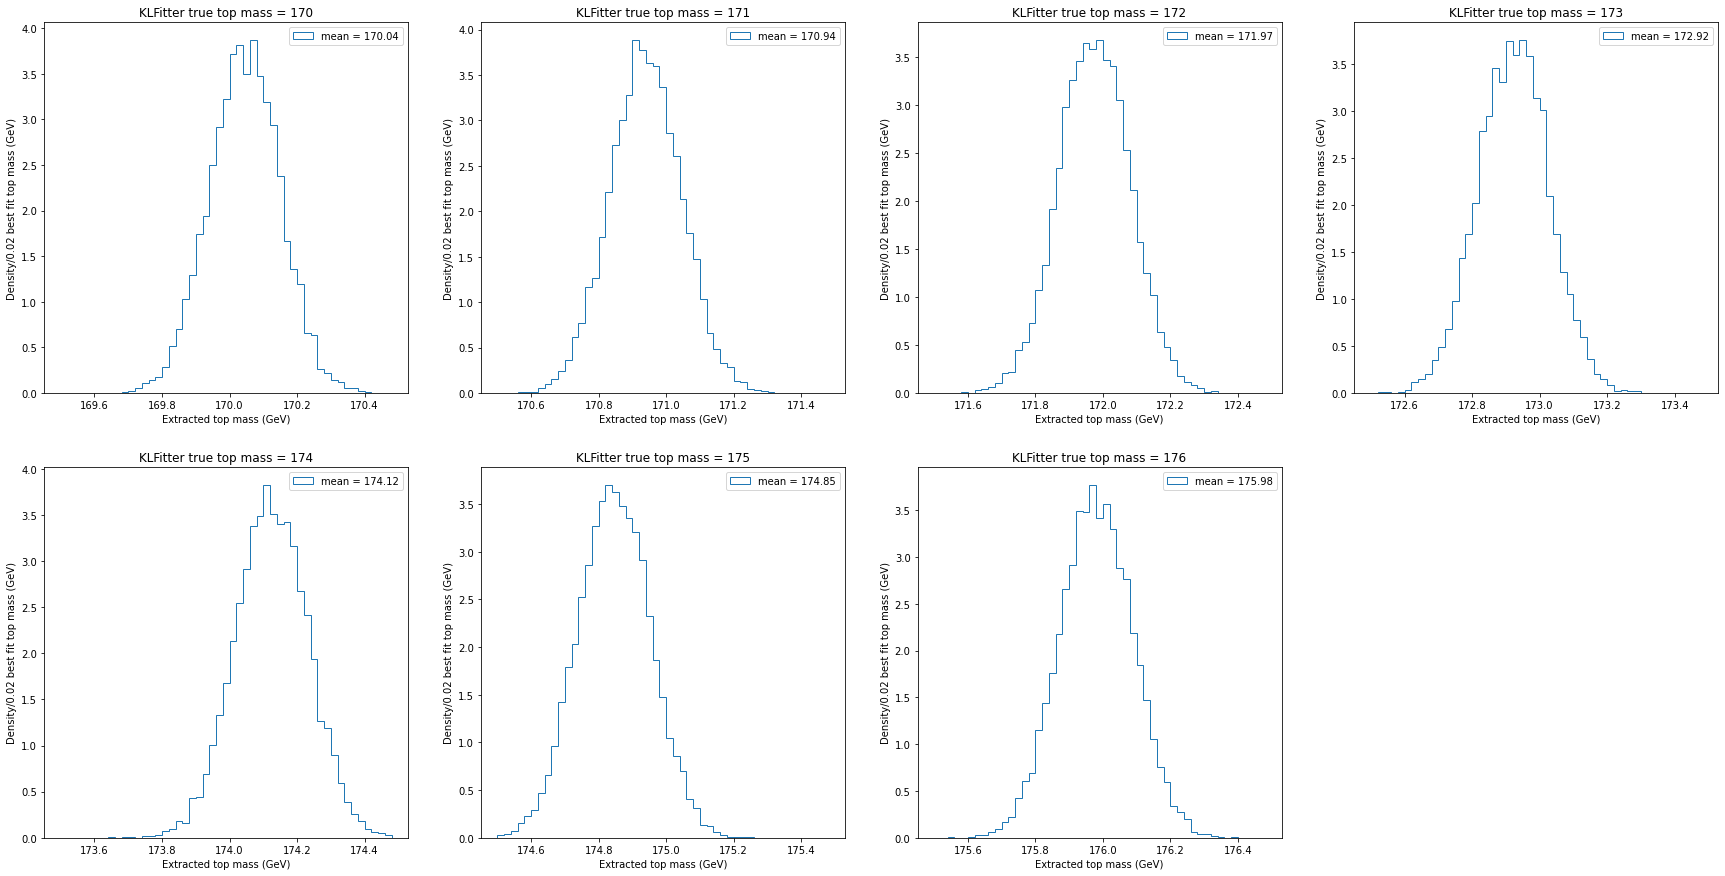

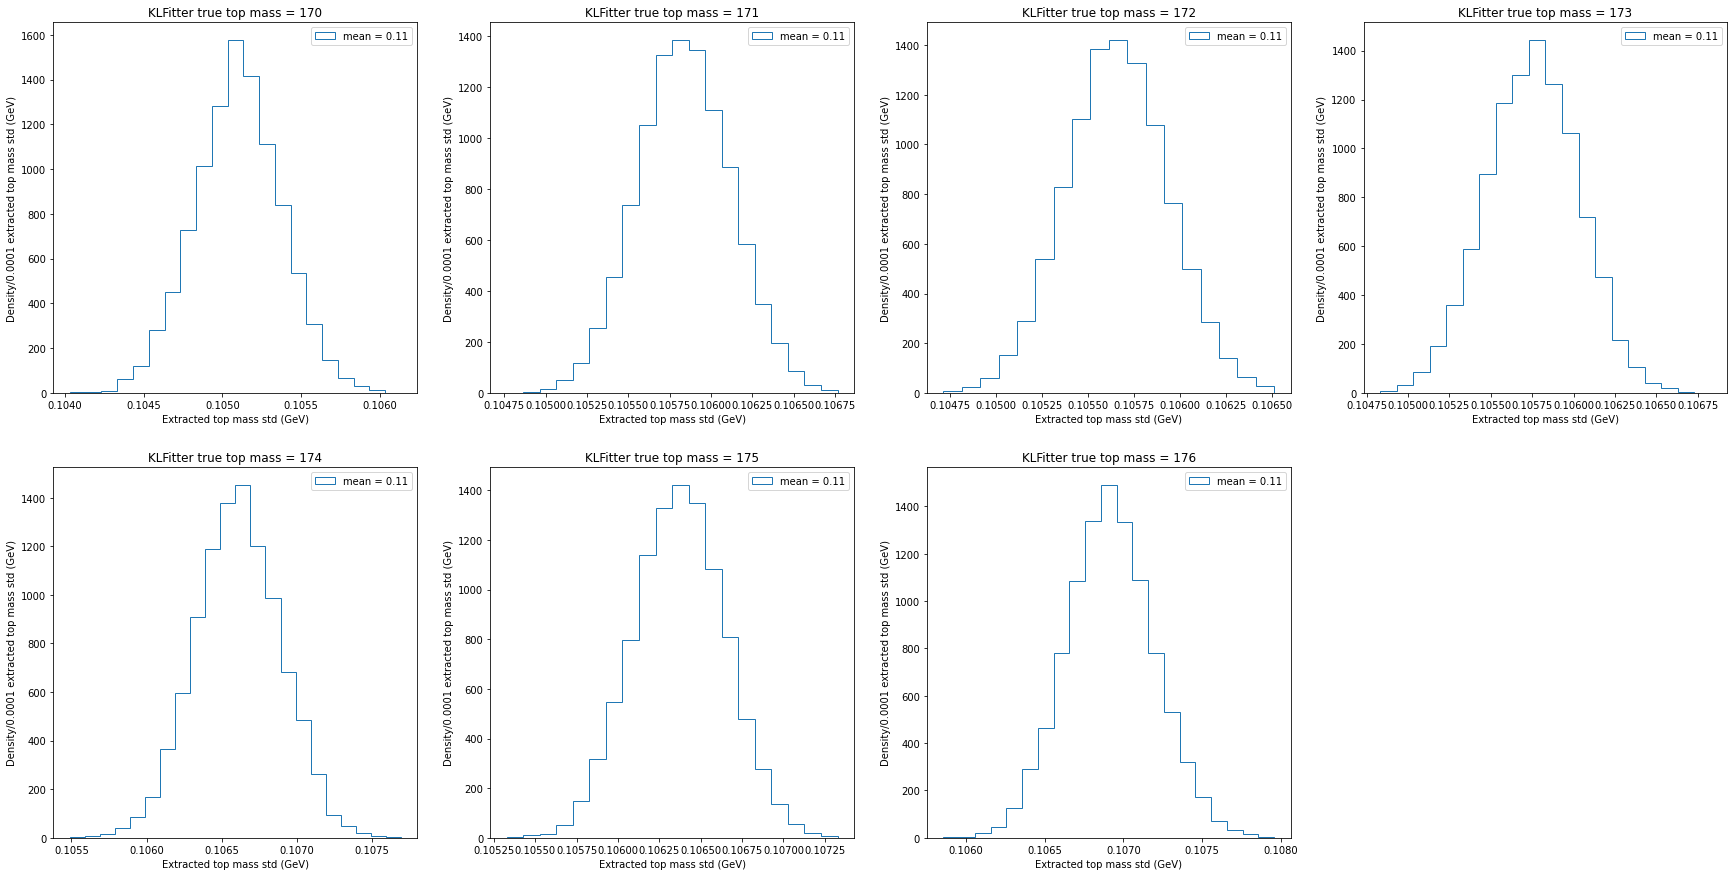

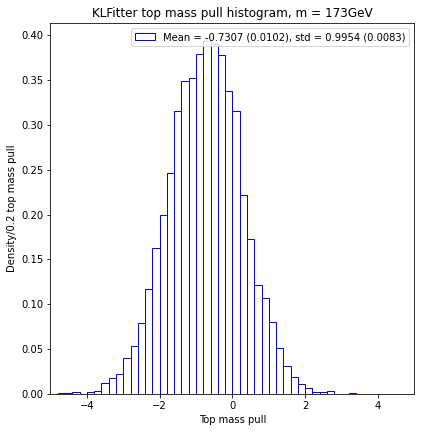

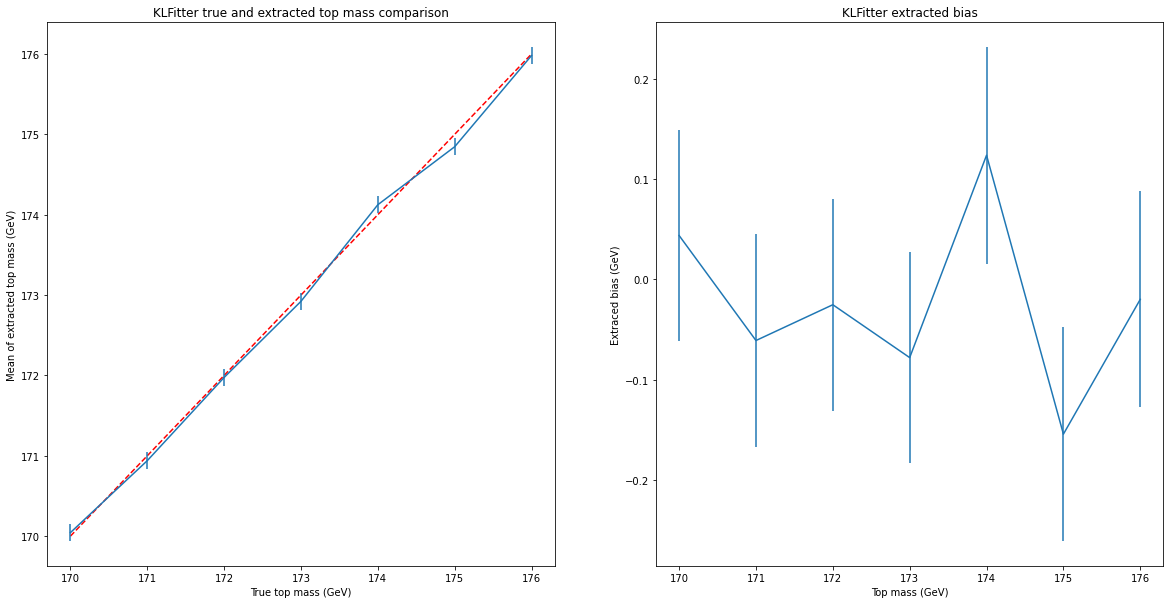

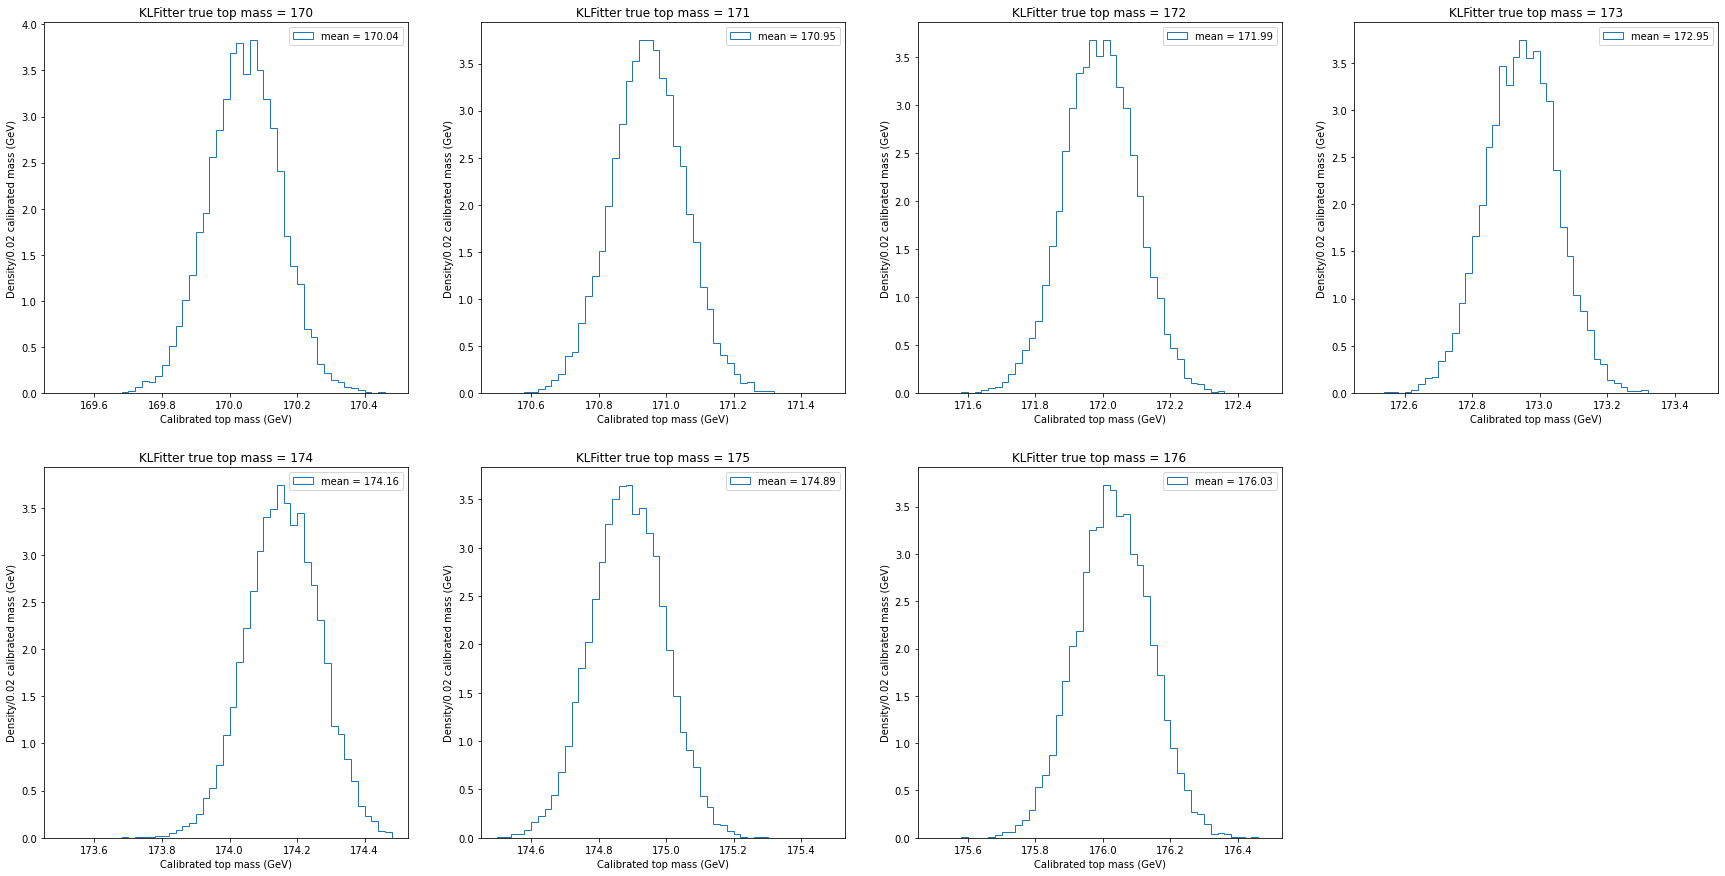

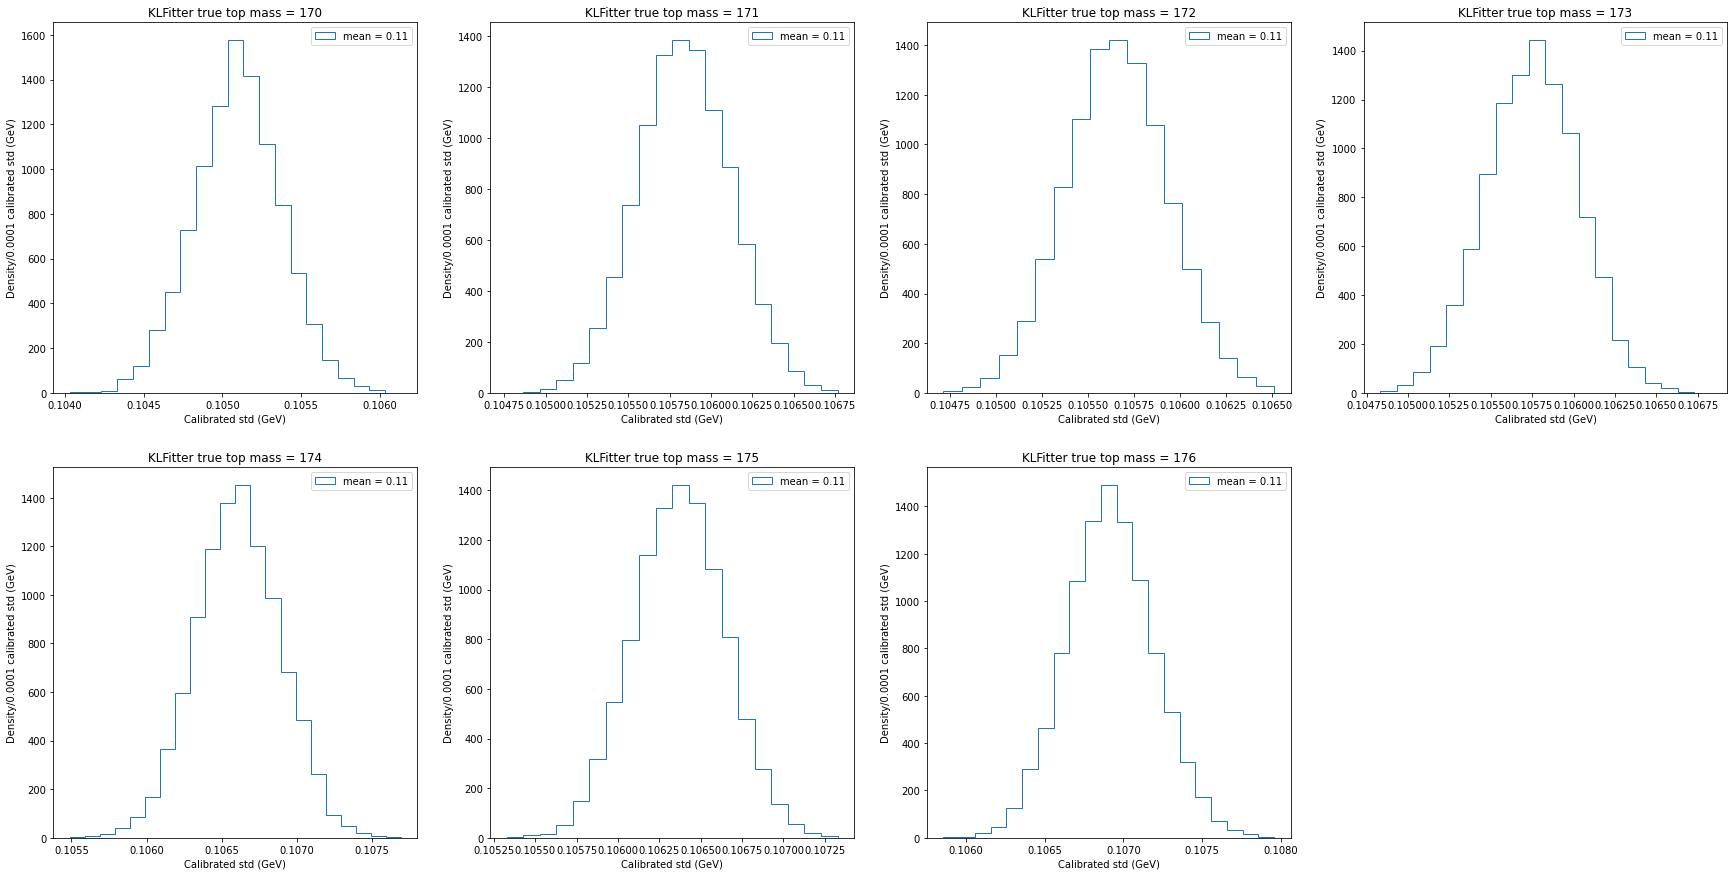

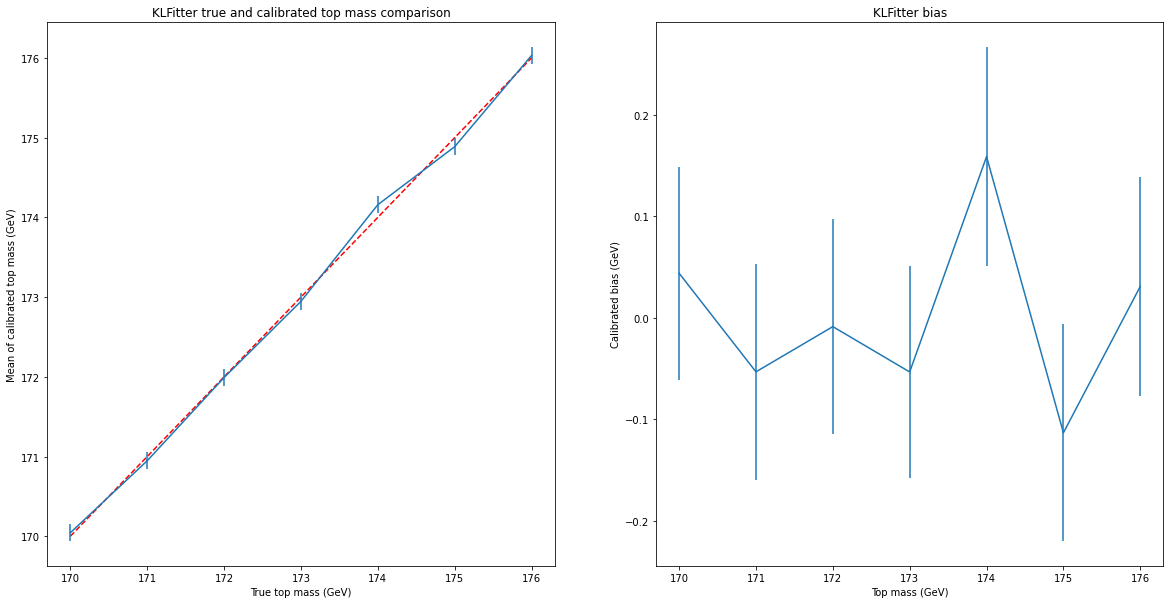

In [30]:
# Calibration of KLFitter
plt.figure(figsize=(30,15))
for i, m in enumerate(mass):
    plt.subplot(2, 4, i+1)
    bins_top = np.arange(m-0.5, m+0.5, 0.02)
    plt.hist(sudo_klf_top_mean_dic[m], bins=bins_top, density=True, histtype='step', label=f'mean = {np.mean(sudo_klf_top_mean_dic[m]):.2f}')
    plt.title(f'KLFitter true top mass = {m}')
    plt.xlabel('Extracted top mass (GeV)')
    plt.ylabel('Density/0.02 best fit top mass (GeV)')
    plt.legend(loc='upper right')
plt.savefig('plots_topmass/final_plots/KLFitter extracted top mass histogram.png')
plt.show()

plt.figure(figsize=(30,15))
for i, m in enumerate(mass):
    plt.subplot(2, 4, i+1)
    target = sudo_klf_top_std_dic[m]
    bins_top = np.arange(np.min(target), np.max(target), 0.0001)
    plt.hist(target, bins=bins_top, density=True, histtype='step', label=f'mean = {np.mean(sudo_klf_top_std_dic[m]):.2f}')
    plt.title(f'KLFitter true top mass = {m}')
    plt.xlabel('Extracted top mass std (GeV)')
    plt.ylabel('Density/0.0001 extracted top mass std (GeV)')
    plt.legend(loc='upper right')
plt.savefig('plots_topmass/final_plots/KLFitter extracted top mass std histogram.png')
plt.show()

plt.figure(figsize=(30,15))
for i, m in enumerate([173]):
    plt.subplot(2, 4, i+1)
    klf_top_pull = (np.array(sudo_klf_top_mean_dic[m])-m)/sudo_klf_top_std_dic[m]
    hist, bin_edges = np.histogram(klf_top_pull, bins=np.arange(-5, 5, 0.2), density=True)
    popt, pcov = optimize.curve_fit(gau_norm, bin_edges[:-1]+0.1, hist)
    perr = np.sqrt(np.diag(pcov))
    plt.bar(bin_edges[:-1]+0.1, hist, edgecolor='b', width=0.2, color='None', label = 'Mean = {:.4f} ({:.4f}), std = {:.4f} ({:.4f})'.format(popt[0], perr[0], popt[1], perr[1]))
    klf_pull_sigma = max(1, popt[1])
    plt.title('KLFitter top mass pull histogram, m = 173GeV')
    plt.xlim(-5, 5)
    plt.xlabel('Top mass pull')
    plt.ylabel('Density/0.2 top mass pull')
    plt.legend(loc='upper right')
plt.savefig('plots_topmass/final_plots/KLFitter top mass pull histogram, m = 173GeV.png')
plt.show()

plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.plot(mass, mass, 'r--')
plt.errorbar(mass, [np.mean(sudo_klf_top_mean_dic[m]) for m in mass], yerr=[np.std(sudo_klf_top_mean_dic[m]) for m in mass])
plt.title('KLFitter true and extracted top mass comparison')
plt.xlabel('True top mass (GeV)')
plt.ylabel('Mean of extracted top mass (GeV)')
plt.subplot(1, 2, 2)
plt.errorbar(mass, [np.mean(sudo_klf_top_mean_dic[m])-m for m in mass], yerr=[np.std(sudo_klf_top_mean_dic[m]) for m in mass])
plt.title('KLFitter extracted bias')
plt.xlabel('Top mass (GeV)')
plt.ylabel('Extraced bias (GeV)')
plt.savefig('plots_topmass/final_plots/KLFitter extracted bias.png')
plt.show()

klf_popt, _ = optimize.curve_fit(linear, mass, [np.mean(sudo_klf_top_mean_dic[m]) for m in mass], sigma=[np.std(sudo_klf_top_mean_dic[m])/np.sqrt(sudo_event) for m in mass], method="lm")
def predicted_klf_top_func(extracted_top): return (np.array(extracted_top) - klf_popt[1])/klf_popt[0] + 173

plt.figure(figsize=(30,15))
for i, m in enumerate(mass):
    plt.subplot(2, 4, i+1)
    bins_top = np.arange(m-0.5, m+0.5, 0.02)
    x, _, _ = plt.hist(predicted_klf_top_func(sudo_klf_top_mean_dic[m]), bins=bins_top, density=True, histtype='step', label=f'mean = {predicted_klf_top_func(np.mean(sudo_klf_top_mean_dic[m])):.2f}')
    perr = np.sqrt(np.diag(pcov))
    plt.title(f'KLFitter true top mass = {m}')
    plt.xlabel('Calibrated top mass (GeV)')
    plt.ylabel('Density/0.02 calibrated mass (GeV)')
    plt.legend(loc='upper right')
plt.savefig('plots_topmass/final_plots/KLFitter calibrated top mass histogram.png')
plt.show()

plt.figure(figsize=(30,15))
for i, m in enumerate(mass):
    plt.subplot(2, 4, i+1)
    target = np.array(sudo_klf_top_std_dic[m])*klf_pull_sigma
    bins_top = np.arange(np.min(target), np.max(target), 0.0001)
    plt.hist(target, bins=bins_top, density=True, histtype='step', label=f'mean = {np.mean(sudo_klf_top_std_dic[m]):.2f}')
    plt.title(f'KLFitter true top mass = {m}')
    plt.xlabel('Calibrated std (GeV)')
    plt.ylabel('Density/0.0001 calibrated std (GeV)')
    plt.legend(loc='upper right')
plt.savefig('plots_topmass/final_plots/KLFitter calibrated top mass std histogram.png')
plt.show()

plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.plot(mass, mass, 'r--')
plt.errorbar(mass, [np.mean(predicted_klf_top_func(sudo_klf_top_mean_dic[m])) for m in mass], yerr=[np.std(sudo_klf_top_mean_dic[m]) for m in mass])
plt.title('KLFitter true and calibrated top mass comparison')
plt.xlabel('True top mass (GeV)')
plt.ylabel('Mean of calibrated top mass (GeV)')
plt.subplot(1, 2, 2)
plt.errorbar(mass, [np.mean(predicted_klf_top_func(sudo_klf_top_mean_dic[m])-m) for m in mass], yerr=[np.std(sudo_klf_top_mean_dic[m]) for m in mass])
plt.title('KLFitter bias')
plt.xlabel('Top mass (GeV)')
plt.ylabel('Calibrated bias (GeV)')
plt.savefig('plots_topmass/final_plots/KLFitter calibrated bias.png')
plt.show()


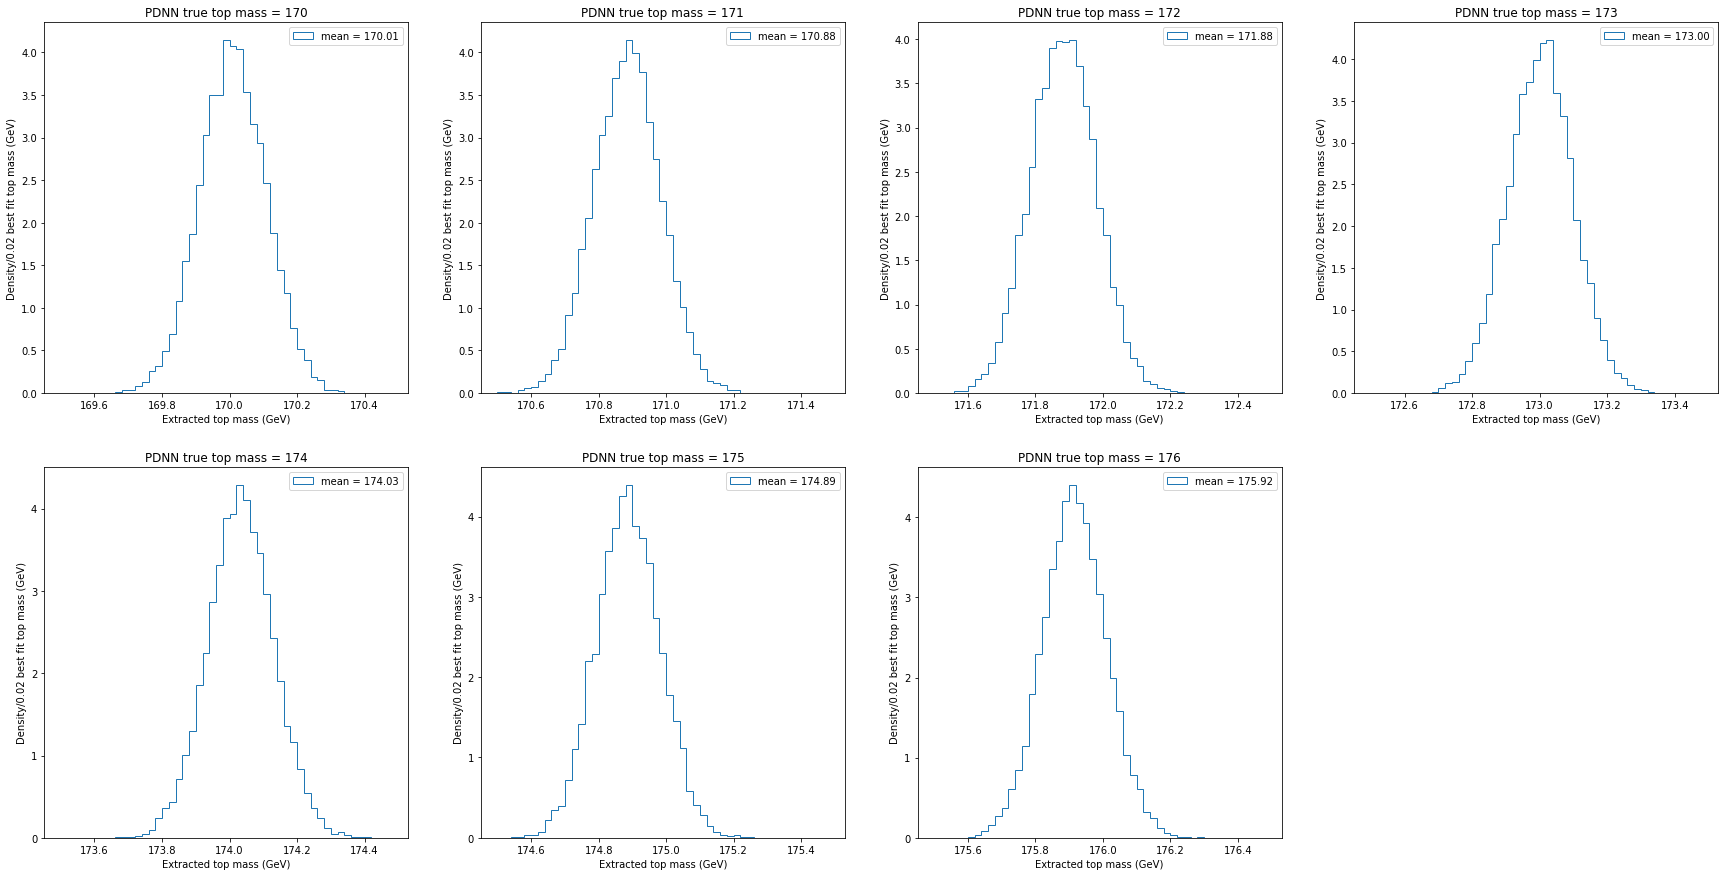

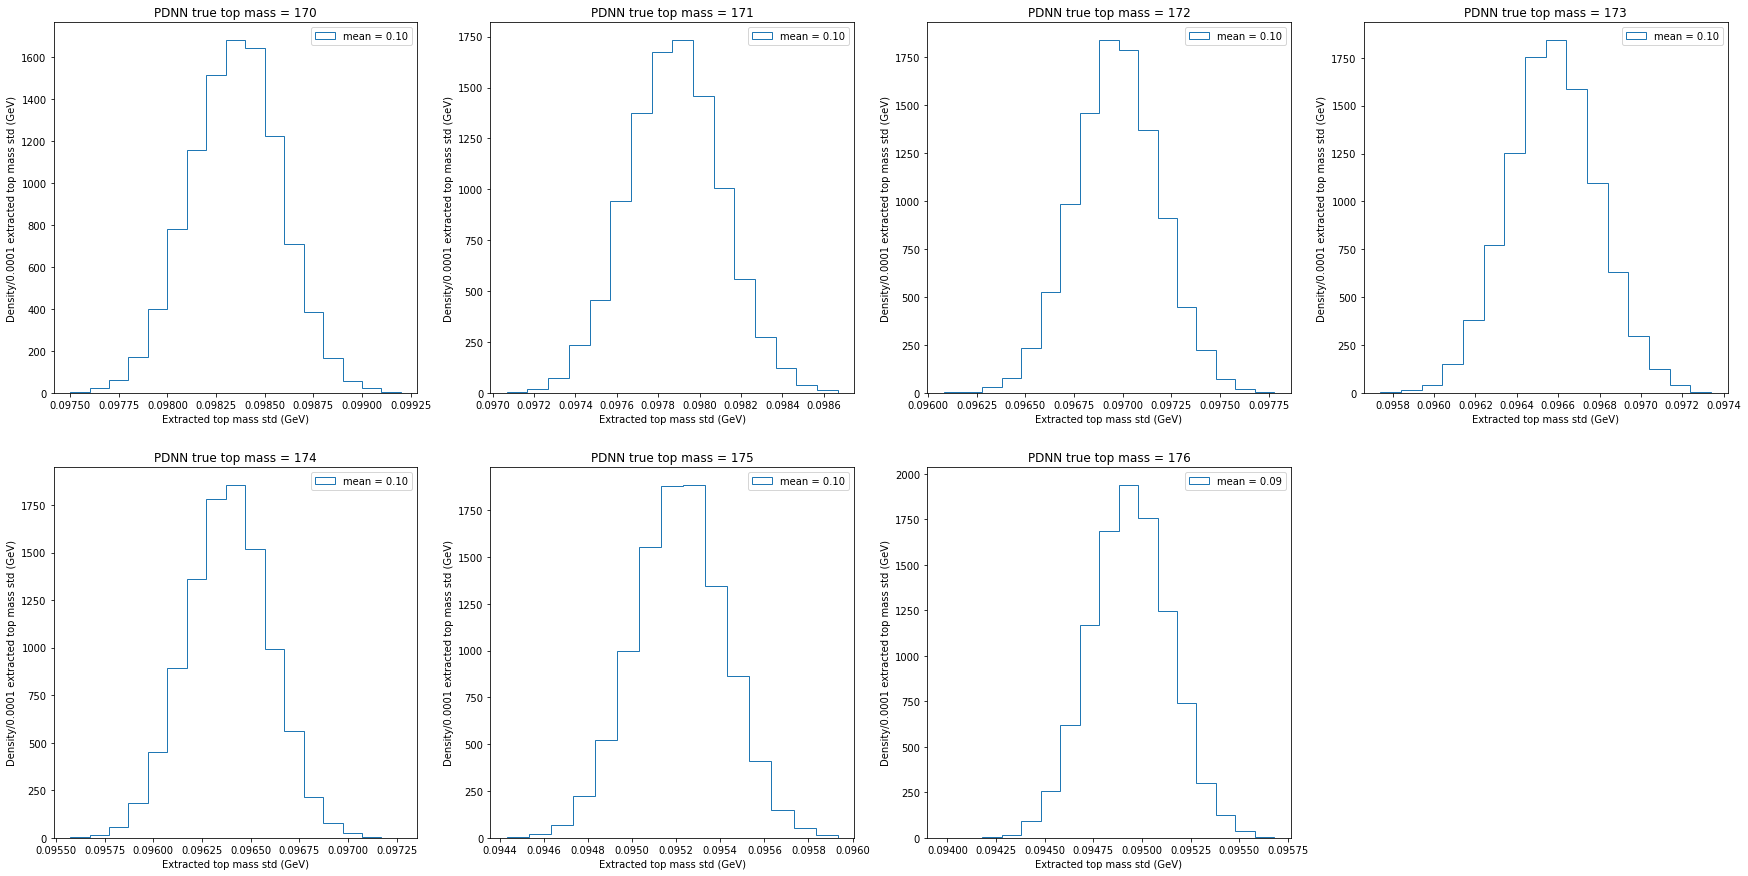

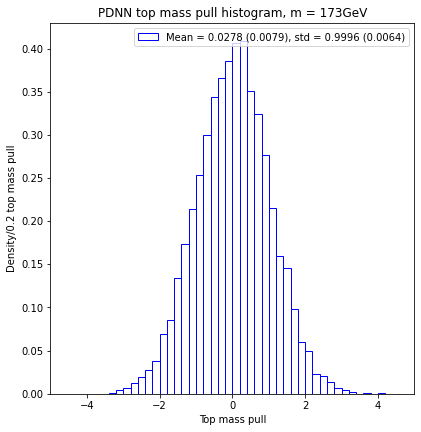

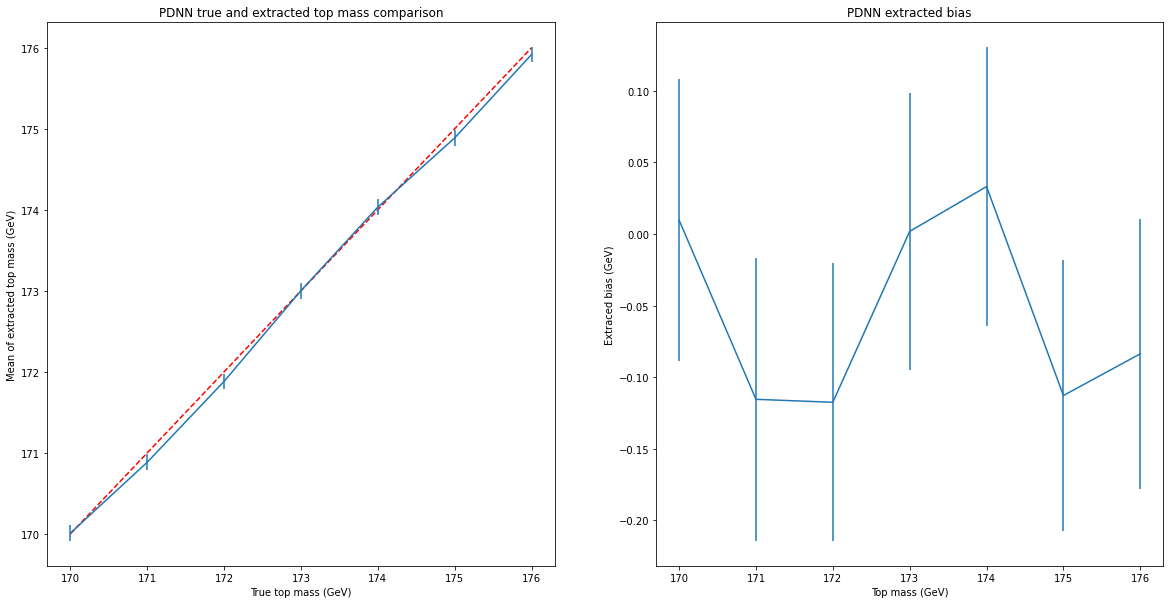

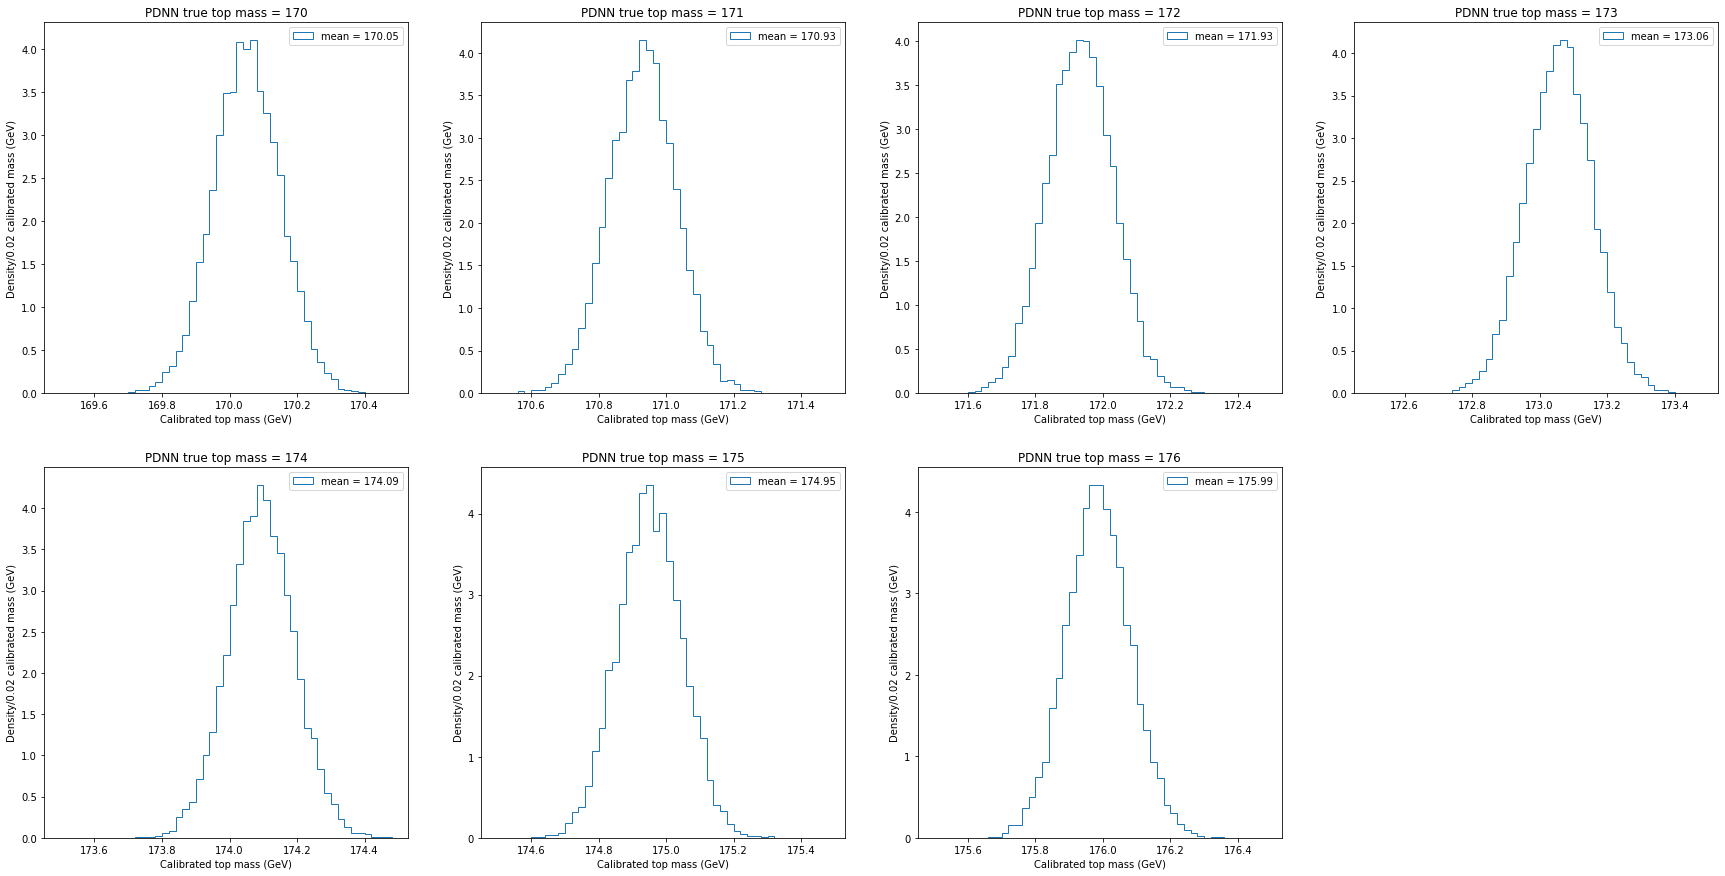

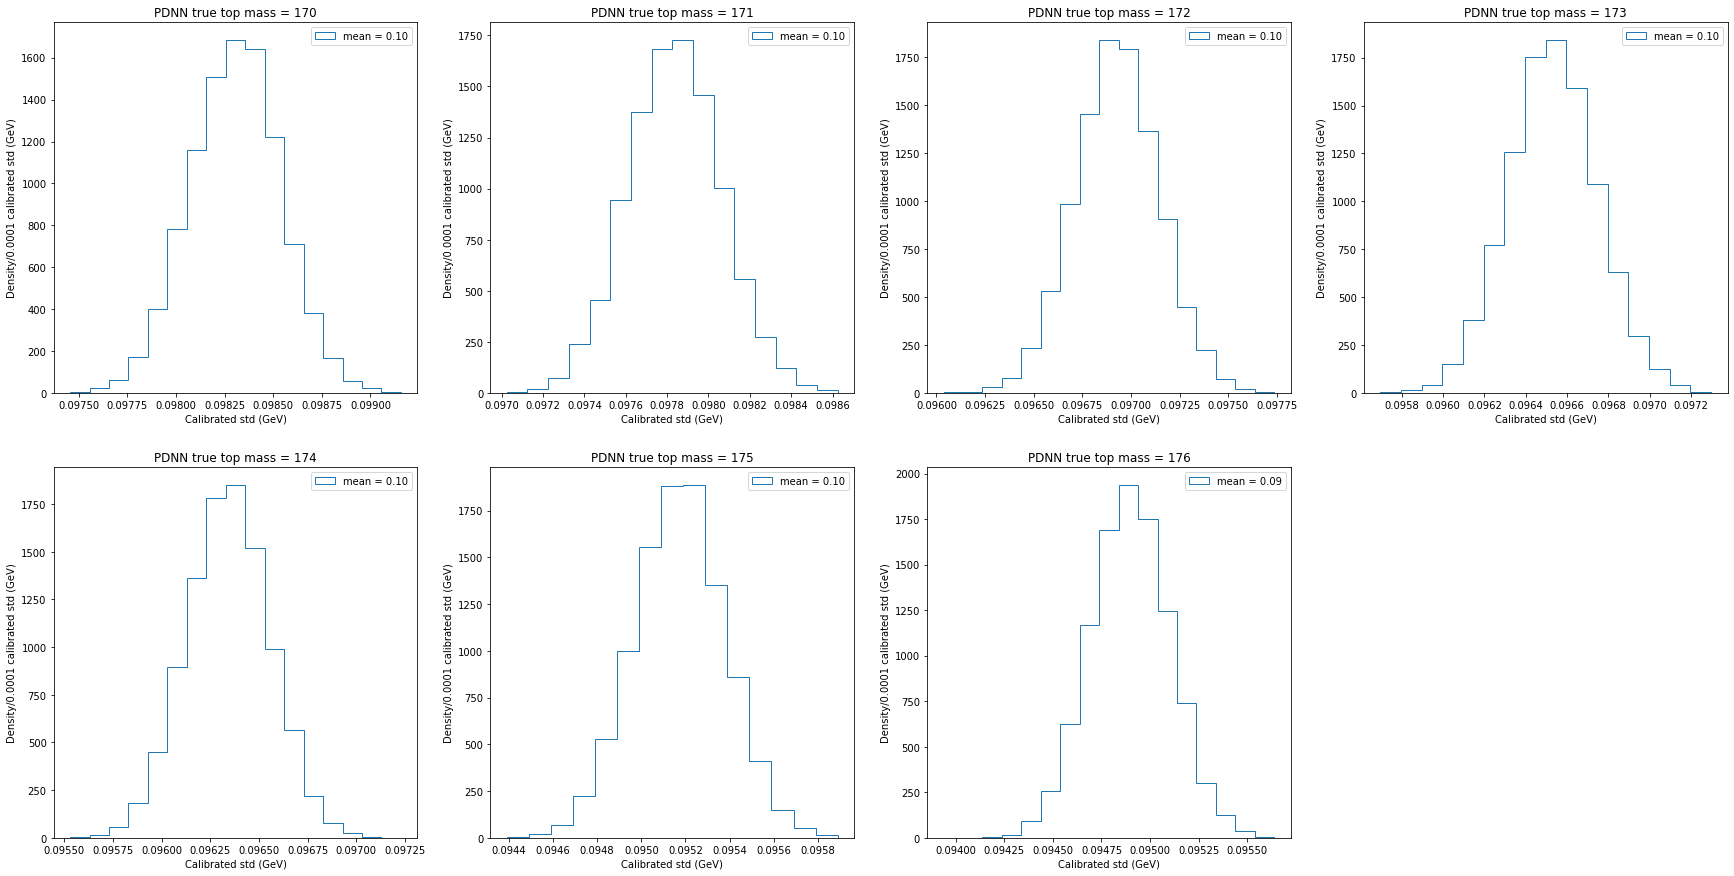

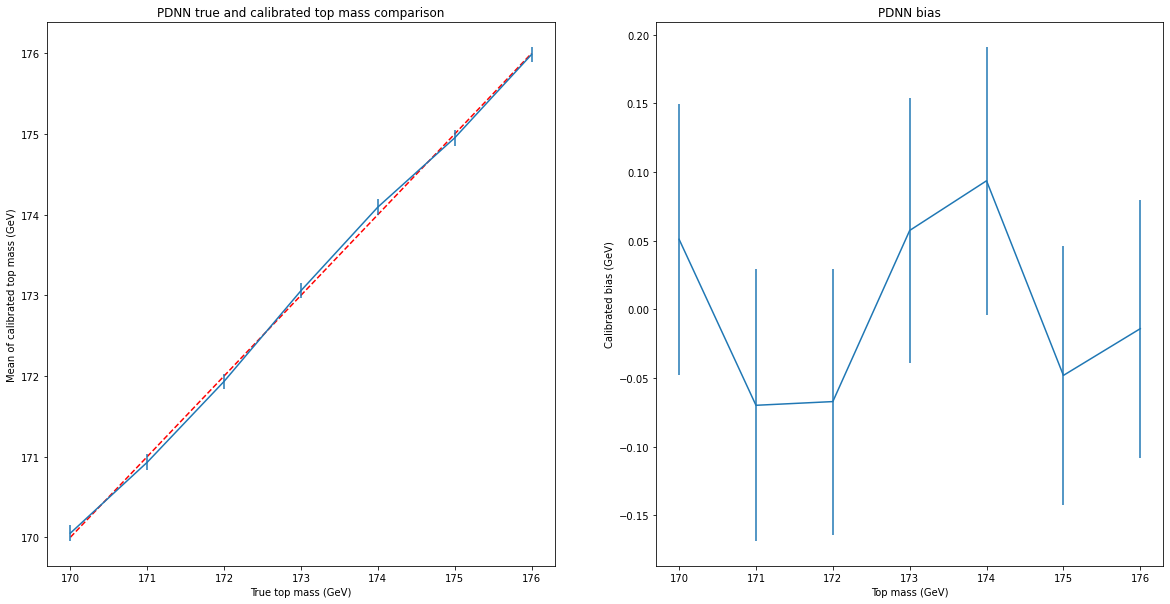

In [31]:
# Calibration of PDNN
plt.figure(figsize=(30,15))
for i, m in enumerate(mass):
    plt.subplot(2, 4, i+1)
    bins_top = np.arange(m-0.5, m+0.5, 0.02)
    plt.hist(sudo_pdnn_top_mean_dic[m], bins=bins_top, density=True, histtype='step', label=f'mean = {np.mean(sudo_pdnn_top_mean_dic[m]):.2f}')
    plt.title(f'PDNN true top mass = {m}')
    plt.xlabel('Extracted top mass (GeV)')
    plt.ylabel('Density/0.02 best fit top mass (GeV)')
    plt.legend(loc='upper right')
plt.savefig('plots_topmass/final_plots/PDNN extracted top mass histogram.png')
plt.show()

plt.figure(figsize=(30,15))
for i, m in enumerate(mass):
    plt.subplot(2, 4, i+1)
    target = sudo_pdnn_top_std_dic[m]
    bins_top = np.arange(np.min(target), np.max(target), 0.0001)
    plt.hist(target, bins=bins_top, density=True, histtype='step', label=f'mean = {np.mean(sudo_pdnn_top_std_dic[m]):.2f}')
    plt.title(f'PDNN true top mass = {m}')
    plt.xlabel('Extracted top mass std (GeV)')
    plt.ylabel('Density/0.0001 extracted top mass std (GeV)')
    plt.legend(loc='upper right')
plt.savefig('plots_topmass/final_plots/PDNN extracted top mass std histogram.png')
plt.show()

plt.figure(figsize=(30,15))
for i, m in enumerate([173]):
    plt.subplot(2, 4, i+1)
    pdnn_top_pull = (np.array(sudo_pdnn_top_mean_dic[m])-m)/sudo_pdnn_top_std_dic[m]
    hist, bin_edges = np.histogram(pdnn_top_pull, bins=np.arange(-5, 5, 0.2), density=True)
    popt, pcov = optimize.curve_fit(gau_norm, bin_edges[:-1]+0.1, hist)
    perr = np.sqrt(np.diag(pcov))
    plt.bar(bin_edges[:-1]+0.1, hist, edgecolor='b', width=0.2, color='None', label = 'Mean = {:.4f} ({:.4f}), std = {:.4f} ({:.4f})'.format(popt[0], perr[0], popt[1], perr[1]))
    pdnn_pull_mean, pdnn_pull_mean_std, pdnn_pull_sigma, pdnn_pull_sigma_std = popt[0], perr[0], popt[1], perr[1]
    plt.title('PDNN top mass pull histogram, m = 173GeV')
    plt.xlim(-5, 5)
    plt.xlabel('Top mass pull')
    plt.ylabel('Density/0.2 top mass pull')
    plt.legend(loc='upper right')
plt.savefig('plots_topmass/final_plots/PDNN top mass pull histogram, m = 173GeV.png')
plt.show()

plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.plot(mass, mass, 'r--')
plt.errorbar(mass, [np.mean(sudo_pdnn_top_mean_dic[m]) for m in mass], yerr=[np.std(sudo_pdnn_top_mean_dic[m]) for m in mass])
plt.title('PDNN true and extracted top mass comparison')
plt.xlabel('True top mass (GeV)')
plt.ylabel('Mean of extracted top mass (GeV)')
plt.subplot(1, 2, 2)
plt.errorbar(mass, [np.mean(sudo_pdnn_top_mean_dic[m])-m for m in mass], yerr=[np.std(sudo_pdnn_top_mean_dic[m]) for m in mass])
plt.title('PDNN extracted bias')
plt.xlabel('Top mass (GeV)')
plt.ylabel('Extraced bias (GeV)')
plt.savefig('plots_topmass/final_plots/PDNN extracted bias.png')
plt.show()

pdnn_popt, _ = optimize.curve_fit(linear, mass, [np.mean(sudo_pdnn_top_mean_dic[m]) for m in mass], sigma=[np.std(sudo_pdnn_top_mean_dic[m])/np.sqrt(sudo_event) for m in mass], method="lm")
def predicted_pdnn_top_func(extracted_top): return (np.array(extracted_top) - pdnn_popt[1])/pdnn_popt[0] + 173

plt.figure(figsize=(30,15))
for i, m in enumerate(mass):
    plt.subplot(2, 4, i+1)
    bins_top = np.arange(m-0.5, m+0.5, 0.02)
    x, _, _ = plt.hist(predicted_pdnn_top_func(sudo_pdnn_top_mean_dic[m]), bins=bins_top, density=True, histtype='step', label=f'mean = {predicted_pdnn_top_func(np.mean(sudo_pdnn_top_mean_dic[m])):.2f}')
    perr = np.sqrt(np.diag(pcov))
    plt.title(f'PDNN true top mass = {m}')
    plt.xlabel('Calibrated top mass (GeV)')
    plt.ylabel('Density/0.02 calibrated mass (GeV)')
    plt.legend(loc='upper right')
plt.savefig('plots_topmass/final_plots/PDNN calibrated top mass histogram.png')
plt.show()

plt.figure(figsize=(30,15))
for i, m in enumerate(mass):
    plt.subplot(2, 4, i+1)
    target = np.array(sudo_pdnn_top_std_dic[m])*pdnn_pull_sigma
    bins_top = np.arange(np.min(target), np.max(target), 0.0001)
    plt.hist(target, bins=bins_top, density=True, histtype='step', label=f'mean = {np.mean(sudo_pdnn_top_std_dic[m]):.2f}')
    plt.title(f'PDNN true top mass = {m}')
    plt.xlabel('Calibrated std (GeV)')
    plt.ylabel('Density/0.0001 calibrated std (GeV)')
    plt.legend(loc='upper right')
plt.savefig('plots_topmass/final_plots/PDNN calibrated top mass std histogram.png')
plt.show()

plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.plot(mass, mass, 'r--')
plt.errorbar(mass, [np.mean(predicted_pdnn_top_func(sudo_pdnn_top_mean_dic[m])) for m in mass], yerr=[np.std(sudo_pdnn_top_mean_dic[m]) for m in mass])
plt.title('PDNN true and calibrated top mass comparison')
plt.xlabel('True top mass (GeV)')
plt.ylabel('Mean of calibrated top mass (GeV)')
plt.subplot(1, 2, 2)
plt.errorbar(mass, [np.mean(predicted_pdnn_top_func(sudo_pdnn_top_mean_dic[m])-m) for m in mass], yerr=[np.std(sudo_pdnn_top_mean_dic[m]) for m in mass])
plt.title('PDNN bias')
plt.xlabel('Top mass (GeV)')
plt.ylabel('Calibrated bias (GeV)')
plt.savefig('plots_topmass/final_plots/PDNN calibrated bias.png')
plt.show()


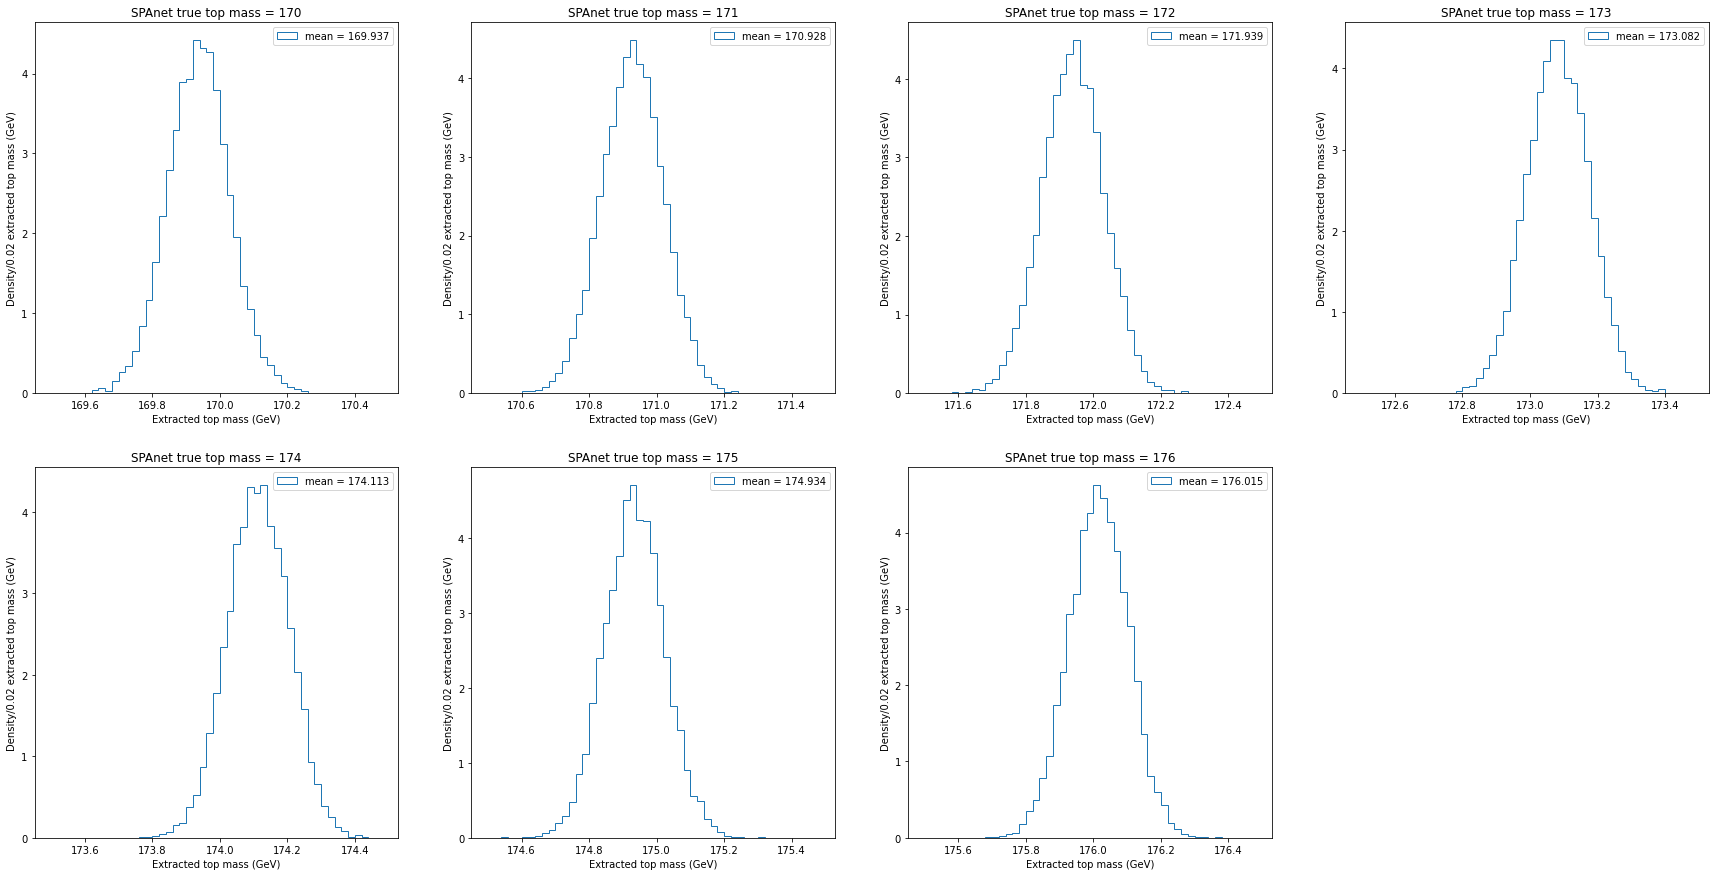

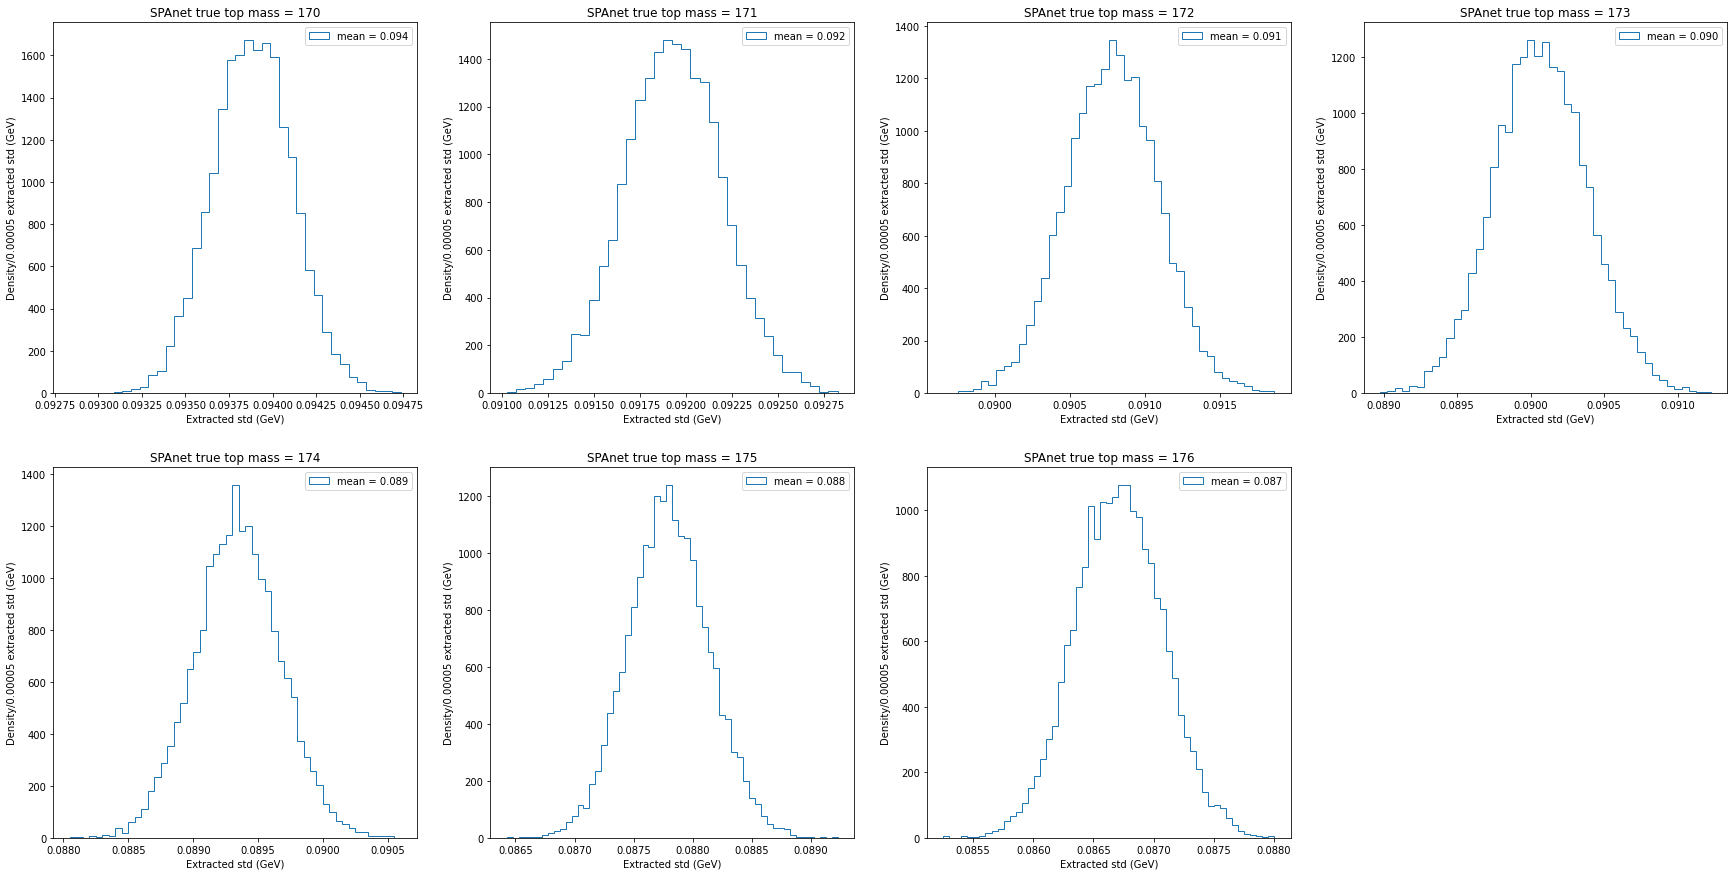

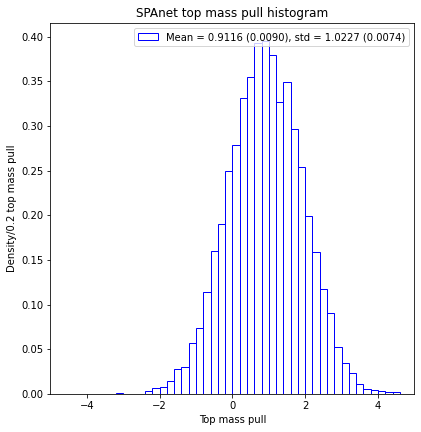

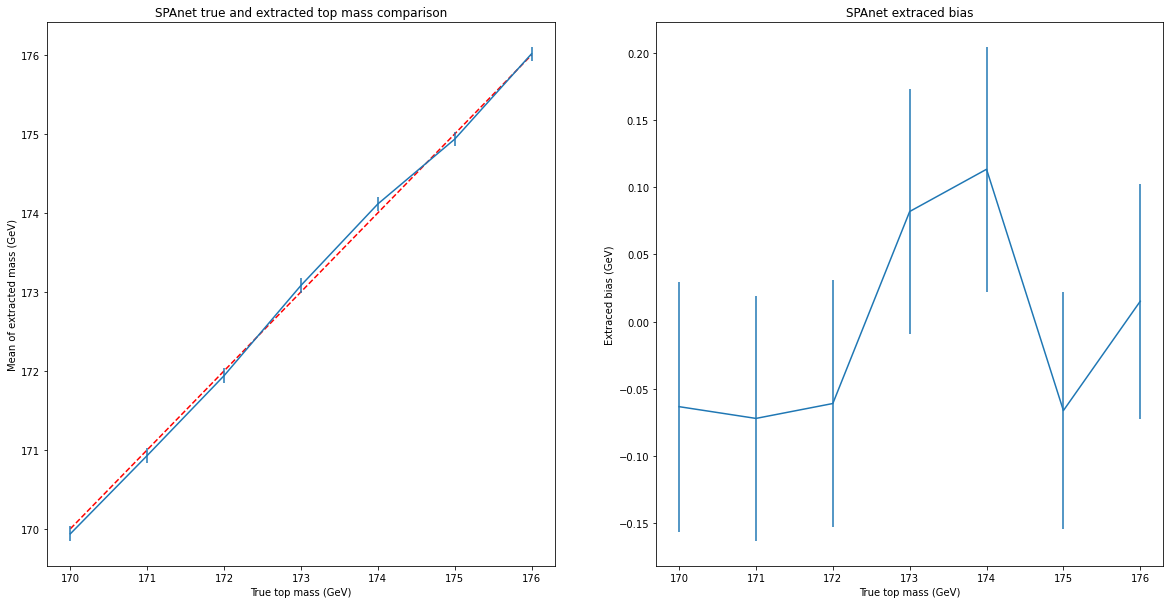

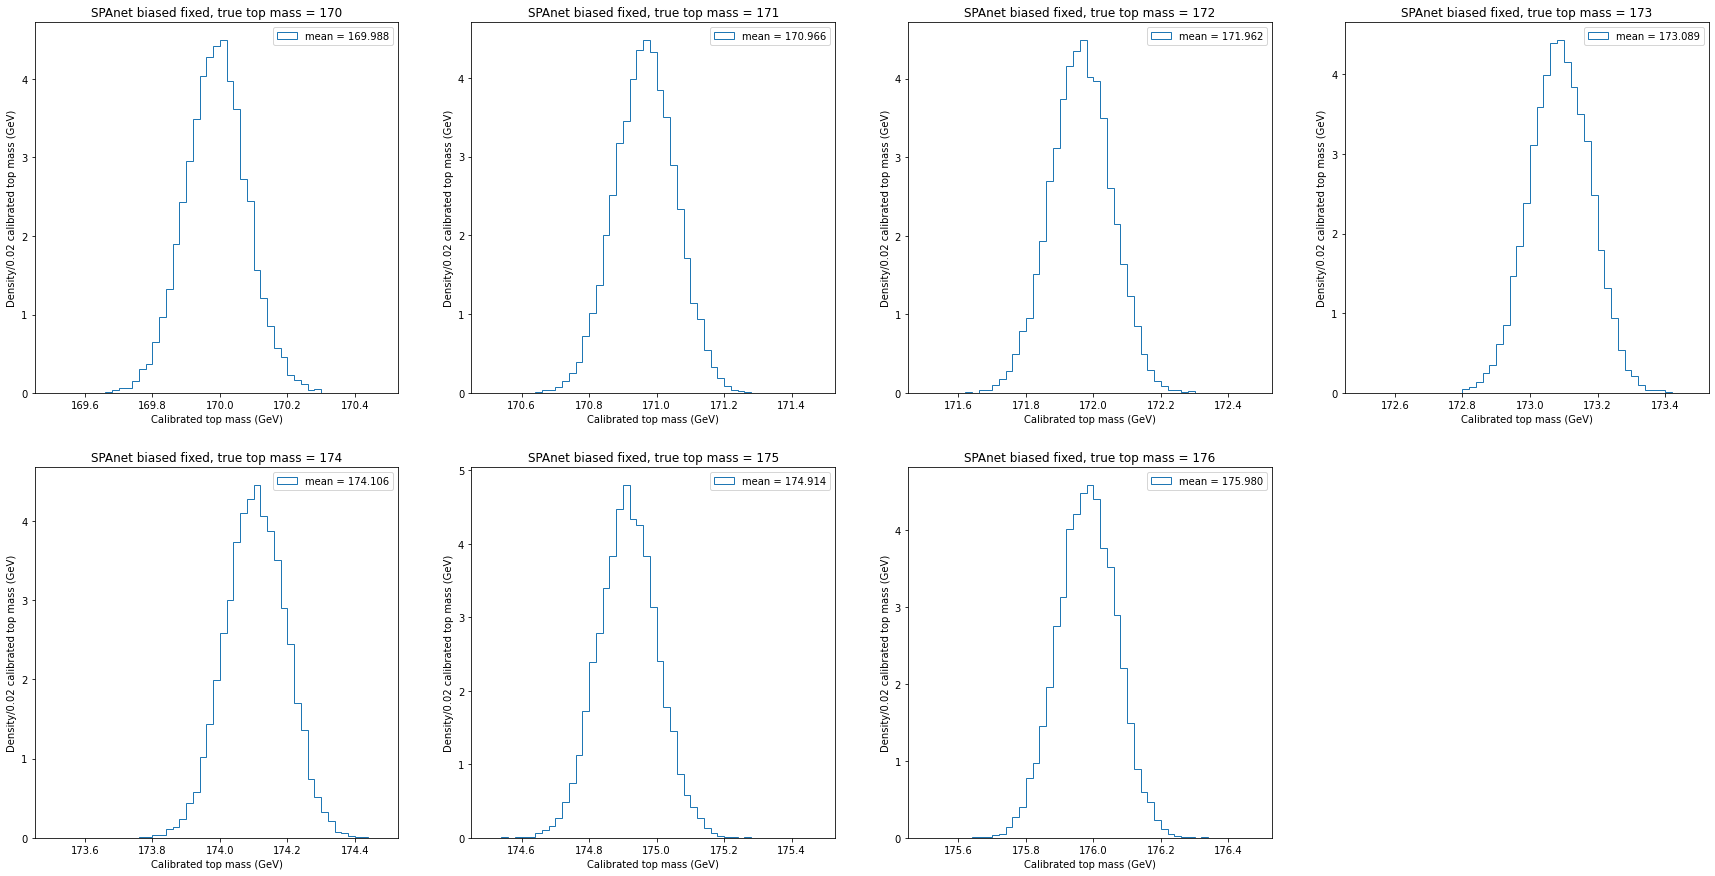

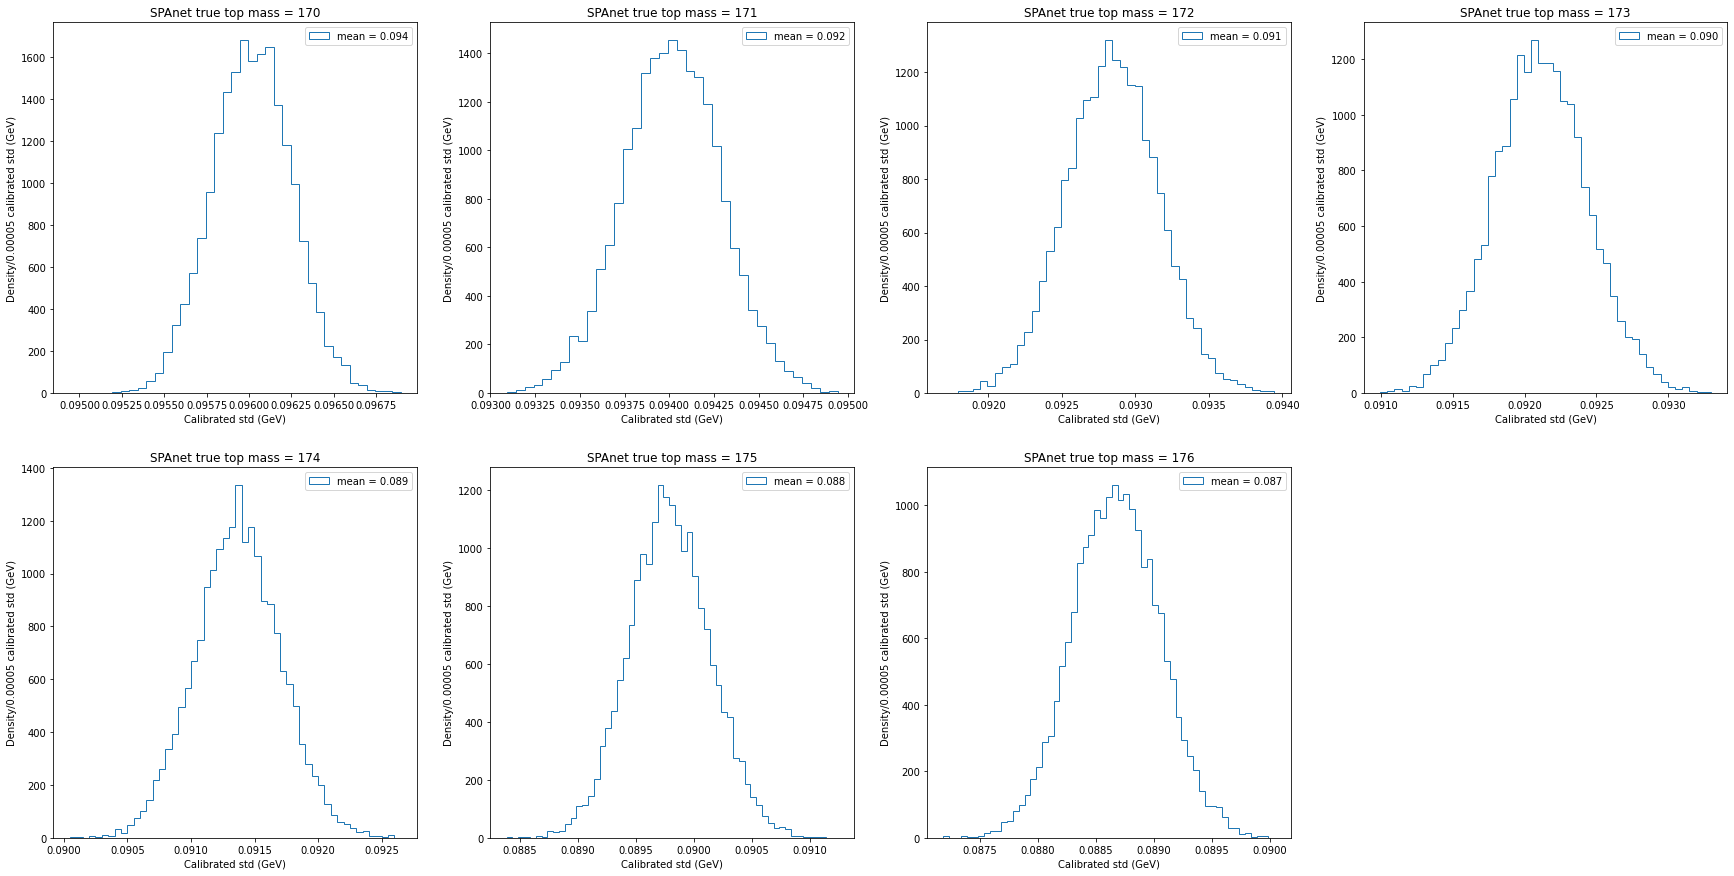

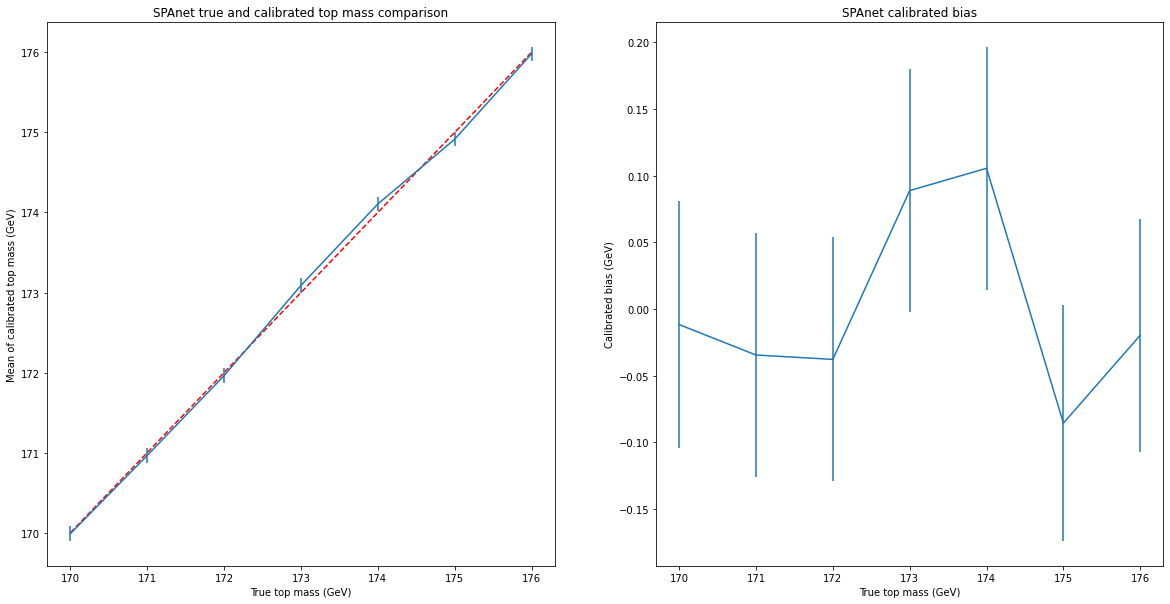

In [32]:
# Calibration of SPAnet
plt.figure(figsize=(30,15))
for i, m in enumerate(mass):
    plt.subplot(2, 4, i+1)
    bins_top = np.arange(m-0.5, m+0.5, 0.02)
    plt.hist(sudo_spanet_top_mean_dic[m], bins=bins_top, density=True, histtype='step', label=f'mean = {np.mean(sudo_spanet_top_mean_dic[m]):.3f}')
    plt.title(f'SPAnet true top mass = {m}')
    plt.xlabel('Extracted top mass (GeV)')
    plt.ylabel('Density/0.02 extracted top mass (GeV)')
    plt.legend(loc='upper right')
plt.savefig('plots_topmass/final_plots/SPAnet extracted top mass histogram.png')
plt.show()

plt.figure(figsize=(30,15))
for i, m in enumerate(mass):
    plt.subplot(2, 4, i+1)
    target = sudo_spanet_top_std_dic[m]
    bins_top = np.arange(np.min(target), np.max(target), 0.00005)
    plt.hist(sudo_spanet_top_std_dic[m], bins=bins_top, density=True, histtype='step', label=f'mean = {np.mean(sudo_spanet_top_std_dic[m]):.3f}')
    plt.title(f'SPAnet true top mass = {m}')
    plt.xlabel('Extracted std (GeV)')
    plt.ylabel('Density/0.00005 extracted std (GeV)')
    plt.legend(loc='upper right')
plt.savefig('plots_topmass/final_plots/SPAnet extracted top mass std histogram.png')
plt.show()

plt.figure(figsize=(30,15))
for i, m in enumerate([173]):
    plt.subplot(2, 4, i+1)
    spanet_top_pull = (np.array(sudo_spanet_top_mean_dic[m])-m)/sudo_spanet_top_std_dic[m]
    hist, bin_edges = np.histogram(spanet_top_pull, bins=np.arange(-5, 5, 0.2), density=True)
    popt, pcov = optimize.curve_fit(gau_norm, bin_edges[:-1]+0.1, hist)
    perr = np.sqrt(np.diag(pcov))
    plt.bar(bin_edges[:-1]+0.1, hist, edgecolor='b', width=0.2, color='None', label = 'Mean = {:.4f} ({:.4f}), std = {:.4f} ({:.4f})'.format(popt[0], perr[0], popt[1], perr[1]))
    spanet_pull_mean, spanet_pull_mean_std, spanet_pull_sigma, spanet_pull_sigma_std = popt[0], perr[0], popt[1], perr[1]
    plt.title('SPAnet top mass pull histogram')
    plt.xlim(-5, 5)
    plt.xlabel('Top mass pull')
    plt.ylabel('Density/0.2 top mass pull')
    plt.legend(loc='upper right')
plt.savefig('plots_topmass/final_plots/SPAnet top mass pull histogram, m = 173GeV.png')
plt.show()

plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.plot(mass, mass, 'r--')
plt.errorbar(mass, [np.mean(sudo_spanet_top_mean_dic[m]) for m in mass], yerr=[np.std(sudo_spanet_top_mean_dic[m]) for m in mass])
plt.title('SPAnet true and extracted top mass comparison')
plt.xlabel('True top mass (GeV)')
plt.ylabel('Mean of extracted mass (GeV)')
plt.subplot(1, 2, 2)
plt.errorbar(mass, [np.mean(sudo_spanet_top_mean_dic[m])-m for m in mass], yerr=[np.std(sudo_spanet_top_mean_dic[m]) for m in mass])
plt.title('SPAnet extraced bias')
plt.xlabel('True top mass (GeV)')
plt.ylabel('Extraced bias (GeV)')
plt.savefig('plots_topmass/final_plots/KLFitter extracted bias.png')
plt.show()

spanet_top_popt, _ = optimize.curve_fit(linear, mass, [np.mean(sudo_spanet_top_mean_dic[m]) for m in mass], sigma=[np.std(sudo_spanet_top_mean_dic[m])/np.sqrt(sudo_event) for m in mass], method="lm")
def predicted_spanet_top_func(extracted_top): return (np.array(extracted_top) - spanet_top_popt[1])/spanet_top_popt[0] + 173

plt.figure(figsize=(30,15))
for i, m in enumerate(mass):
    plt.subplot(2, 4, i+1)
    plt.hist(predicted_spanet_top_func(sudo_spanet_top_mean_dic[m]), bins=np.arange(m-0.5, m+0.5, 0.02), density=True, histtype='step', label=f'mean = {predicted_spanet_top_func(np.mean(sudo_spanet_top_mean_dic[m])):.3f}')
    plt.title(f'SPAnet biased fixed, true top mass = {m}')
    plt.xlabel('Calibrated top mass (GeV)')
    plt.ylabel('Density/0.02 calibrated top mass (GeV)')
    plt.legend(loc='upper right')
plt.savefig('plots_topmass/final_plots/SPAnet calibrated top mass histogram.png')
plt.show()

plt.figure(figsize=(30,15))
for i, m in enumerate(mass):
    plt.subplot(2, 4, i+1)
    target = np.array(sudo_spanet_top_std_dic[m])*spanet_pull_sigma
    bins_top = np.arange(np.min(target), np.max(target), 0.00005)
    plt.hist(target, bins=bins_top, density=True, histtype='step', label=f'mean = {np.mean(sudo_spanet_top_std_dic[m]):.3f}')
    plt.title(f'SPAnet true top mass = {m}')
    plt.xlabel('Calibrated std (GeV)')
    plt.ylabel('Density/0.00005 calibrated std (GeV)')
    plt.legend(loc='upper right')
plt.savefig('plots_topmass/final_plots/SPAnet calibrated top mass std histogram.png')
plt.show()

plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.plot(mass, mass, 'r--')
plt.errorbar(mass, [np.mean(predicted_spanet_top_func(sudo_spanet_top_mean_dic[m])) for m in mass], yerr=[np.std(sudo_spanet_top_mean_dic[m]) for m in mass])
plt.title('SPAnet true and calibrated top mass comparison')
plt.xlabel('True top mass (GeV)')
plt.ylabel('Mean of calibrated top mass (GeV)')
plt.subplot(1, 2, 2)
plt.errorbar(mass, [np.mean(predicted_spanet_top_func(sudo_spanet_top_mean_dic[m]))-m for m in mass], yerr=[np.std(sudo_spanet_top_mean_dic[m]) for m in mass])
plt.title('SPAnet calibrated bias')
plt.xlabel('True top mass (GeV)')
plt.ylabel('Calibrated bias (GeV)')
plt.savefig('plots_topmass/final_plots/KLFitter calibrated bias.png')
plt.show()

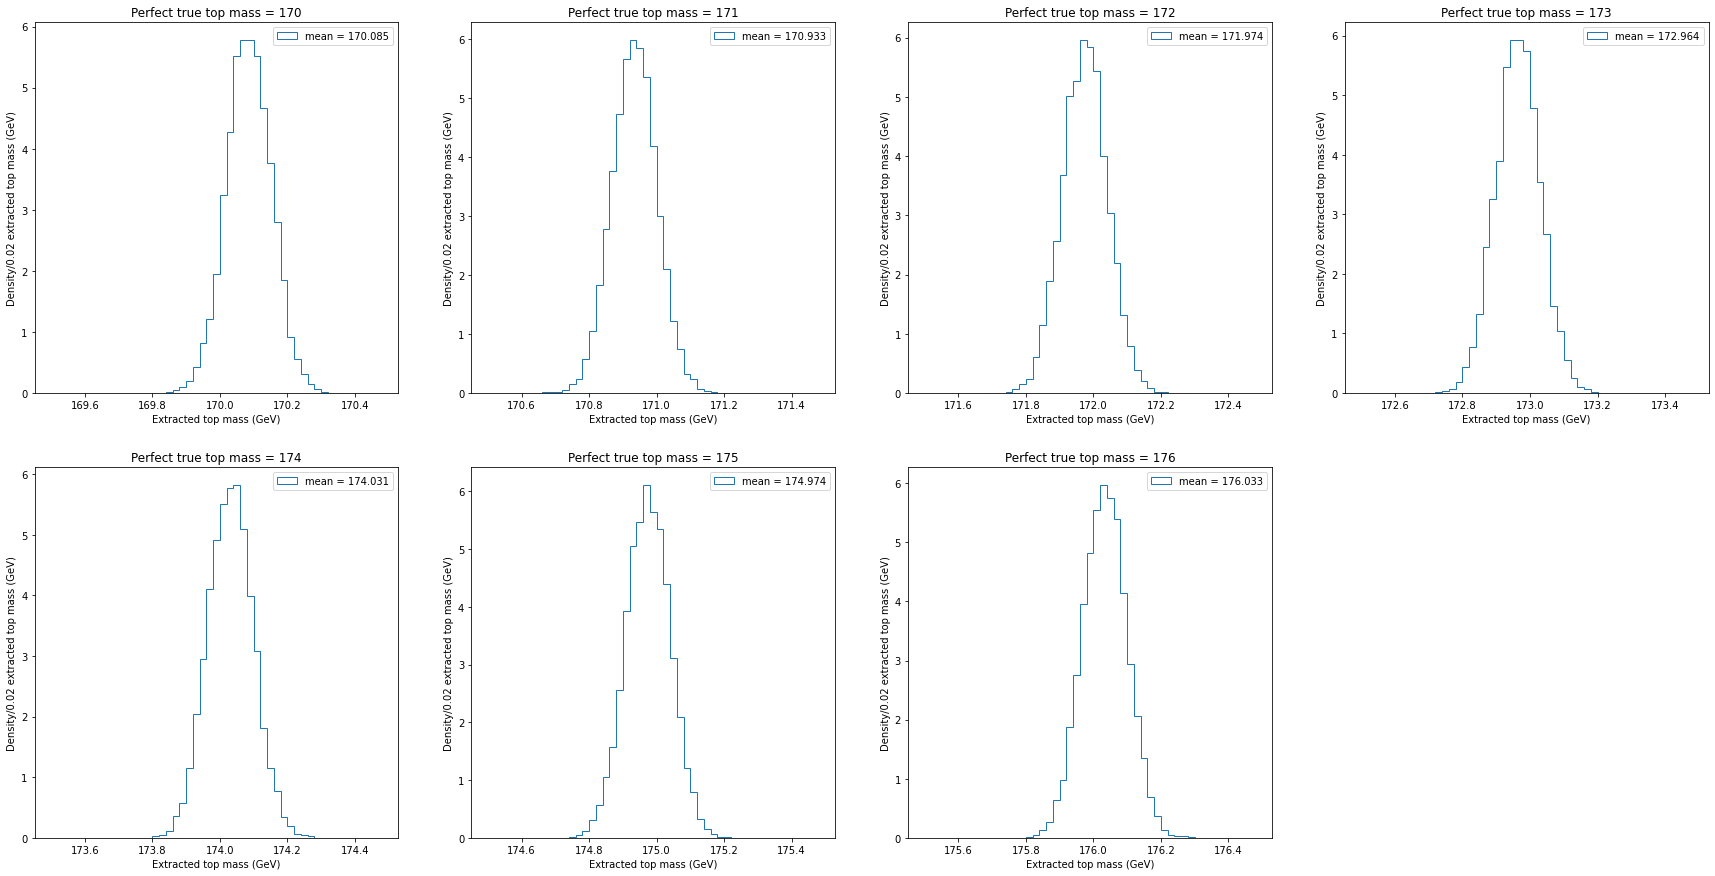

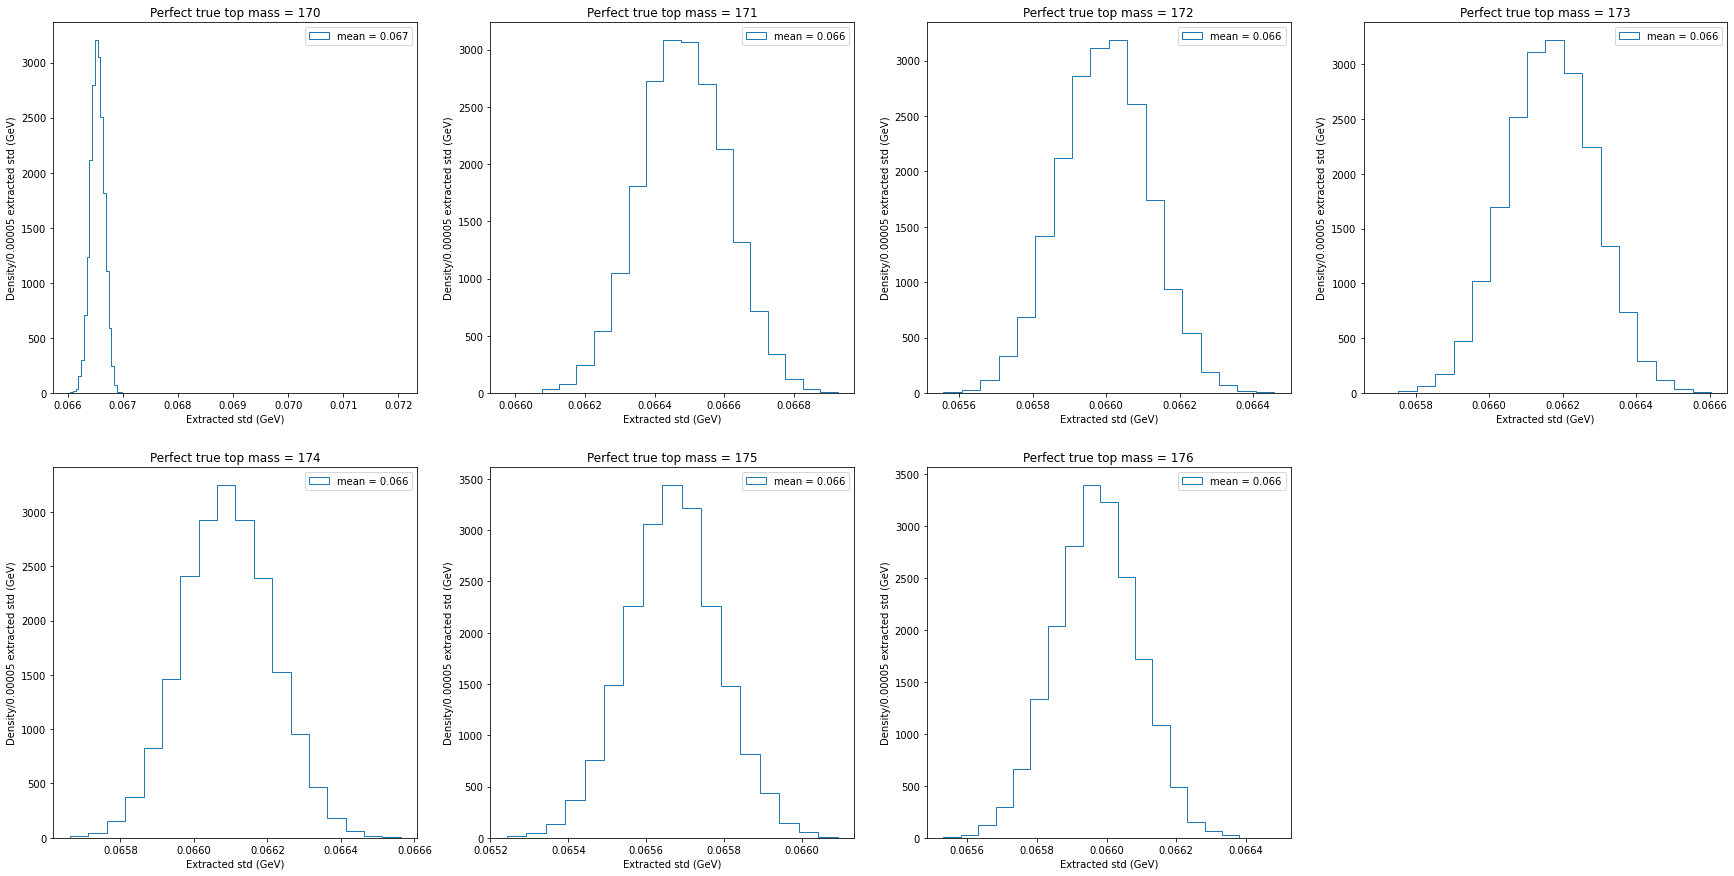

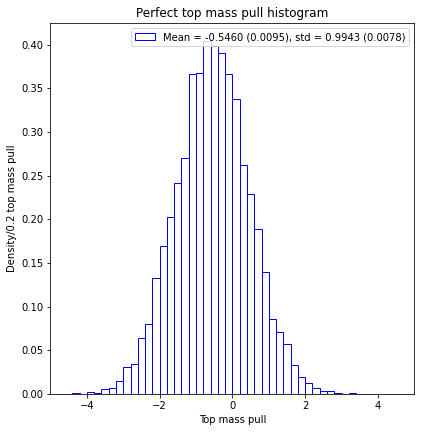

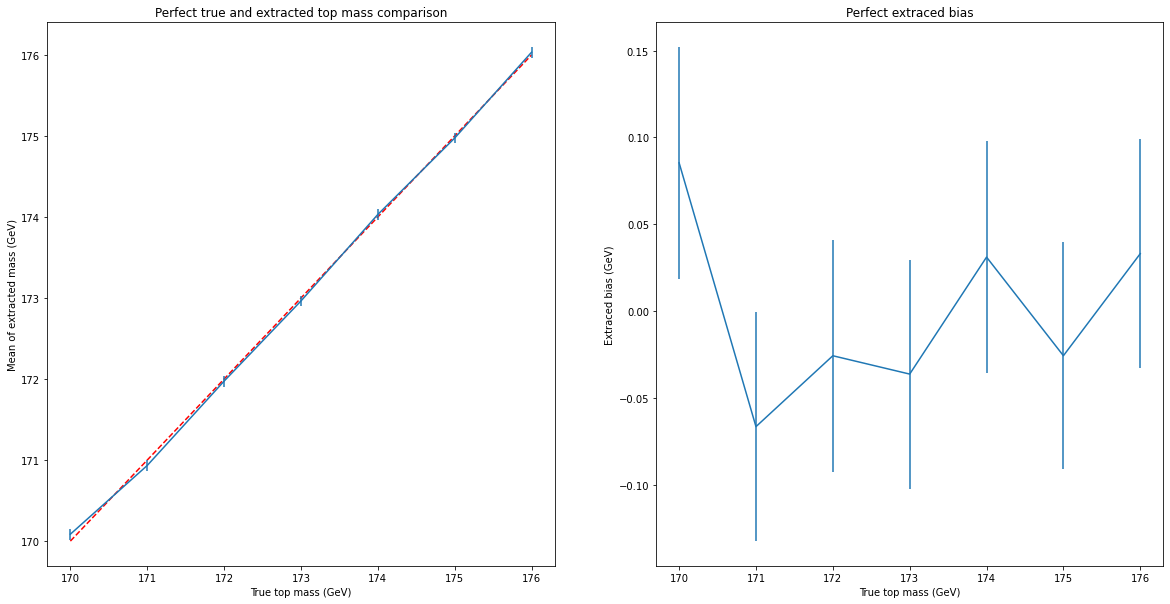

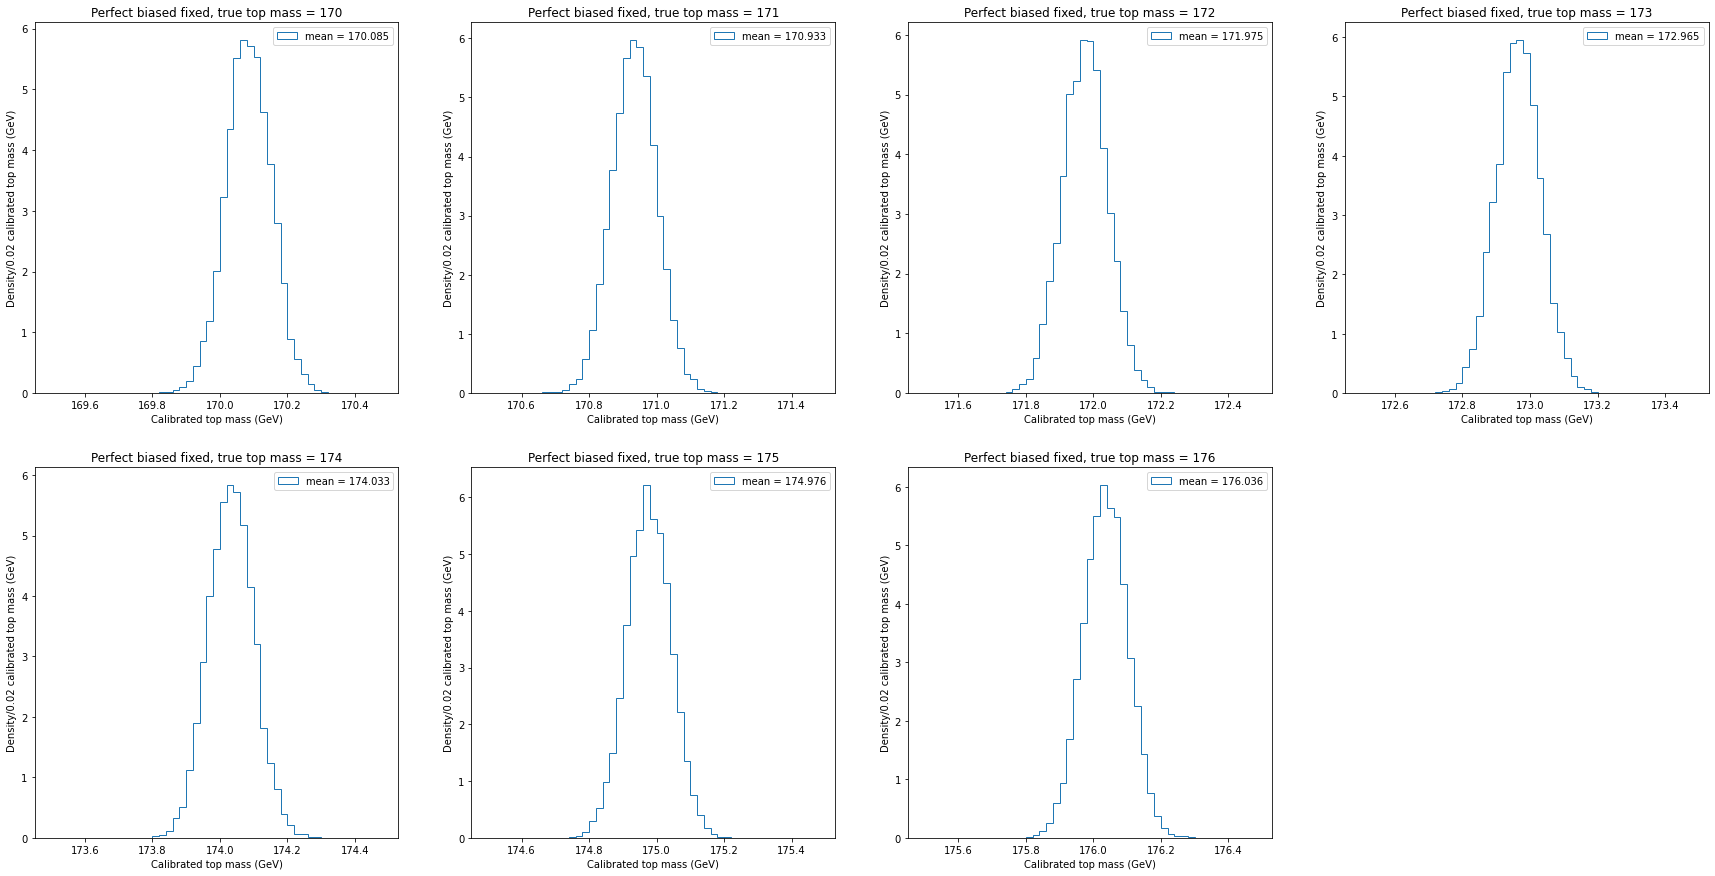

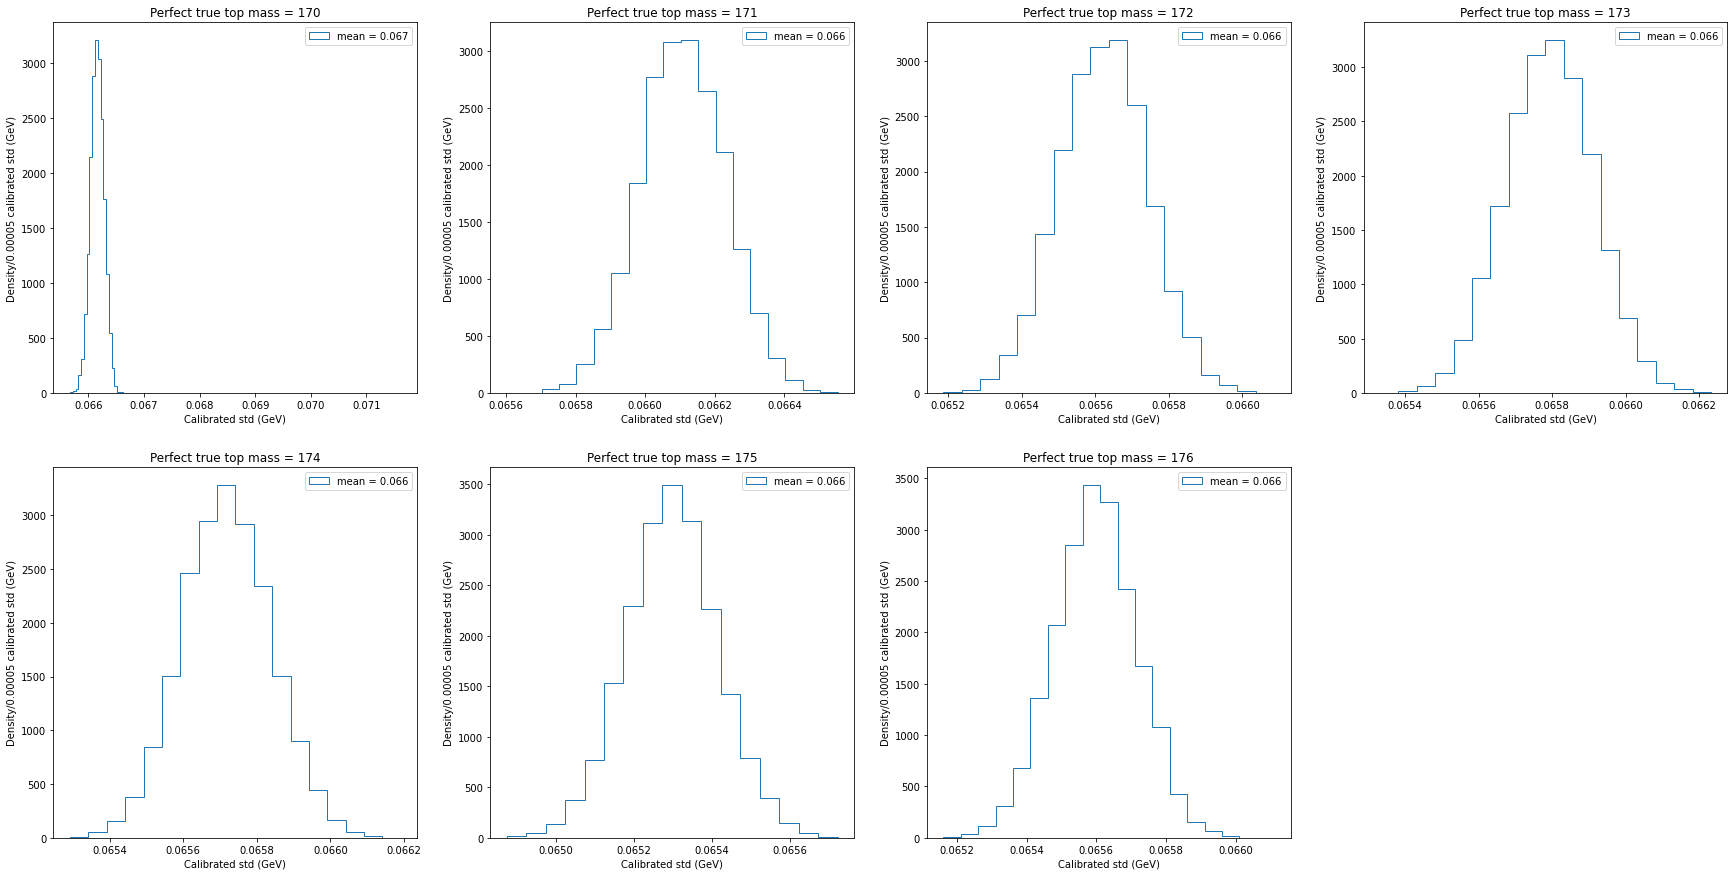

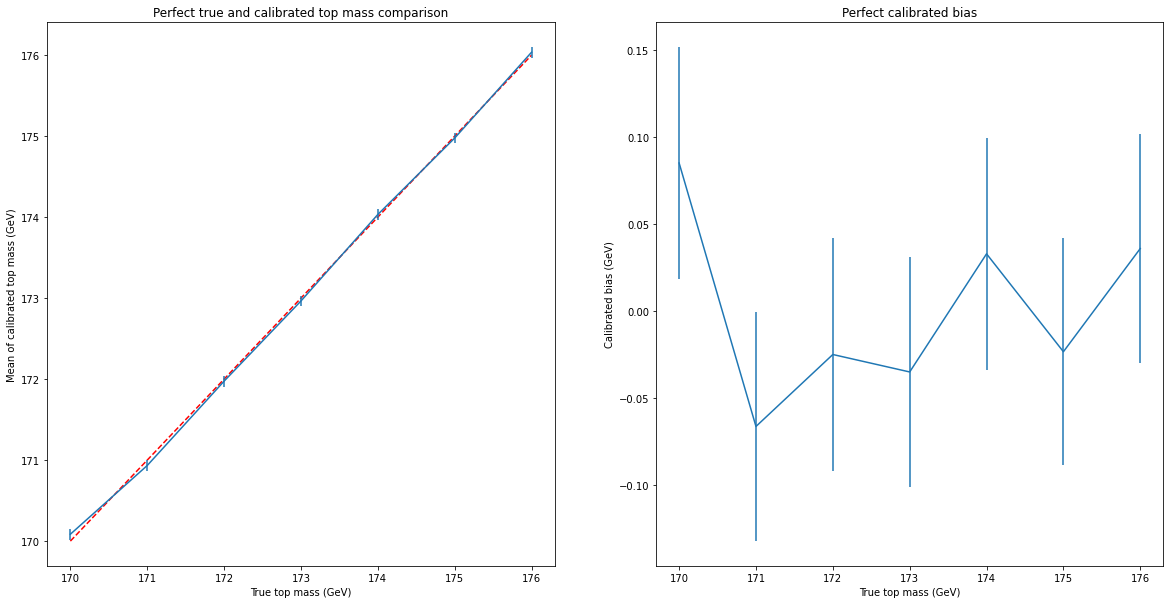

In [33]:
# Calibration of Perfect
plt.figure(figsize=(30,15))
for i, m in enumerate(mass):
    plt.subplot(2, 4, i+1)
    bins_top = np.arange(m-0.5, m+0.5, 0.02)
    plt.hist(sudo_perfect_top_mean_dic[m], bins=bins_top, density=True, histtype='step', label=f'mean = {np.mean(sudo_perfect_top_mean_dic[m]):.3f}')
    plt.title(f'Perfect true top mass = {m}')
    plt.xlabel('Extracted top mass (GeV)')
    plt.ylabel('Density/0.02 extracted top mass (GeV)')
    plt.legend(loc='upper right')
plt.savefig('plots_topmass/final_plots/Perfect extracted top mass histogram.png')
plt.show()

plt.figure(figsize=(30,15))
for i, m in enumerate(mass):
    plt.subplot(2, 4, i+1)
    target = sudo_perfect_top_std_dic[m]
    bins_top = np.arange(np.min(target), np.max(target), 0.00005)
    plt.hist(sudo_perfect_top_std_dic[m], bins=bins_top, density=True, histtype='step', label=f'mean = {np.mean(sudo_perfect_top_std_dic[m]):.3f}')
    plt.title(f'Perfect true top mass = {m}')
    plt.xlabel('Extracted std (GeV)')
    plt.ylabel('Density/0.00005 extracted std (GeV)')
    plt.legend(loc='upper right')
plt.savefig('plots_topmass/final_plots/Perfect extracted top mass std histogram.png')
plt.show()

plt.figure(figsize=(30,15))
for i, m in enumerate([173]):
    plt.subplot(2, 4, i+1)
    perfect_top_pull = (np.array(sudo_perfect_top_mean_dic[m])-m)/sudo_perfect_top_std_dic[m]
    hist, bin_edges = np.histogram(perfect_top_pull, bins=np.arange(-5, 5, 0.2), density=True)
    popt, pcov = optimize.curve_fit(gau_norm, bin_edges[:-1]+0.1, hist)
    perr = np.sqrt(np.diag(pcov))
    plt.bar(bin_edges[:-1]+0.1, hist, edgecolor='b', width=0.2, color='None', label = 'Mean = {:.4f} ({:.4f}), std = {:.4f} ({:.4f})'.format(popt[0], perr[0], popt[1], perr[1]))
    perfect_pull_mean, perfect_pull_mean_std, perfect_pull_sigma, perfect_pull_sigma_std = popt[0], perr[0], popt[1], perr[1]
    plt.title('Perfect top mass pull histogram')
    plt.xlim(-5, 5)
    plt.xlabel('Top mass pull')
    plt.ylabel('Density/0.2 top mass pull')
    plt.legend(loc='upper right')
plt.savefig('plots_topmass/final_plots/Perfect top mass pull histogram, m = 173GeV.png')
plt.show()

plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.plot(mass, mass, 'r--')
plt.errorbar(mass, [np.mean(sudo_perfect_top_mean_dic[m]) for m in mass], yerr=[np.std(sudo_perfect_top_mean_dic[m]) for m in mass])
plt.title('Perfect true and extracted top mass comparison')
plt.xlabel('True top mass (GeV)')
plt.ylabel('Mean of extracted mass (GeV)')
plt.subplot(1, 2, 2)
plt.errorbar(mass, [np.mean(sudo_perfect_top_mean_dic[m])-m for m in mass], yerr=[np.std(sudo_perfect_top_mean_dic[m]) for m in mass])
plt.title('Perfect extraced bias')
plt.xlabel('True top mass (GeV)')
plt.ylabel('Extraced bias (GeV)')
plt.savefig('plots_topmass/final_plots/KLFitter extracted bias.png')
plt.show()

perfect_top_popt, _ = optimize.curve_fit(linear, mass, [np.mean(sudo_perfect_top_mean_dic[m]) for m in mass], sigma=[np.std(sudo_perfect_top_mean_dic[m])/np.sqrt(sudo_event) for m in mass], method="lm")
def predicted_perfect_top_func(extracted_top): return (np.array(extracted_top) - perfect_top_popt[1])/perfect_top_popt[0] + 173

plt.figure(figsize=(30,15))
for i, m in enumerate(mass):
    plt.subplot(2, 4, i+1)
    plt.hist(predicted_perfect_top_func(sudo_perfect_top_mean_dic[m]), bins=np.arange(m-0.5, m+0.5, 0.02), density=True, histtype='step', label=f'mean = {predicted_perfect_top_func(np.mean(sudo_perfect_top_mean_dic[m])):.3f}')
    plt.title(f'Perfect biased fixed, true top mass = {m}')
    plt.xlabel('Calibrated top mass (GeV)')
    plt.ylabel('Density/0.02 calibrated top mass (GeV)')
    plt.legend(loc='upper right')
plt.savefig('plots_topmass/final_plots/Perfect calibrated top mass histogram.png')
plt.show()

plt.figure(figsize=(30,15))
for i, m in enumerate(mass):
    plt.subplot(2, 4, i+1)
    target = np.array(sudo_perfect_top_std_dic[m])*perfect_pull_sigma
    bins_top = np.arange(np.min(target), np.max(target), 0.00005)
    plt.hist(np.array(sudo_perfect_top_std_dic[m])*perfect_pull_sigma, bins=bins_top, density=True, histtype='step', label=f'mean = {np.mean(sudo_perfect_top_std_dic[m]):.3f}')
    plt.title(f'Perfect true top mass = {m}')
    plt.xlabel('Calibrated std (GeV)')
    plt.ylabel('Density/0.00005 calibrated std (GeV)')
    plt.legend(loc='upper right')
plt.savefig('plots_topmass/final_plots/Perfect calibrated top mass std histogram.png')
plt.show()

plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.plot(mass, mass, 'r--')
plt.errorbar(mass, [np.mean(predicted_perfect_top_func(sudo_perfect_top_mean_dic[m])) for m in mass], yerr=[np.std(sudo_perfect_top_mean_dic[m]) for m in mass])
plt.title('Perfect true and calibrated top mass comparison')
plt.xlabel('True top mass (GeV)')
plt.ylabel('Mean of calibrated top mass (GeV)')
plt.subplot(1, 2, 2)
plt.errorbar(mass, [np.mean(predicted_perfect_top_func(sudo_perfect_top_mean_dic[m]))-m for m in mass], yerr=[np.std(sudo_perfect_top_mean_dic[m]) for m in mass])
plt.title('Perfect calibrated bias')
plt.xlabel('True top mass (GeV)')
plt.ylabel('Calibrated bias (GeV)')
plt.savefig('plots_topmass/final_plots/KLFitter calibrated bias.png')
plt.show()

In [34]:
def chi2_klf_arr_func(m):
    return -2*np.sum(n1*(np.log(combine_klf_pdf_func(bins_mid, m)*len(n1)*bins_w)))*klf_pull_sigma

def chi2_pdnn_arr_func(m):
    return -2*np.sum(n1*(np.log(combine_pdnn_pdf_func(bins_mid, m)*len(n1)*bins_w)))*pdnn_pull_sigma

def chi2_spanet_arr_func(m):
    return -2*np.sum(n1*(np.log(combine_spanet_pdf_func(bins_mid, m)*len(n1)*bins_w)))*spanet_pull_sigma

def chi2_perfect_arr_func(m):
    return -2*np.sum(n1*(np.log(combine_perfect_pdf_func(bins_mid, m)*len(n1)*bins_w)))*perfect_pull_sigma

In [35]:
# Fixed the bins, colors, mass arr, and labels for all plots.
# 1. bins related parameters (reconstucted top mass)
bins_width = 1
top_bins_min, top_bins_max = 120, 230
top_bins = np.arange(top_bins_min, top_bins_max+1, bins_width)
top_bins_mid = top_bins[:-1]+bins_width/2
top_bins_dense = np.linspace(top_bins_min, top_bins_max, 1000)

# 2. bins related parameters (reconstucted W mass)
W_bins_min, W_bins_max = 40, 120
W_bins = np.arange(W_bins_min, W_bins_max+1, bins_width)
W_bins_mid = W_bins[:-1]+bins_width/2
W_bins_dense = np.linspace(W_bins_min, W_bins_max, 1000)

# 3. True top mass related parameters
mass = [170, 171, 172, 173, 174, 175, 176]
top_mass_dense = np.linspace(170, 176, 1000)

# 4. JSF related parameters
JSF_arr = [0.96, 1.0, 1.04]
JSF_dense = np.linspace(0.96, 1.04, 1000)

# 5. Other paramters
loglikeli_cut = -70
assignmment_cut = 0.12
marginal_prob_cut = 0.23
pseudo_event = 10000

# 6. Settings
states = [0, 1, 2]
state_labels = ['Unmatched', 'Incorrect', 'Correct']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
langau_fit_labels = ['Peak of Landau', 'Width of Landau', 'Mean of Gaussian', 'Variance of Gaussian', 'Fraction of Gaussian']
twogau_fit_labels = ['Mean of first Gaussian', 'Variance of first Gaussian', 'Mean of second Gaussian', 'Variance of second Gaussian', 'Fraction of second Gaussian']


In [36]:
def get_reco_mass(h5py_file, target, JSF): # Target is spanet or klfitter
    dic = {}

    #Load pt, eta, phi, and mass from file. Where q1, q2 and b are the index.
    q1 = np.array([[i] for i in h5py_file[target + '/right_target/q1'][:]])
    dic['q1_pt'] = np.take_along_axis(h5py_file['jet_features/pt'][:], q1, axis=1).flatten()
    dic['q1_eta'] = np.take_along_axis(h5py_file['jet_features/eta'][:], q1, axis=1).flatten()
    dic['q1_phi'] = np.take_along_axis(h5py_file['jet_features/phi'][:], q1, axis=1).flatten()
    dic['q1_mass'] = np.take_along_axis(h5py_file['jet_features/mass'][:], q1, axis=1).flatten()

    q2 = np.array([[i] for i in h5py_file[target + '/right_target/q2'][:]])
    dic['q2_pt'] = np.take_along_axis(h5py_file['jet_features/pt'][:], q2, axis=1).flatten()
    dic['q2_eta'] = np.take_along_axis(h5py_file['jet_features/eta'][:], q2, axis=1).flatten()
    dic['q2_phi'] = np.take_along_axis(h5py_file['jet_features/phi'][:], q2, axis=1).flatten()
    dic['q2_mass'] = np.take_along_axis(h5py_file['jet_features/mass'][:], q2, axis=1).flatten()

    b = np.array([[i] for i in h5py_file[target + '/right_target/b'][:]])
    dic['b_pt'] = np.take_along_axis(h5py_file['jet_features/pt'][:], b, axis=1).flatten()
    dic['b_eta'] = np.take_along_axis(h5py_file['jet_features/eta'][:], b, axis=1).flatten()
    dic['b_phi'] = np.take_along_axis(h5py_file['jet_features/phi'][:], b, axis=1).flatten()
    dic['b_mass'] = np.take_along_axis(h5py_file['jet_features/mass'][:], b, axis=1).flatten()
    
    # px = pt*cos(phi)*JSF
    # py = pt*sin(phi)*JSF
    # pz = pt*sinh(eta)*JSF
    # E  = sqrt(m**2 + px**2 + py**2 + pz**2)
    dic['px1'] = dic['q1_pt']*np.cos(dic['q1_phi'])*JSF
    dic['py1'] = dic['q1_pt']*np.sin(dic['q1_phi'])*JSF
    dic['pz1'] = dic['q1_pt']*np.sinh(dic['q1_eta'])*JSF
    dic['E1'] = np.sqrt(dic['q1_mass']**2+dic['px1']**2+dic['py1']**2+dic['pz1']**2)

    dic['px2'] = dic['q2_pt']*np.cos(dic['q2_phi'])*JSF
    dic['py2'] = dic['q2_pt']*np.sin(dic['q2_phi'])*JSF
    dic['pz2'] = dic['q2_pt']*np.sinh(dic['q2_eta'])*JSF
    dic['E2'] = np.sqrt(dic['q2_mass']**2+dic['px2']**2+dic['py2']**2+dic['pz2']**2)

    dic['bx'] = dic['b_pt']*np.cos(dic['b_phi'])*JSF
    dic['by'] = dic['b_pt']*np.sin(dic['b_phi'])*JSF
    dic['bz'] = dic['b_pt']*np.sinh(dic['b_eta'])*JSF
    dic['bE'] = np.sqrt(dic['b_mass']**2+dic['bx']**2+dic['by']**2+dic['bz']**2)
    
    # M = sqrt((m1+m2)**2 + (px1+px2)**2 + (py1+py2)**2 + (pz1+pz2)**2)
    dic['reconstructed_W_mass'] = np.sqrt((dic['E1']+dic['E2'])**2
                    - (dic['px1']+dic['px2'])**2
                    - (dic['py1']+dic['py2'])**2
                    - (dic['pz1']+dic['pz2'])**2)
    
    dic['reconstructed_top_mass'] = np.sqrt((dic['E1']+dic['E2']+dic['bE'])**2
                    - (dic['px1']+dic['px2']+dic['bx'])**2
                    - (dic['py1']+dic['py2']+dic['by'])**2
                    - (dic['pz1']+dic['pz2']+dic['bz'])**2)

    """
    cuts
    top_bins_min < reco_m_top < top_bins_max
    W_bins_min < reco_W_top < W_bins_max
    """
    reco_cuts = np.logical_and.reduce((dic['reconstructed_top_mass'] > top_bins_min, dic['reconstructed_top_mass'] < top_bins_max))
    
    # Check the state of the event.
    state = [1]*len(h5py_file['target/right_target/q1'][:])

    # Two permutations for q1 and q2.
    permu1 = np.logical_and(h5py_file['target/right_target/q1'][:] == h5py_file[target + '/right_target/q1'][:], 
                        h5py_file['target/right_target/q2'][:] == h5py_file[target + '/right_target/q2'][:])
    permu2 = np.logical_and(h5py_file['target/right_target/q1'][:] == h5py_file[target + '/right_target/q2'][:], 
                        h5py_file['target/right_target/q2'][:] == h5py_file[target + '/right_target/q1'][:])
    correct = np.logical_and(np.logical_or(permu1, permu2), h5py_file['target/right_target/b'][:] == h5py_file[target + '/right_target/b'][:])
    state = np.where(correct, 2, state)

    # Check for unmatch
    unmatch = np.logical_or.reduce((h5py_file['target/right_target/q1'][:] == -1,
                        h5py_file['target/right_target/q2'][:] == -1,
                        h5py_file['target/right_target/b'][:] == -1))
    state = np.where(unmatch, 0, state)
    if target == 'klfitter': return dic['reconstructed_top_mass'], dic['reconstructed_W_mass'], state, reco_cuts, h5py_file['klfitter/score/loglikelihood'][:]>loglikeli_cut
    elif target == 'permutation_dnn': return dic['reconstructed_top_mass'], dic['reconstructed_W_mass'], state, reco_cuts, h5py_file['permutation_dnn/assignment_score'][:]>assignmment_cut
    elif target == 'spanet': return dic['reconstructed_top_mass'], dic['reconstructed_W_mass'], state, reco_cuts, h5py_file['spanet/right_target/marginal_probability'][:]>marginal_prob_cut
    else: return dic['reconstructed_top_mass'], dic['reconstructed_W_mass'], state, reco_cuts


In [37]:
# The reco_top_mss from ttbar_testing_mass_variation
# 0 for unmatched, 1 for incorrect, 2 for correct
reco_klf_dic, W_klf_dic, state_klf_dic, cut_klf_dic, likeli_klf_dic = {}, {}, {}, {}, {}
reco_pdnn_dic, W_pdnn_dic, state_pdnn_dic, cut_pdnn_dic, likeli_pdnn_dic = {}, {}, {}, {}, {}
reco_spanet_dic, W_spanet_dic, state_spanet_dic, cut_spanet_dic, likeli_spanet_dic = {}, {}, {}, {}, {}
reco_perfect_dic, W_perfect_dic, state_perfect_dic, cut_perfect_dic = {}, {}, {}, {}

for m in mass:
    for JSF in JSF_arr:
        h5py_file = h5py.File(f'ttbar_testing_final_mass_variation_JSF={JSF:.2f}/ttbar_testing_{m}_gev.h5', "r")
#         reco_klf_dic[(m, JSF)], W_klf_dic[(m, JSF)], state_klf_dic[(m, JSF)], cut_klf_dic[(m, JSF)], likeli_klf_dic[(m, JSF)]  = get_reco_mass(h5py_file, 'klfitter', 1)
        reco_pdnn_dic[(m,JSF)], W_pdnn_dic[(m, JSF)], state_pdnn_dic[(m,JSF)], cut_pdnn_dic[(m,JSF)], likeli_pdnn_dic[(m,JSF)] = get_reco_mass(h5py_file, 'permutation_dnn', 1)
        reco_spanet_dic[(m, JSF)], W_spanet_dic[(m, JSF)], state_spanet_dic[(m, JSF)], cut_spanet_dic[(m, JSF)], likeli_spanet_dic[(m, JSF)] = get_reco_mass(h5py_file, 'spanet', 1)
        reco_perfect_dic[(m,JSF)], W_perfect_dic[(m, JSF)], state_perfect_dic[(m,JSF)], cut_perfect_dic[(m,JSF)] = get_reco_mass(h5py_file, 'target', 1)
        if JSF == 1: h5py_file = h5py.File(f'ttbar_testing_final_mass_variation_JSF={JSF:.2f}/ttbar_testing_{m}_gev_with_spanet_pdnn_KLFitter.h5', "r")
        reco_klf_dic[(m, JSF)], W_klf_dic[(m, JSF)], state_klf_dic[(m, JSF)], cut_klf_dic[(m, JSF)], likeli_klf_dic[(m, JSF)]  = get_reco_mass(h5py_file, 'klfitter', 1)


/tmp/ipykernel_73/453792711.py:43: RuntimeWarning: invalid value encountered in sqrt
  dic['reconstructed_W_mass'] = np.sqrt((dic['E1']+dic['E2'])**2
/tmp/ipykernel_73/453792711.py:48: RuntimeWarning: invalid value encountered in sqrt
  dic['reconstructed_top_mass'] = np.sqrt((dic['E1']+dic['E2']+dic['bE'])**2


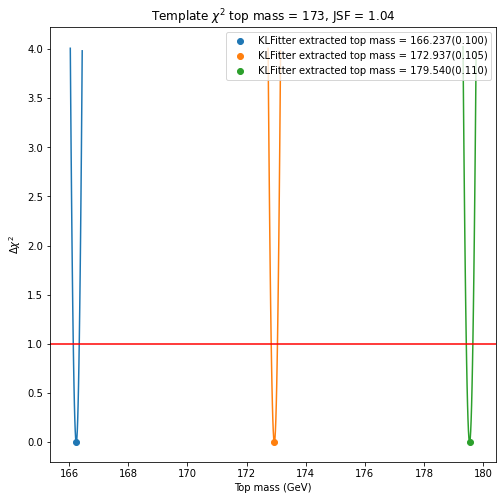

In [39]:
m = 173

plt.figure(figsize=(8, 8))
for JSF in JSF_arr:
    sudo_klf = reco_klf_dic[(m,JSF)][np.logical_and(cut_klf_dic[(m,JSF)], likeli_klf_dic[(m,JSF)])]
    n1 = np.histogram(sudo_klf, bins=bins)[0]
    minuit = Minuit(chi2_klf_arr_func, m=m)
    minuit.migrad()
    minuit.minos()
    a, fa, ok = minuit.mnprofile("m")
    plt.plot(predicted_klf_top_func(a), fa-min(fa))
    min_point = predicted_klf_top_func(minuit.values['m'])
    unc = minuit.errors["m"]*klf_pull_sigma
    plt.scatter(min_point, 0, label=f'KLFitter extracted top mass = {min_point:.3f}({unc:.3f})')

plt.axhline(1, c='r')
plt.title(f'Template $\chi^2$ top mass = {m}, JSF = {JSF}')
plt.xlabel('Top mass (GeV)')
plt.ylabel(r'$\Delta \chi^2$')
plt.legend(loc='upper right')
plt.show()